In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
from scipy.spatial import distance
from sklearn.cluster import KMeans
from kneed import KneeLocator
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import simpleder
import os
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from model import SSCDModel

In [2]:
def compute_bic(gmm, X):
    return gmm.aic(X) + gmm.n_components * np.log(X.shape[0])

def optimal_n_components(features):
    n_components = np.arange(1, 7)
    models = [GMM(n, covariance_type='diag').fit(features) for n in n_components]
    bics = [model.bic(features) for model in models]
    return n_components[np.argmin(bics)]


def detect_speaker_change_points(audio_file_path):
    # Reading audio file
    (rate, sig) = wav.read(audio_file_path)#trimmed_ES2011a.Mix-Headset.wav"
    length_of_audio = len(sig)

    # Define the window size and step size based on the length of the audio
    window_size = length_of_audio // 100
    step_size = window_size // 2

    # Lists to keep track of the BIC values and speaker changes
    BIC_values = []
    speaker_changes = []
    # sse = []
    for i in range(0, len(sig) - window_size, step_size):
        data = mfcc(sig[i : i + window_size], rate) 
        sse = []
        K = range(1, 10)
        for k in K:
            kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
            kmeans.fit(data)
            sse.append(kmeans.inertia_)

        kn = KneeLocator(K, sse, curve='convex', direction='decreasing')
        optimal_clusters = kn.knee
        # print(optimal_clusters)
        # Ensure we have enough data to cluster
        if len(data) > window_size:
            # Fit the KMeans model
            kmeans = KMeans(n_clusters = optimal_clusters, init="k-means++", n_init=10).fit(data)

            # Compute the BIC values
            X1 = data[:step_size]
            X2 = data[step_size:]
            X = data

            bic1 = compute_bic(kmeans, X1)
            bic2 = compute_bic(kmeans, X2)
            bic = compute_bic(kmeans, X)

            diff = abs((bic1 + bic2) - bic)

            # Store the BIC values for threshold computation
            BIC_values.append(diff)

    # Compute the BIC values first for all the windows
    for start_frame in range(0, length_of_audio - window_size + 1, step_size):
        end_frame = start_frame + window_size
        window = sig[start_frame:end_frame]
        features = mfcc(window, rate)
        # gmm = GMM(n_components=2, covariance_type='diag')
        optimal_components = optimal_n_components(features)  # Finding optimal number of components
        gmm = GMM(n_components=optimal_components, covariance_type='diag')
        gmm.fit(features)
        bic = gmm.bic(features)
        BIC_values.append(bic)

    # Calculate the threshold for speaker change
    threshold = np.mean(BIC_values) + np.std(BIC_values)

    # Detect speaker changes and add the start frame to speaker_changes list
    for i, bic in enumerate(BIC_values):
        if bic > threshold:
            speaker_changes.append(i * step_size)
            print("Speaker change detected at frame {}".format(i * step_size))

    print("Speaker change points:", speaker_changes)
    return speaker_changes, rate, sig

In [3]:
# def read_rttm(rttm_file_path):
#     """
#     Read an RTTM file and return the speaker change points.
#     """
#     # Parse RTTM into a list of tuples: (start_time, end_time, speaker_id)
#     turns = []
#     with open(rttm_file_path, 'r') as file:
#         for line in file:
#             parts = line.split()
#             start_time = float(parts[3])
#             duration = float(parts[4])
#             end_time = start_time + duration
#             speaker_id = parts[7]
#             turns.append((start_time, end_time, speaker_id))

#     # Sort turns by start time
#     turns.sort()

#     speaker_change_points = []
#     for i in range(1, len(turns)):
#         # If there is overlap (i.e., the next speaker begins before the current one ends), 
#         # take the start time of the next speaker's turn as the change point.
#         if turns[i-1][1] > turns[i][0]:
#             speaker_change_points.append(turns[i][0])
#         else:
#             # If there is no overlap, take the end time of the current speaker's turn as the change point.
#             speaker_change_points.append(turns[i-1][1])

#     return speaker_change_points

def read_rttm(rttm_file_path):
    """
    Read an RTTM file and return the speaker change points.
    """
    # Parse RTTM into a list of tuples: (start_time, end_time, speaker_id)
    turns = []
    with open(rttm_file_path, 'r') as file:
        for line in file:
            parts = line.split()
            start_time = float(parts[3])
            duration = float(parts[4])
            end_time = start_time + duration
            speaker_id = parts[7]
            turns.append((start_time, end_time, speaker_id))

    # Sort turns by start time
    turns.sort()

    speaker_change_points = []
    active_speakers = set()  # To track all active speakers at a given time

    for i in range(1, len(turns)):
        prev_start, prev_end, prev_speaker = turns[i-1]
        curr_start, curr_end, curr_speaker = turns[i]

        # If current turn overlaps with previous, check if a new speaker is involved
        if prev_end > curr_start and prev_speaker != curr_speaker:
            speaker_change_points.append(curr_start)

            # Update active speakers
            active_speakers.add(prev_speaker)
            active_speakers.add(curr_speaker)

        elif prev_end <= curr_start:  # If no overlap
            # Remove previous speaker from active speakers
            active_speakers.discard(prev_speaker)

            # If a new speaker begins speaking, add change point
            if curr_speaker not in active_speakers:
                speaker_change_points.append(curr_start)

            # Update active speakers
            active_speakers.add(curr_speaker)

    return speaker_change_points, turns

def plot_speaker_change_points(rttm_file_path, speaker_changes, rate, sig):
    # Read RTTM file
    ground_truth_changes, turns = read_rttm(rttm_file_path)#'trimmed_ES2011a.rttm

    # Convert speaker_changes list to time from samples
    speaker_changes_time = [i / rate for i in speaker_changes]


    # Normalize signal
    sig_norm = sig / np.max(np.abs(sig))

    # Calculate time array for x-axis of waveform
    time_array = np.arange(0, len(sig)) / rate

    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 4))

    # Plot waveform
    ax.plot(time_array, sig_norm, label='Audio Waveform', alpha=0.7)

    # Plot speaker change points
    for change in speaker_changes_time:
        ax.axvline(x=change, color='r', linestyle='--', label='Detected Changes', alpha=0.5)

    # Plot ground truth
    for change in ground_truth_changes:
        ax.axvline(x=change, color='g', linestyle='--', label='Ground Truth', alpha=0.5)

    # Set labels and title
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title('Detected Speaker Changes and Ground Truth')

    # Handle duplicates in legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    output_dir = "/home/rahul/Documents/Outputs/mfcc_plots_final"
    file_name = os.path.splitext(os.path.basename(rttm_file_path))[0].split("_")[1]
    plt.tight_layout()
    # print(os.path.join(output_dir, f"{file_name}{'.png'}"))
    plt.savefig(os.path.join(output_dir, f"{file_name}{'.png'}"))
    plt.show()
    
    return ground_truth_changes, speaker_changes_time, turns

In [4]:
# Function to create tuples
# def create_segments(change_points):
#     segments = []
#     for i in range(0, len(change_points)-1):
#         speaker = f"speaker_{i+1}"
#         start = change_points[i]
#         end = change_points[i+1]
#         segments.append((speaker, start, end))
#     return segments

# def create_segments(change_points):
#     """
#     Convert change points into segments.
#     """
#     # Sort change points to ensure start_time is always less than end_time
#     change_points.sort()

#     segments = []
#     for i in range(len(change_points) - 1):
#         start_time = change_points[i]
#         end_time = change_points[i + 1]

#         if start_time == end_time:
#             continue

#         if start_time >= end_time:
#             raise ValueError(
#                 f"Found a segment with start time ({start_time}) greater or equal to end time ({end_time}).")
#         segments.append(("speaker", start_time, end_time))
#     return segments


def create_segments(turns_or_change_points, is_ground_truth=False, threshold=1):
    """
    Convert turns or change points into segments.
    """
    segments = []
    if not is_ground_truth:
        turns_or_change_points.sort()
    # If handling ground truth with speaker information
    if is_ground_truth:
        active_speakers = set()
        for i in range(1, len(turns_or_change_points)):
            prev_start, prev_end, prev_speaker = turns_or_change_points[i - 1]
            curr_start, curr_end, curr_speaker = turns_or_change_points[i]

            # Skip segments where start is greater than or equal to end
            if prev_start >= curr_start:
                continue

            if prev_end > curr_start and prev_speaker != curr_speaker:
                segments.append((prev_start, curr_start, str(prev_speaker))) # Ensure speaker's id is a string
                active_speakers.add(prev_speaker)
                active_speakers.add(curr_speaker)
            elif prev_end <= curr_start:
                active_speakers.discard(prev_speaker)
                if curr_speaker not in active_speakers:
                    segments.append((prev_start, curr_start, str(prev_speaker))) # Ensure speaker's id is a string
                active_speakers.add(curr_speaker)

    # If handling predictions without speaker information
    else:
        prev_start = None
        prev_end = None
        for i in range(1, len(turns_or_change_points)):
            start = turns_or_change_points[i - 1]
            end = turns_or_change_points[i]

            # Check if the current start and previous end are within the threshold
            if prev_end is not None and (start - turns_or_change_points[prev_end]) < threshold:
                # Update the end of the previous segment to merge with current
                segments[-1] = (segments[-1][0], end, "speaker")
                continue

            if prev_start is not None and start < prev_start:
                # Handle case where change points are not in order
                # You can add custom logic here, e.g., logging a warning or skipping this iteration
                print(f"Warning: start {start} is smaller than previous start {prev_start}")
            # Use a dummy speaker ID, since predictions don't include speaker information
            if start < end:
                segments.append((start, end, "speaker"))
                prev_end = i
            # segments.append((start, end, "speaker"))

    return segments

# def create_segments(turns):
#     """
#     Convert turns into segments.
#     """
#     segments = []
#     for i in range(len(turns) - 1):
#         prev_start, prev_end, prev_speaker = turns[i]
#         curr_start, curr_end, curr_speaker = turns[i + 1]

#         if prev_speaker != curr_speaker:
#             start_time = prev_end
#             end_time = curr_start

#             if start_time == end_time:
#                 continue

#             if start_time >= end_time:
#                 raise ValueError(
#                     f"Found a segment with start time ({start_time}) greater or equal to end time ({end_time}).")

#             segments.append((prev_speaker, start_time, end_time))
#     return segments

def accuracy_metrics_calculation(speaker_changes, rate, sig, rttm_file_path):
    # Normalize signal
    ground_truth_changes, turns = read_rttm(rttm_file_path)#'trimmed_ES2011a.rttm

    # Convert speaker_changes list to time from samples
    speaker_changes_time = [i / rate for i in speaker_changes]
    
    sig_norm = sig / np.max(np.abs(sig))

    # Calculate time array for x-axis of waveform
    time_array = np.arange(0, len(sig)) / rate

    # Define a tolerance for speaker change detection (in seconds)
    tolerance = 0.5  # this depends on your problem

    # Define frame size and number of frames
    frame_size = 0.01  # 10ms frames
    num_frames = int(np.ceil(time_array[-1] / frame_size))

    # Create binary arrays for detected changes and ground truth changes
    ground_truth_binary = np.zeros(num_frames)
    predicted_binary = np.zeros(num_frames)

    for change in ground_truth_changes:
        frame_range = int(np.floor((change-tolerance) / frame_size)), int(np.ceil((change+tolerance) / frame_size))
        if frame_range[1] < num_frames:  # Ensure the frame index is within bounds
            ground_truth_binary[frame_range[0]:frame_range[1]] = 1

    for change in speaker_changes_time:
        frame_range = int(np.floor((change-tolerance) / frame_size)), int(np.ceil((change+tolerance) / frame_size))
        if frame_range[1] < num_frames:  # Ensure the frame index is within bounds
            predicted_binary[frame_range[0]:frame_range[1]] = 1

    # Convert changes to time in seconds
    speaker_changes_time = np.array(speaker_changes) / rate

    # Create segments
    ground_truth_segments = create_segments(ground_truth_changes)
    predicted_segments = create_segments(speaker_changes_time)
    # Add an artificial end point to both lists if they don't align perfectly
    if len(ground_truth_segments) != len(predicted_segments):
        max_time = max(ground_truth_segments[-1][2], predicted_segments[-1][2])
        ground_truth_segments.append(("speaker", max_time, max_time))
        predicted_segments.append(("speaker", max_time, max_time))
    ref = [(label, start, end) for start, end, label in ground_truth_segments]
    hyp = [(label, start, end) for start, end, label in predicted_segments]

    ref = [
        (label, float(start), float(end))
        for label, start, end in ref
        if all(isinstance(value, (int, float)) or value.replace('.', '', 1).isdigit() for value in [start, end])
    ]

    ref = [
        (label, float(start), float(end))
        for label, start, end in ref
        if all(isinstance(value, (int, float)) or value.replace('.', '', 1).isdigit() for value in [start, end])
    ]
    hyp = [
        (label, float(start), float(end))
        for label, start, end in hyp
        if all(isinstance(value, (int, float)) or value.replace('.', '', 1).isdigit() for value in [start, end])
    ]

    # hyp = list(set(hyp))
    # Calculate DER using simpleder
    # Your existing code (imports, loading data, etc.)

    # Code snippet to remove overlaps
    ref_sorted = sorted(ref, key=lambda x: x[1])  # Ensure sorted by start time
    no_overlap_ref = []
    prev_end_time = 0

    for segment in ref_sorted:
        speaker, start_time, end_time = segment
        # If this segment overlaps with the previous, truncate its start time
        if start_time < prev_end_time:
            start_time = prev_end_time
        if start_time < end_time:  # Only include non-empty segments
            no_overlap_ref.append((speaker, start_time, end_time))
            prev_end_time = end_time

    print('about to calculate DER')
    # Calculate DER
    der = simpleder.DER(no_overlap_ref, hyp)
    # der = simpleder.DER(ground_truth_segments, predicted_segments)
    print('DER calculated')

    # Calculate Precision, Recall and F1 Score
    precision, recall, f1, _ = precision_recall_fscore_support(ground_truth_binary, predicted_binary, average='binary')

    # Calculate ROC AUC score
    auc = roc_auc_score(ground_truth_binary, predicted_binary)

    # Save all metrics in a dictionary
    metrics = {'DER':der, 'Precision': precision, 'Recall': recall, 'F1': f1, 'AUROC': auc}

    # Plotting (same as before)

    # Print metrics
    for metric, value in metrics.items():
        print(f'{metric}: {value}')
    
    return metrics, ref, hyp

In [5]:
def plot_segments(rate, sig, ref_segments, hyp_segments,rttm_file_path, threshold=0.5):
    y, sr = librosa.load('trimmed_ES2011a.Mix-Headset.wav', sr=None)
    t = np.arange(len(y)) / sr
     # Filter segments that fall within the audio duration
#     ref_segments = [seg for seg in ref_segments if not (seg[1] > np.max(t) or seg[2] < np.min(t))]
#     hyp_segments = [seg for seg in hyp_segments if not (seg[1] > np.max(t) or seg[2] < np.min(t))]
    
    sig_norm = sig / np.max(np.abs(sig))

    # Calculate time array for x-axis of waveform
    time_array = np.arange(0, len(sig)) / rate
    
    fig, ax = plt.subplots(figsize=(20, 10))
    # plt.plot(t, y, color='grey', linewidth=0.5, label="Waveform")
    plt.plot(time_array, sig_norm, label='Waveform', color='lightblue', linewidth=0.5, alpha=0.7)
    # Plot the ground truth speaker change points
    speaker_change_points = []
    prev_speaker, prev_start, prev_end = ref_segments[0]
    speaker_change_points.append(prev_start)

    for seg in ref_segments:
        try:
            curr_speaker, curr_start, curr_end = seg  # Unpack tuple
            curr_start = float(curr_start)
            curr_end = float(curr_end)
        except (ValueError, TypeError):
            print(f"Invalid segment value: {seg}. Skipping this segment.")
            continue

        speaker_change_points.append(curr_start)

        if curr_speaker == prev_speaker and (curr_start - prev_end) < threshold:
            # Update the end of the previous segment to merge with current
            speaker_change_points[-1] = curr_end
        else:
            speaker_change_points.append(curr_start)

        prev_speaker, prev_start, prev_end = curr_speaker, curr_start, curr_end
    print(speaker_change_points)
    # Plot speaker change points
    for seg in speaker_change_points:
        ax.axvline(x=seg, color='g',ymin=0.25, ymax=0.75, linestyle='-', linewidth=0.5, label="Ground Truth Change")

    # Parse the speaker turns and plot the speaker change points detected by the model
    model_change_points = []
    active_speakers = set()  # To track all active speakers at a given time
    prev_start, prev_end, prev_label = hyp_segments[0]

    for i in range(1, len(hyp_segments)):  # change turns to hyp_segments
        curr_label, curr_start, curr_end = hyp_segments[i]

        if prev_end > curr_start and prev_label != curr_label:
            if prev_end is not None and (curr_start - prev_end) < threshold:
                model_change_points[-1] = curr_end
            else:
                model_change_points.append(curr_start)

            active_speakers.add(prev_label)
            active_speakers.add(curr_label)

        elif prev_end <= curr_start:  # If no overlap
            active_speakers.discard(prev_label)

            if curr_label not in active_speakers:
                model_change_points.append(curr_start)

            active_speakers.add(curr_label)

        prev_label, prev_start, prev_end = curr_label, curr_start, curr_end

    # Plot the speaker change points detected by the model
    for seg in model_change_points:
        ax.axvline(x=seg, color='r',ymin=0.25, ymax=0.75, linestyle='--', linewidth=0.5, label="Model Change Point")

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    output_dir = "/home/rahul/Documents/Outputs/mfcc_plots_final"
    file_name = os.path.splitext(os.path.basename(rttm_file_path))[0].split("_")[1]
    plt.tight_layout()
    # print(os.path.join(output_dir, f"{file_name}{'.png'}"))
    plt.savefig(os.path.join(output_dir, f"{file_name}{'.png'}"))
    plt.show()

In [6]:
def generate_speaker_change_results(audio_file, rttm_file):
    speaker_changes, rate, sig = detect_speaker_change_points(audio_file)
    # ground_truth_changes, speaker_changes_time, turns = plot_speaker_change_points(rttm_file, speaker_changes, rate, sig)
    accuracy_metrics, ref, hyp = accuracy_metrics_calculation(speaker_changes, rate, sig, rttm_file)
    plot_segments(rate, sig, ref, hyp, rttm_file)
    print(accuracy_metrics)
    return accuracy_metrics

In [7]:
# generate_speaker_change_results('trimmed_ES2011a.Mix-Headset.wav','trimmed_ES2011a.rttm')

In [8]:
import os

def pair_files(wav_files, rttm_files, dir_path):
    pairs = []
    for wav in wav_files:
        wav_stem = os.path.splitext(wav)[0].replace('trimmed_','').replace('.Mix-Headset','')
        for rttm in rttm_files:
            rttm_stem = os.path.splitext(rttm)[0].replace('trimmed_','')
            if wav_stem == rttm_stem:
                pairs.append((os.path.join(dir_path, wav), os.path.join(dir_path, rttm)))
    return pairs

def get_file_pairs(dir_path):
    # make sure dir_path is an absolute path
    dir_path = os.path.abspath(dir_path)

    # get list of all files in directory
    files = os.listdir(dir_path)
    wav_files = [f for f in files if f.endswith('.wav')]
    rttm_files = [f for f in files if f.endswith('.rttm')]

    # get list of pairs of .wav and .rttm files with the same base name
    file_pairs = pair_files(wav_files, rttm_files, dir_path)

    # raise an error if no pairs are found
    if not file_pairs:
        raise ValueError(f"No paired files found in directory {dir_path}")

    return file_pairs

In [9]:
def get_processed_files(file_path='processed_files_mfcc.txt'):
    try:
        with open(file_path, 'r') as file:
            return file.read().splitlines()
    except FileNotFoundError:
        return []

# Function to append processed file to the list
def add_processed_file(file_path, processed_file_path='processed_files_mfcc.txt'):
    with open(processed_file_path, 'a') as file:
        file.write(file_path + '\n')

Skipping /home/rahul/Documents/test_data_trimmed/trimmed_EN2001d.Mix-Headset.wav, already processed.
Skipping /home/rahul/Documents/test_data_trimmed/trimmed_TS3012c.Mix-Headset.wav, already processed.
Skipping /home/rahul/Documents/test_data_trimmed/trimmed_IS1005b.Mix-Headset.wav, already processed.
Skipping /home/rahul/Documents/test_data_trimmed/trimmed_TS3005b.Mix-Headset.wav, already processed.
Skipping /home/rahul/Documents/test_data_trimmed/trimmed_ES2006c.Mix-Headset.wav, already processed.
Skipping /home/rahul/Documents/test_data_trimmed/trimmed_IN1016.Mix-Headset.wav, already processed.
Skipping /home/rahul/Documents/test_data_trimmed/trimmed_EN2004a.Mix-Headset.wav, already processed.
Skipping /home/rahul/Documents/test_data_trimmed/trimmed_ES2010d.Mix-Headset.wav, already processed.
Skipping /home/rahul/Documents/test_data_trimmed/trimmed_IS1007d.Mix-Headset.wav, already processed.
Skipping /home/rahul/Documents/test_data_trimmed/trimmed_TS3005c.Mix-Headset.wav, already pr

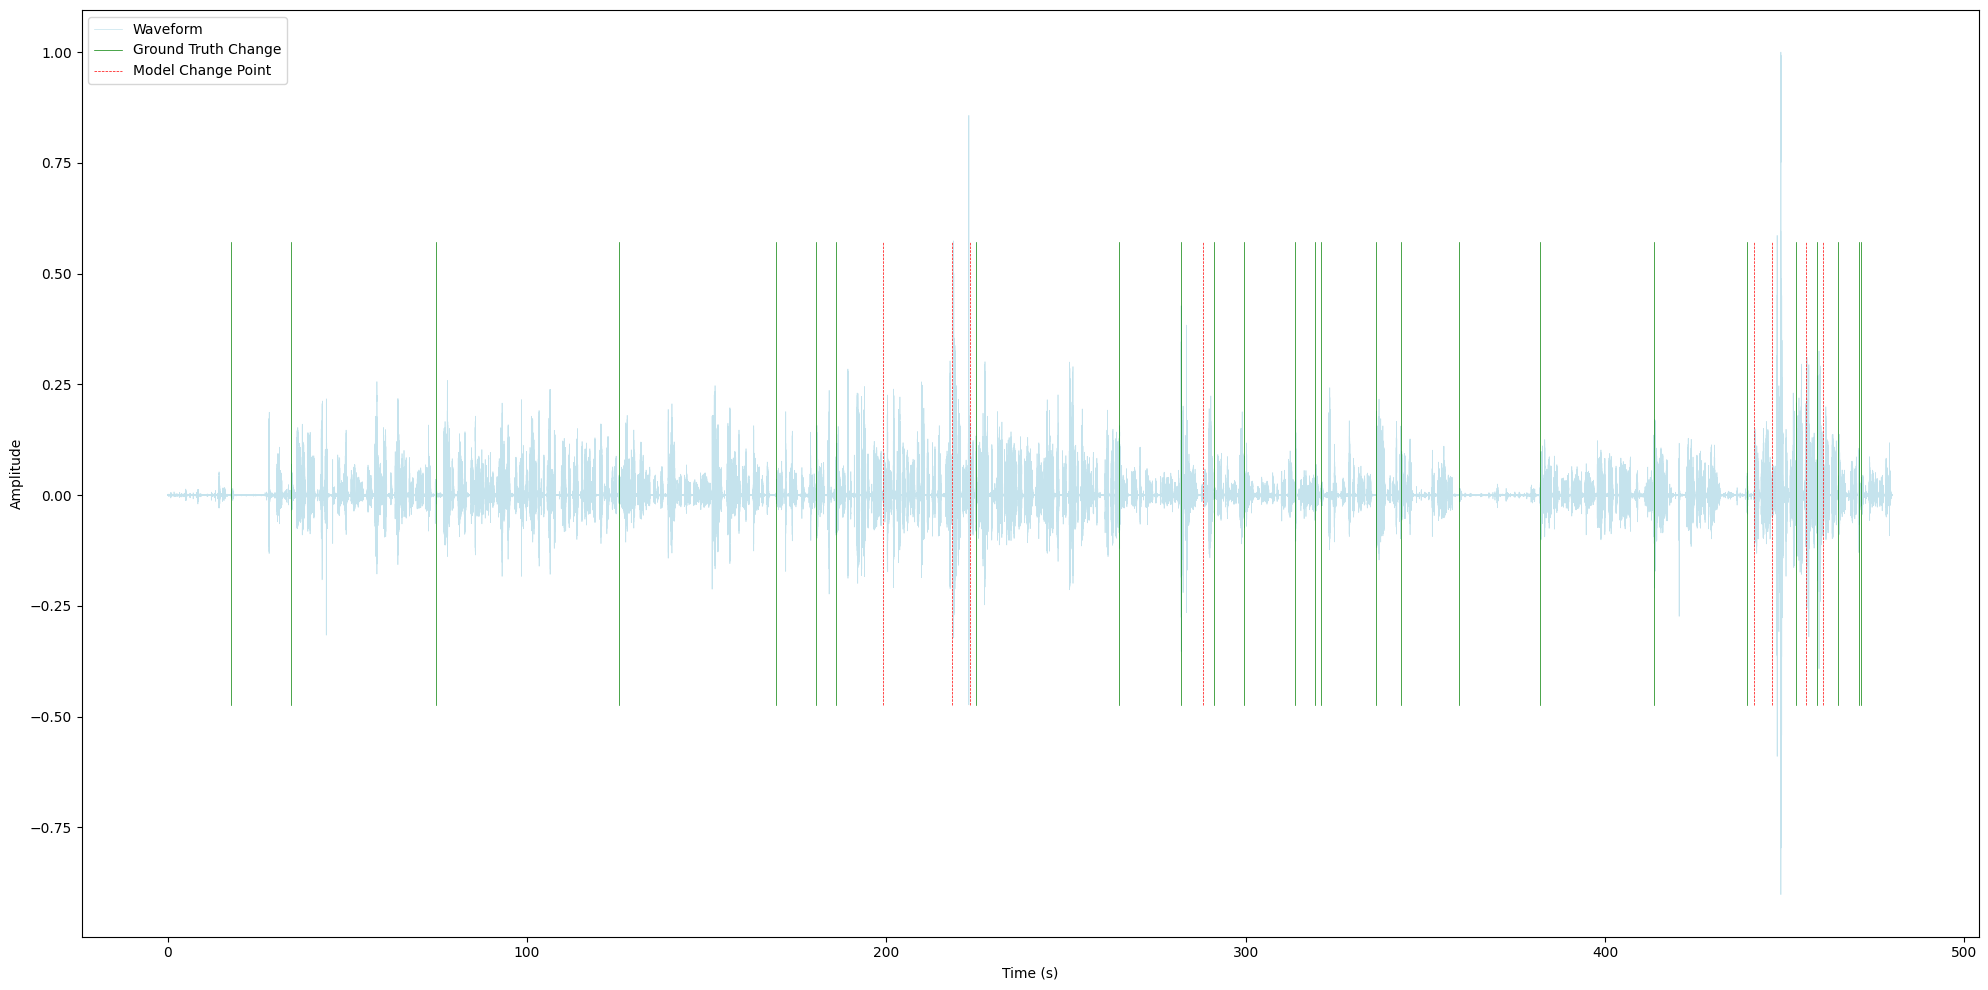

{'DER': 0.21190082644628094, 'Precision': 0.125, 'Recall': 0.04510825982357659, 'F1': 0.06629345904537419, 'AUROC': 0.5042452858682656}
Metrics for file ES2016d.Mix-Headset generated
Metrics for file ES2016d.Mix-Headset saved in file
Speaker change detected at frame 2227200
Speaker change detected at frame 2841600
Speaker change detected at frame 2918400
Speaker change detected at frame 2956800
Speaker change detected at frame 3264000
Speaker change detected at frame 4646400
Speaker change detected at frame 4684800
Speaker change detected at frame 4723200
Speaker change detected at frame 4761600
Speaker change detected at frame 5030400
Speaker change detected at frame 5068800
Speaker change detected at frame 6105600
Speaker change detected at frame 6144000
Speaker change detected at frame 6182400
Speaker change detected at frame 6220800
Speaker change detected at frame 6259200
Speaker change detected at frame 6297600
Speaker change detected at frame 6643200
Speaker change detected at f

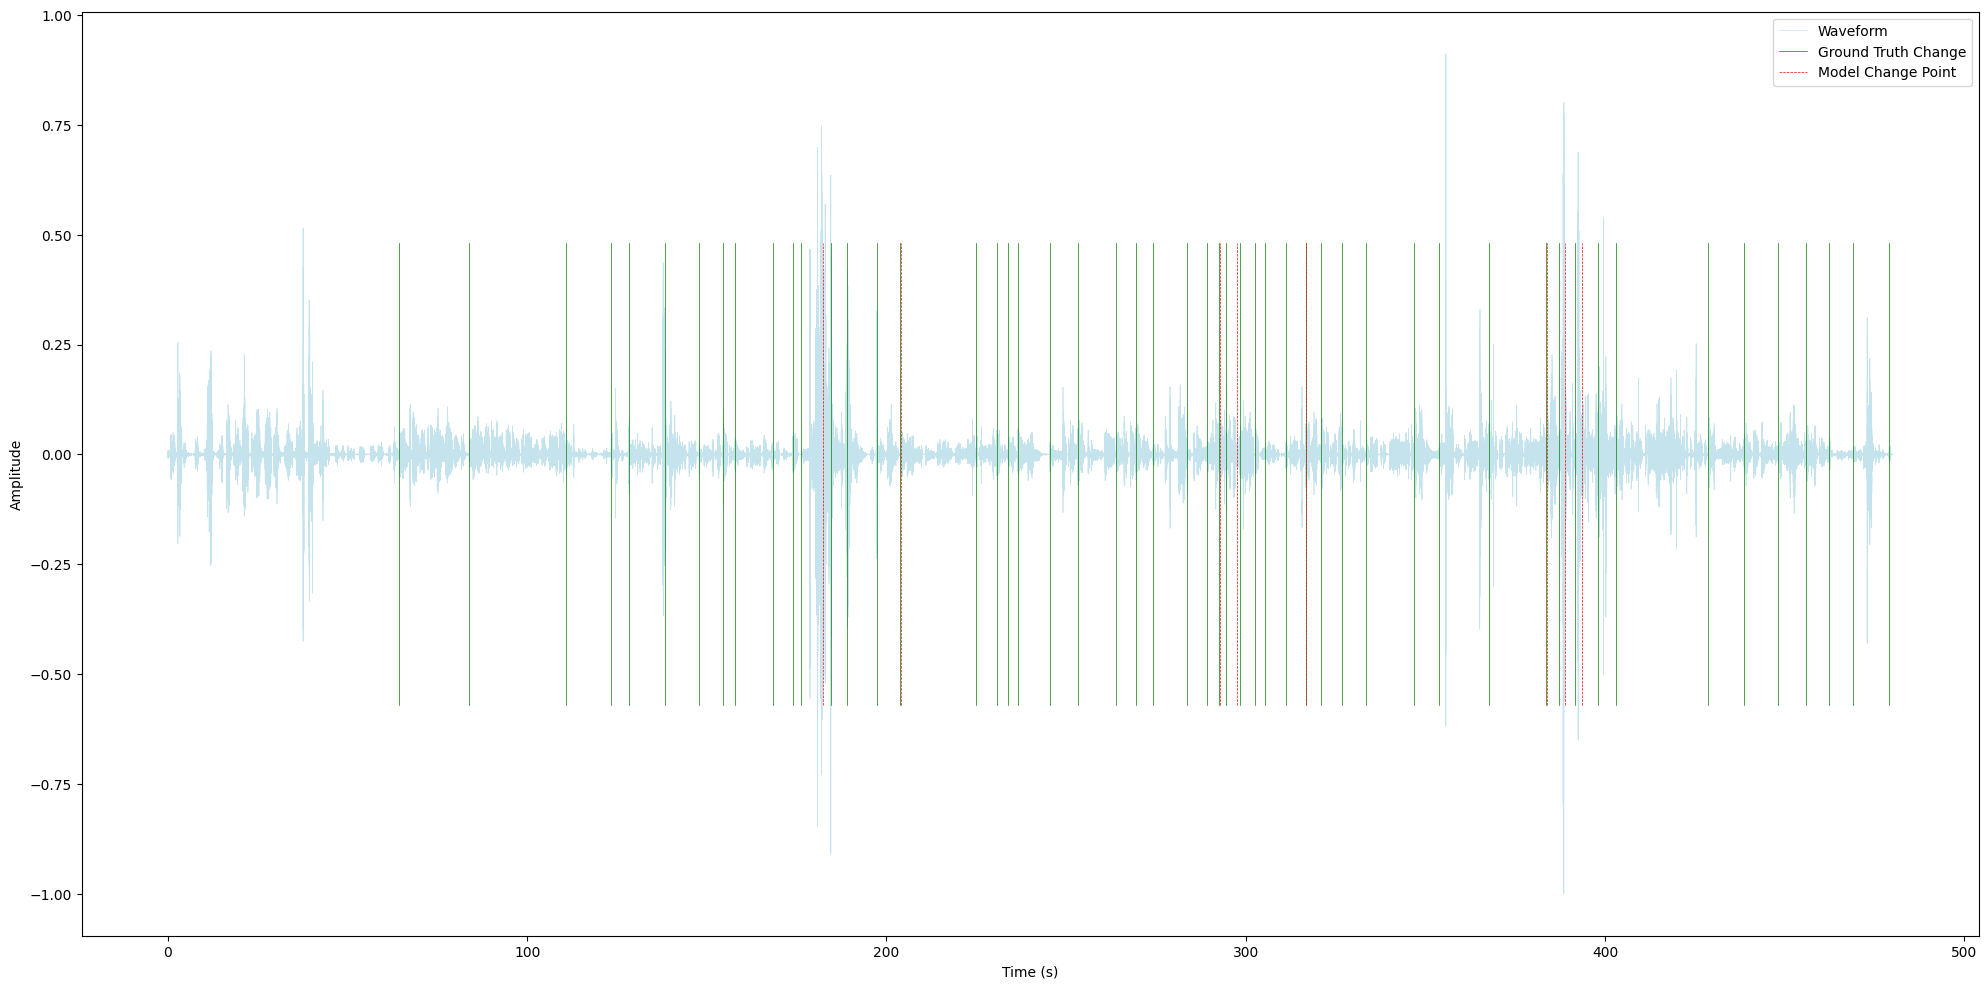

{'DER': 0.2822862655251416, 'Precision': 0.40830267997898056, 'Recall': 0.07799638626781771, 'F1': 0.13097345132743363, 'AUROC': 0.5241972046487099}
Metrics for file ES2015d.Mix-Headset generated
Metrics for file ES2015d.Mix-Headset saved in file
Speaker change detected at frame 1497600
Speaker change detected at frame 1536000
Speaker change detected at frame 1766400
Speaker change detected at frame 1920000
Speaker change detected at frame 4416000
Speaker change detected at frame 5644800
Speaker change points: [1497600, 1536000, 1766400, 1920000, 4416000, 5644800]
about to calculate DER
DER calculated
DER: 0.43459197696485824
Precision: 0.03833333333333333
Recall: 0.007453013609850939
F1: 0.012479652740097666
AUROC: 0.4973031198877059
[7.05, 16.4, 22.6, 34.52, 41.82, 121.21, 151.21, 166.37, 176.2, 183.08, 187.64, 227.45, 316.9, 374.84, 438.88, 465.48]


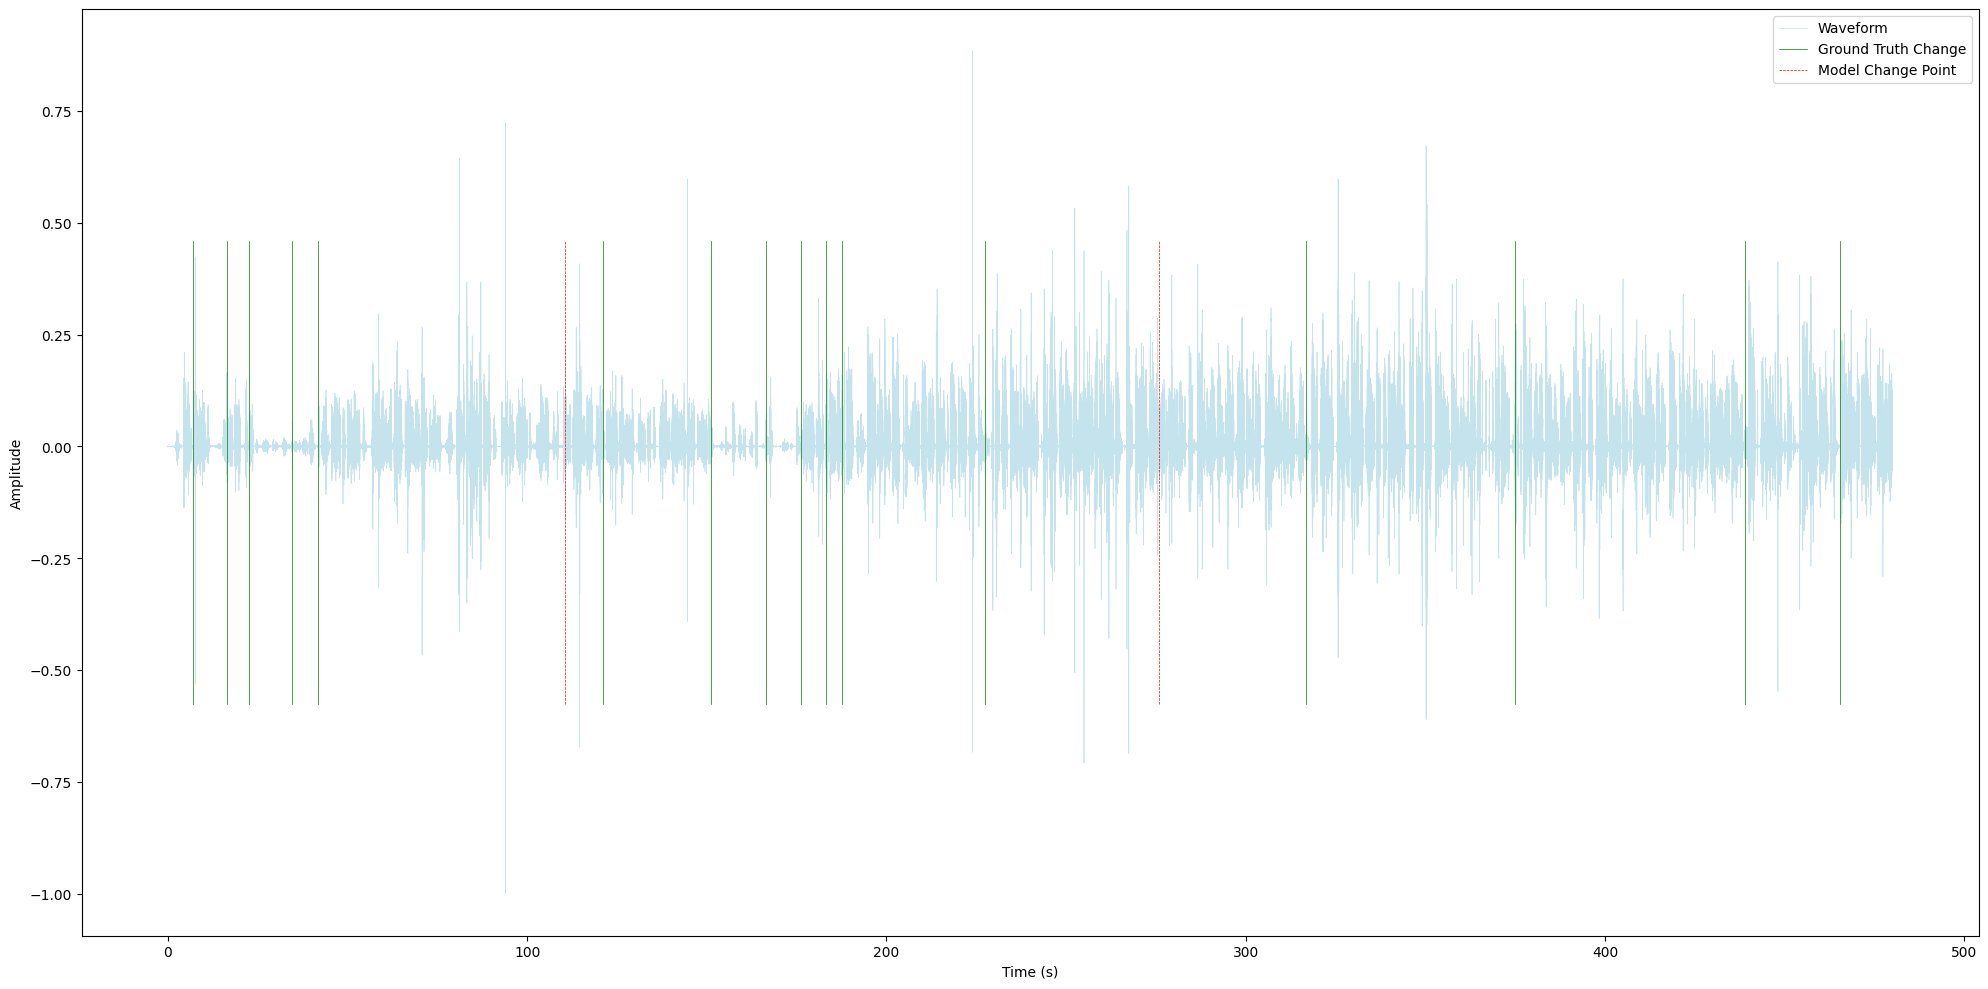

{'DER': 0.43459197696485824, 'Precision': 0.03833333333333333, 'Recall': 0.007453013609850939, 'F1': 0.012479652740097666, 'AUROC': 0.4973031198877059}
Metrics for file ES2003b.Mix-Headset generated
Metrics for file ES2003b.Mix-Headset saved in file
Speaker change detected at frame 652800
Speaker change detected at frame 1113600
Speaker change detected at frame 1152000
Speaker change detected at frame 2611200
Speaker change detected at frame 3302400
Speaker change detected at frame 3340800
Speaker change detected at frame 3379200
Speaker change detected at frame 3494400
Speaker change detected at frame 3686400
Speaker change detected at frame 3724800
Speaker change detected at frame 3840000
Speaker change detected at frame 3878400
Speaker change detected at frame 4377600
Speaker change detected at frame 4492800
Speaker change detected at frame 4531200
Speaker change detected at frame 4800000
Speaker change detected at frame 4953600
Speaker change detected at frame 5068800
Speaker chang

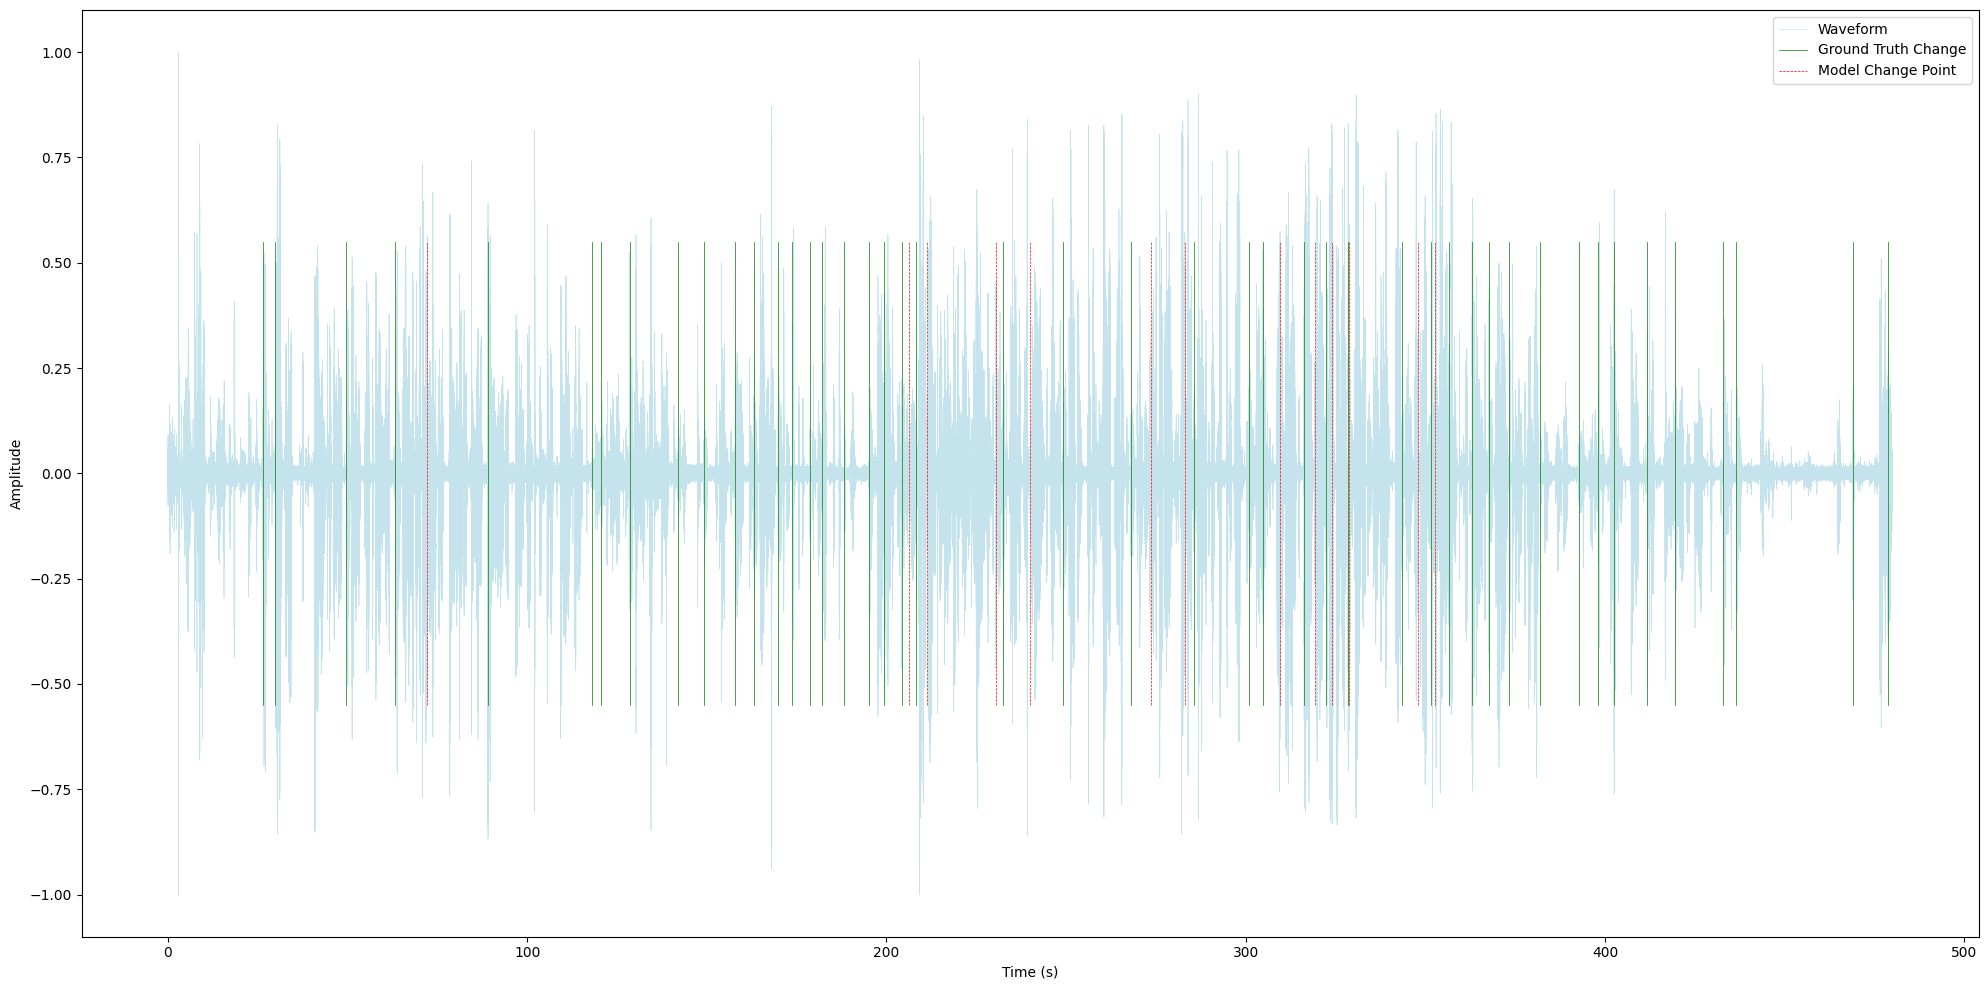

{'DER': 0.27316135022216315, 'Precision': 0.268188302425107, 'Recall': 0.07954305056060927, 'F1': 0.12269538260727689, 'AUROC': 0.5131539774154159}
Metrics for file IS1001b.Mix-Headset generated
Metrics for file IS1001b.Mix-Headset saved in file
Speaker change detected at frame 614400
Speaker change detected at frame 652800
Speaker change detected at frame 1305600
Speaker change detected at frame 1574400
Speaker change detected at frame 1920000
Speaker change detected at frame 1958400
Speaker change detected at frame 1996800
Speaker change detected at frame 2035200
Speaker change detected at frame 2112000
Speaker change detected at frame 2265600
Speaker change detected at frame 2304000
Speaker change detected at frame 2457600
Speaker change detected at frame 2496000
Speaker change detected at frame 2534400
Speaker change detected at frame 3571200
Speaker change detected at frame 3686400
Speaker change detected at frame 4569600
Speaker change detected at frame 4608000
Speaker change det

{'DER': 0.24424831840966532, 'Precision': 0.17261055634807418, 'Recall': 0.06355042016806722, 'F1': 0.0928982725527831, 'AUROC': 0.5112019978252368}
Metrics for file EN2009d.Mix-Headset generated
Metrics for file EN2009d.Mix-Headset saved in file
Speaker change detected at frame 1382400
Speaker change detected at frame 5184000
Speaker change detected at frame 5414400
Speaker change detected at frame 5452800
Speaker change detected at frame 5760000
Speaker change detected at frame 6489600
Speaker change detected at frame 6566400
Speaker change detected at frame 6758400
Speaker change detected at frame 6796800
Speaker change detected at frame 6873600
Speaker change detected at frame 6912000
Speaker change detected at frame 6988800
Speaker change detected at frame 7104000
Speaker change detected at frame 7180800
Speaker change points: [1382400, 5184000, 5414400, 5452800, 5760000, 6489600, 6566400, 6758400, 6796800, 6873600, 6912000, 6988800, 7104000, 7180800]
about to calculate DER
DER ca

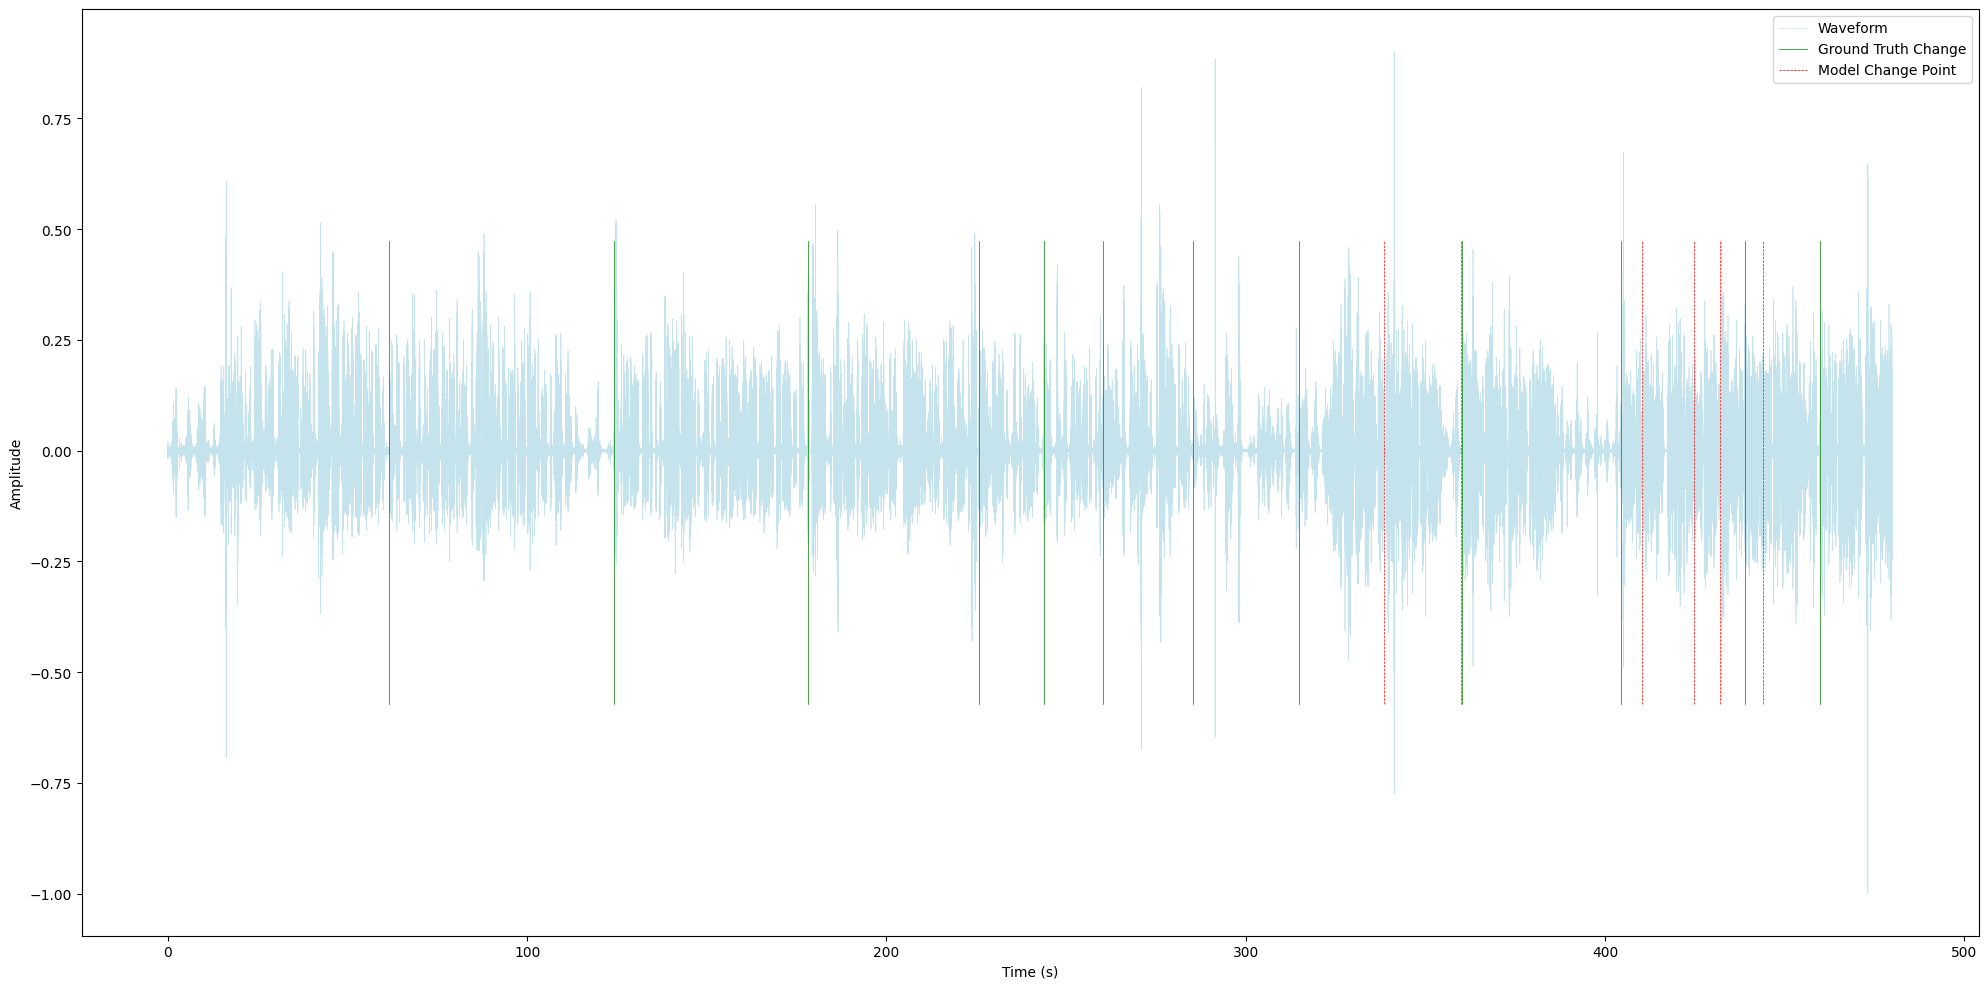

{'DER': 0.09001883239171367, 'Precision': 0.11571428571428571, 'Recall': 0.07102148180622533, 'F1': 0.08801955990220049, 'AUROC': 0.5219715121360793}
Metrics for file ES2012c.Mix-Headset generated
Metrics for file ES2012c.Mix-Headset saved in file
Speaker change detected at frame 768000
Speaker change detected at frame 806400
Speaker change detected at frame 921600
Speaker change detected at frame 998400
Speaker change detected at frame 1036800
Speaker change detected at frame 1075200
Speaker change detected at frame 1497600
Speaker change detected at frame 1536000
Speaker change detected at frame 2880000
Speaker change detected at frame 4377600
Speaker change detected at frame 4416000
Speaker change detected at frame 5760000
Speaker change detected at frame 5798400
Speaker change detected at frame 5836800
Speaker change detected at frame 5875200
Speaker change detected at frame 5913600
Speaker change detected at frame 5990400
Speaker change detected at frame 6028800
Speaker change det

{'DER': 0.17030470914127427, 'Precision': 0.2704166666666667, 'Recall': 0.08501440922190202, 'F1': 0.12936017540362768, 'AUROC': 0.5208181593748612}
Metrics for file TS3008b.Mix-Headset generated
Metrics for file TS3008b.Mix-Headset saved in file
Speaker change detected at frame 307200
Speaker change detected at frame 537600
Speaker change detected at frame 576000
Speaker change detected at frame 614400
Speaker change detected at frame 691200
Speaker change detected at frame 1958400
Speaker change detected at frame 1996800
Speaker change detected at frame 2803200
Speaker change detected at frame 2995200
Speaker change detected at frame 3033600
Speaker change detected at frame 3571200
Speaker change detected at frame 3801600
Speaker change detected at frame 3840000
Speaker change detected at frame 3878400
Speaker change detected at frame 3916800
Speaker change detected at frame 3955200
Speaker change detected at frame 3993600
Speaker change detected at frame 4492800
Speaker change detec

{'DER': 0.06626698131258374, 'Precision': 0.21757432254669823, 'Recall': 0.07609495767390505, 'F1': 0.11275478901083917, 'AUROC': 0.49800115760459224}
Metrics for file EN2006b.Mix-Headset generated
Metrics for file EN2006b.Mix-Headset saved in file
Speaker change detected at frame 576000
Speaker change detected at frame 614400
Speaker change detected at frame 652800
Speaker change detected at frame 729600
Speaker change detected at frame 883200
Speaker change detected at frame 1382400
Speaker change detected at frame 1420800
Speaker change detected at frame 1536000
Speaker change detected at frame 5414400
Speaker change detected at frame 5452800
Speaker change detected at frame 5760000
Speaker change detected at frame 5798400
Speaker change detected at frame 5836800
Speaker change detected at frame 5875200
Speaker change detected at frame 6489600
Speaker change detected at frame 6528000
Speaker change detected at frame 6720000
Speaker change detected at frame 6758400
Speaker change det

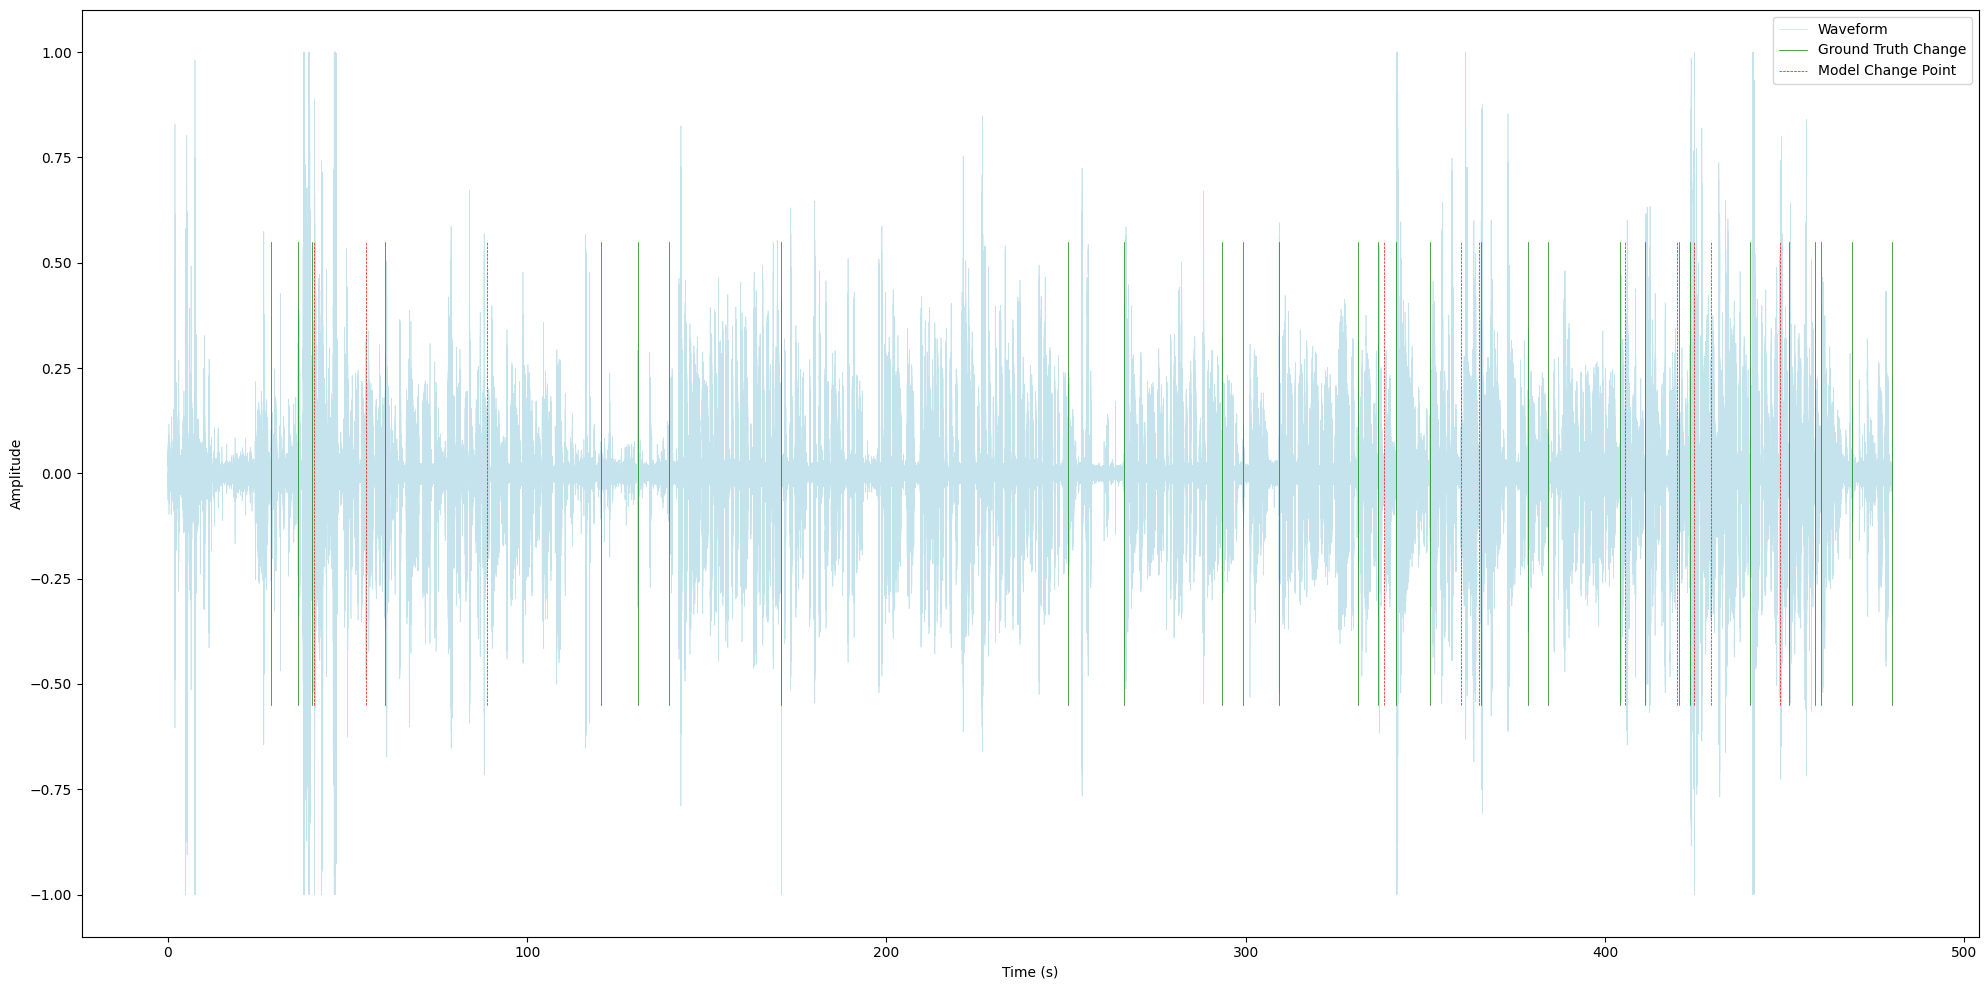

{'DER': 0.07457063711911352, 'Precision': 0.3826469412235106, 'Recall': 0.1650853889943074, 'F1': 0.2306579898770788, 'AUROC': 0.5642501560520194}
Metrics for file IS1006c.Mix-Headset generated
Metrics for file IS1006c.Mix-Headset saved in file
Speaker change detected at frame 960000
Speaker change detected at frame 1536000
Speaker change detected at frame 1574400
Speaker change detected at frame 1920000
Speaker change detected at frame 2803200
Speaker change detected at frame 2841600
Speaker change detected at frame 2918400
Speaker change detected at frame 3225600
Speaker change detected at frame 3302400
Speaker change detected at frame 3955200
Speaker change detected at frame 3993600
Speaker change detected at frame 4262400
Speaker change detected at frame 5452800
Speaker change detected at frame 5798400
Speaker change detected at frame 5836800
Speaker change detected at frame 6643200
Speaker change points: [960000, 1536000, 1574400, 1920000, 2803200, 2841600, 2918400, 3225600, 33024

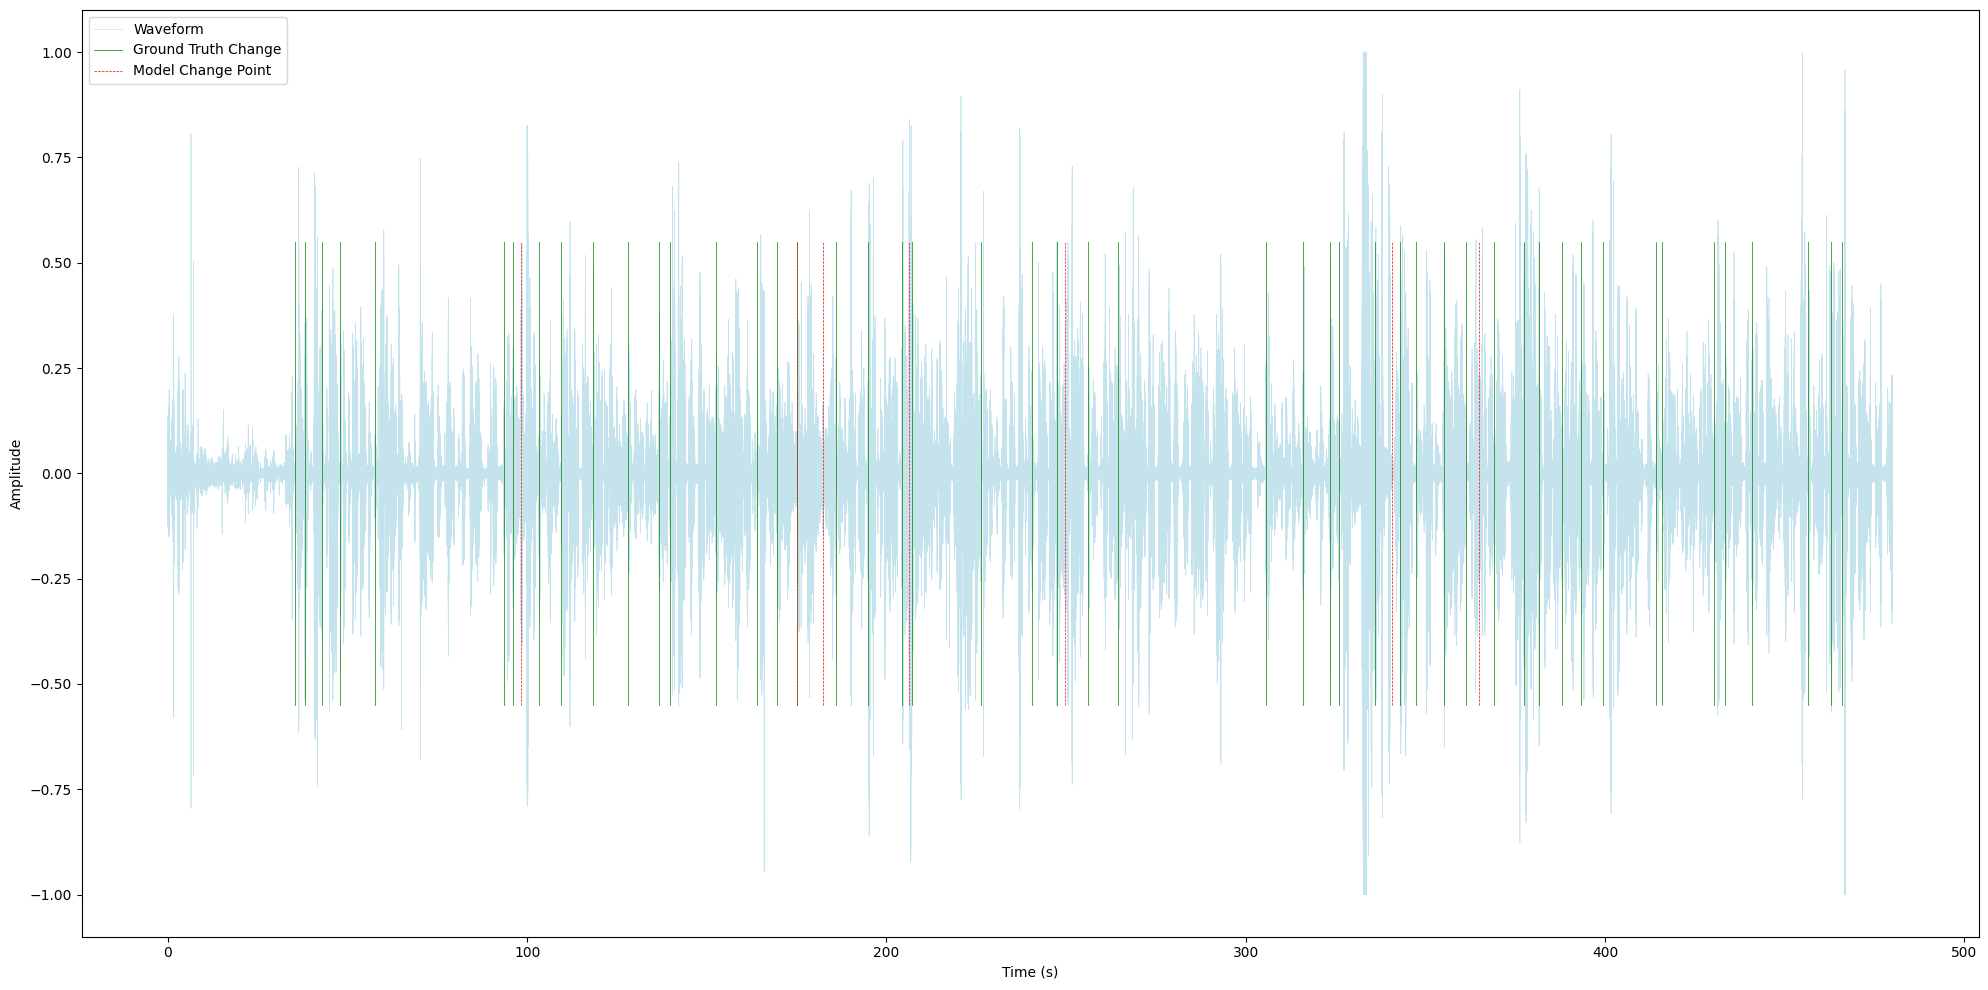

{'DER': 0.17518112576630143, 'Precision': 0.4509681449094316, 'Recall': 0.07985842274084726, 'F1': 0.13568878030445408, 'AUROC': 0.5286481209933606}
Metrics for file IN1009.Mix-Headset generated
Metrics for file IN1009.Mix-Headset saved in file
Speaker change detected at frame 230400
Speaker change detected at frame 268800
Speaker change detected at frame 1920000
Speaker change detected at frame 1958400
Speaker change detected at frame 2803200
Speaker change detected at frame 2841600
Speaker change detected at frame 4108800
Speaker change detected at frame 4147200
Speaker change detected at frame 4646400
Speaker change detected at frame 4684800
Speaker change detected at frame 4838400
Speaker change detected at frame 4876800
Speaker change detected at frame 4915200
Speaker change detected at frame 4953600
Speaker change detected at frame 4992000
Speaker change detected at frame 5030400
Speaker change detected at frame 5068800
Speaker change detected at frame 5107200
Speaker change dete

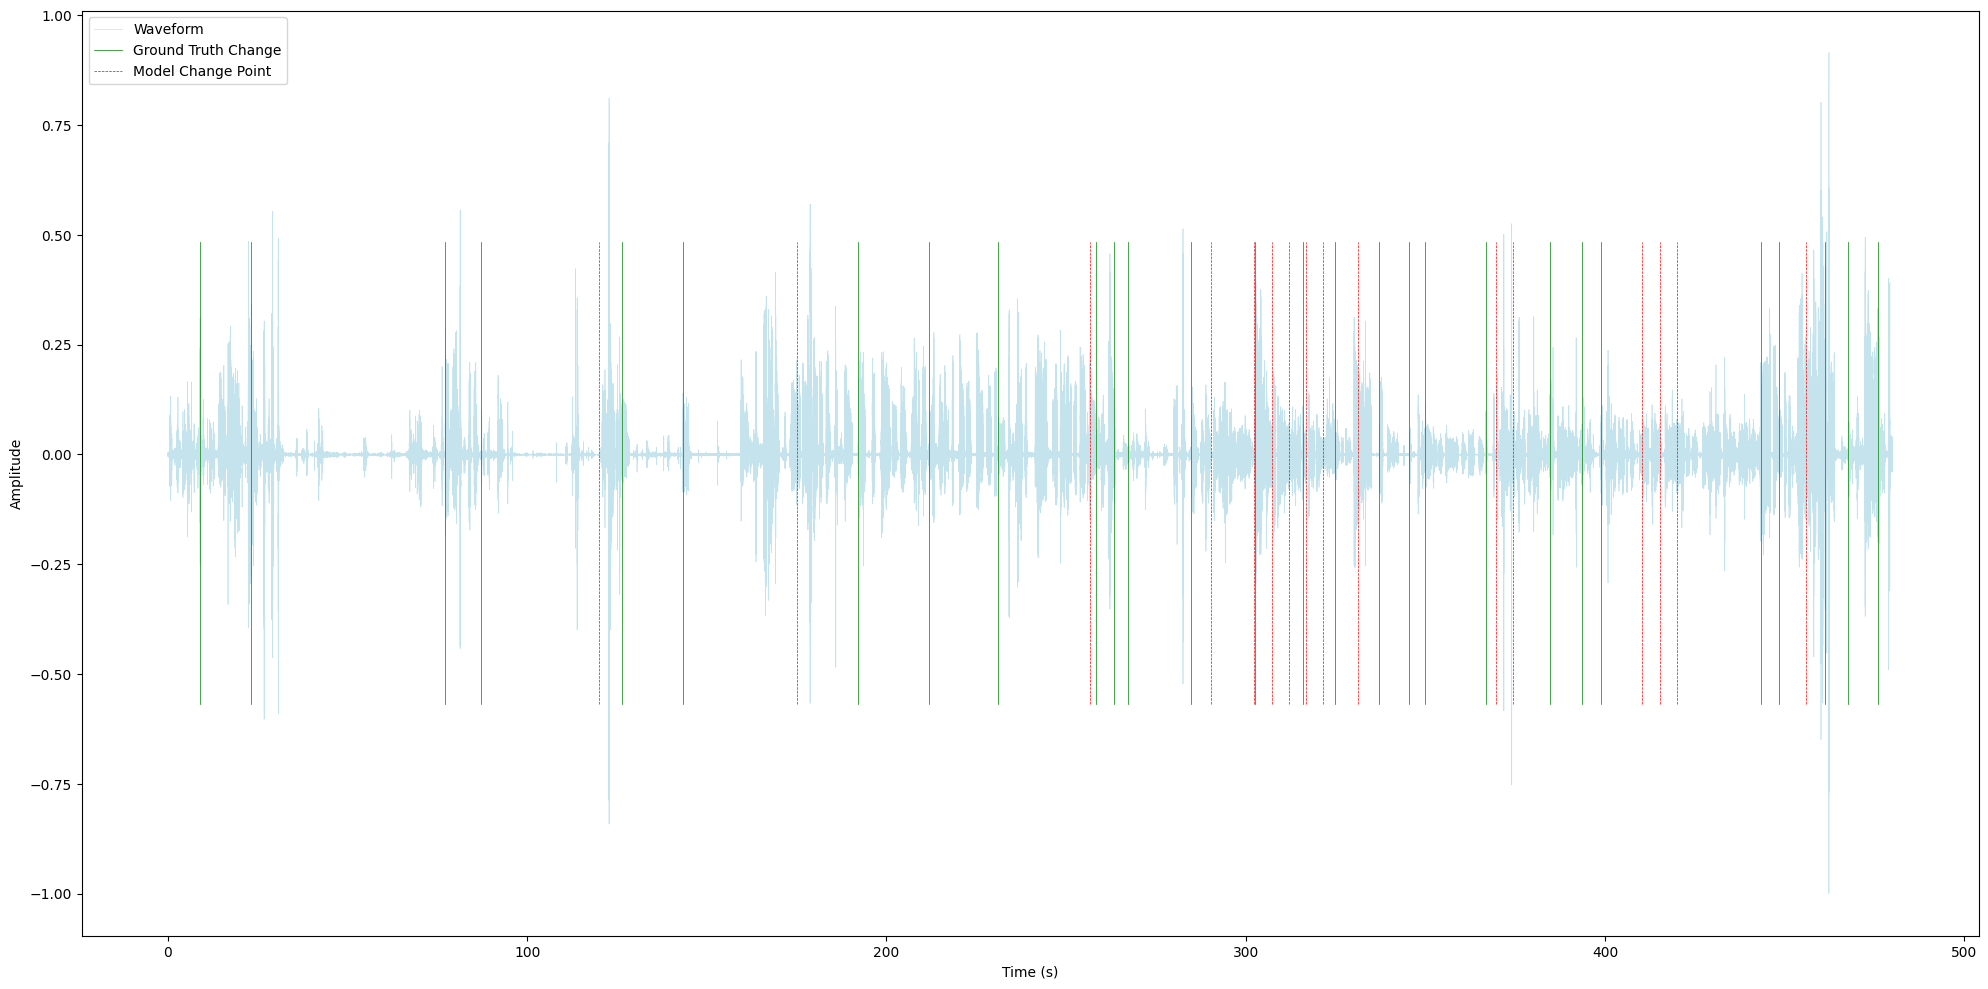

{'DER': 0.019045580997218012, 'Precision': 0.1512988866685698, 'Recall': 0.10129969418960244, 'F1': 0.12135088723526045, 'AUROC': 0.5158925519208394}
Metrics for file ES2007c.Mix-Headset generated
Metrics for file ES2007c.Mix-Headset saved in file
Speaker change detected at frame 614400
Speaker change detected at frame 652800
Speaker change detected at frame 806400
Speaker change detected at frame 844800
Speaker change detected at frame 960000
Speaker change detected at frame 1382400
Speaker change detected at frame 1420800
Speaker change detected at frame 1728000
Speaker change detected at frame 1843200
Speaker change detected at frame 1958400
Speaker change detected at frame 2265600
Speaker change detected at frame 2764800
Speaker change detected at frame 2956800
Speaker change detected at frame 3648000
Speaker change detected at frame 4300800
Speaker change detected at frame 4339200
Speaker change detected at frame 4377600
Speaker change detected at frame 4416000
Speaker change dete

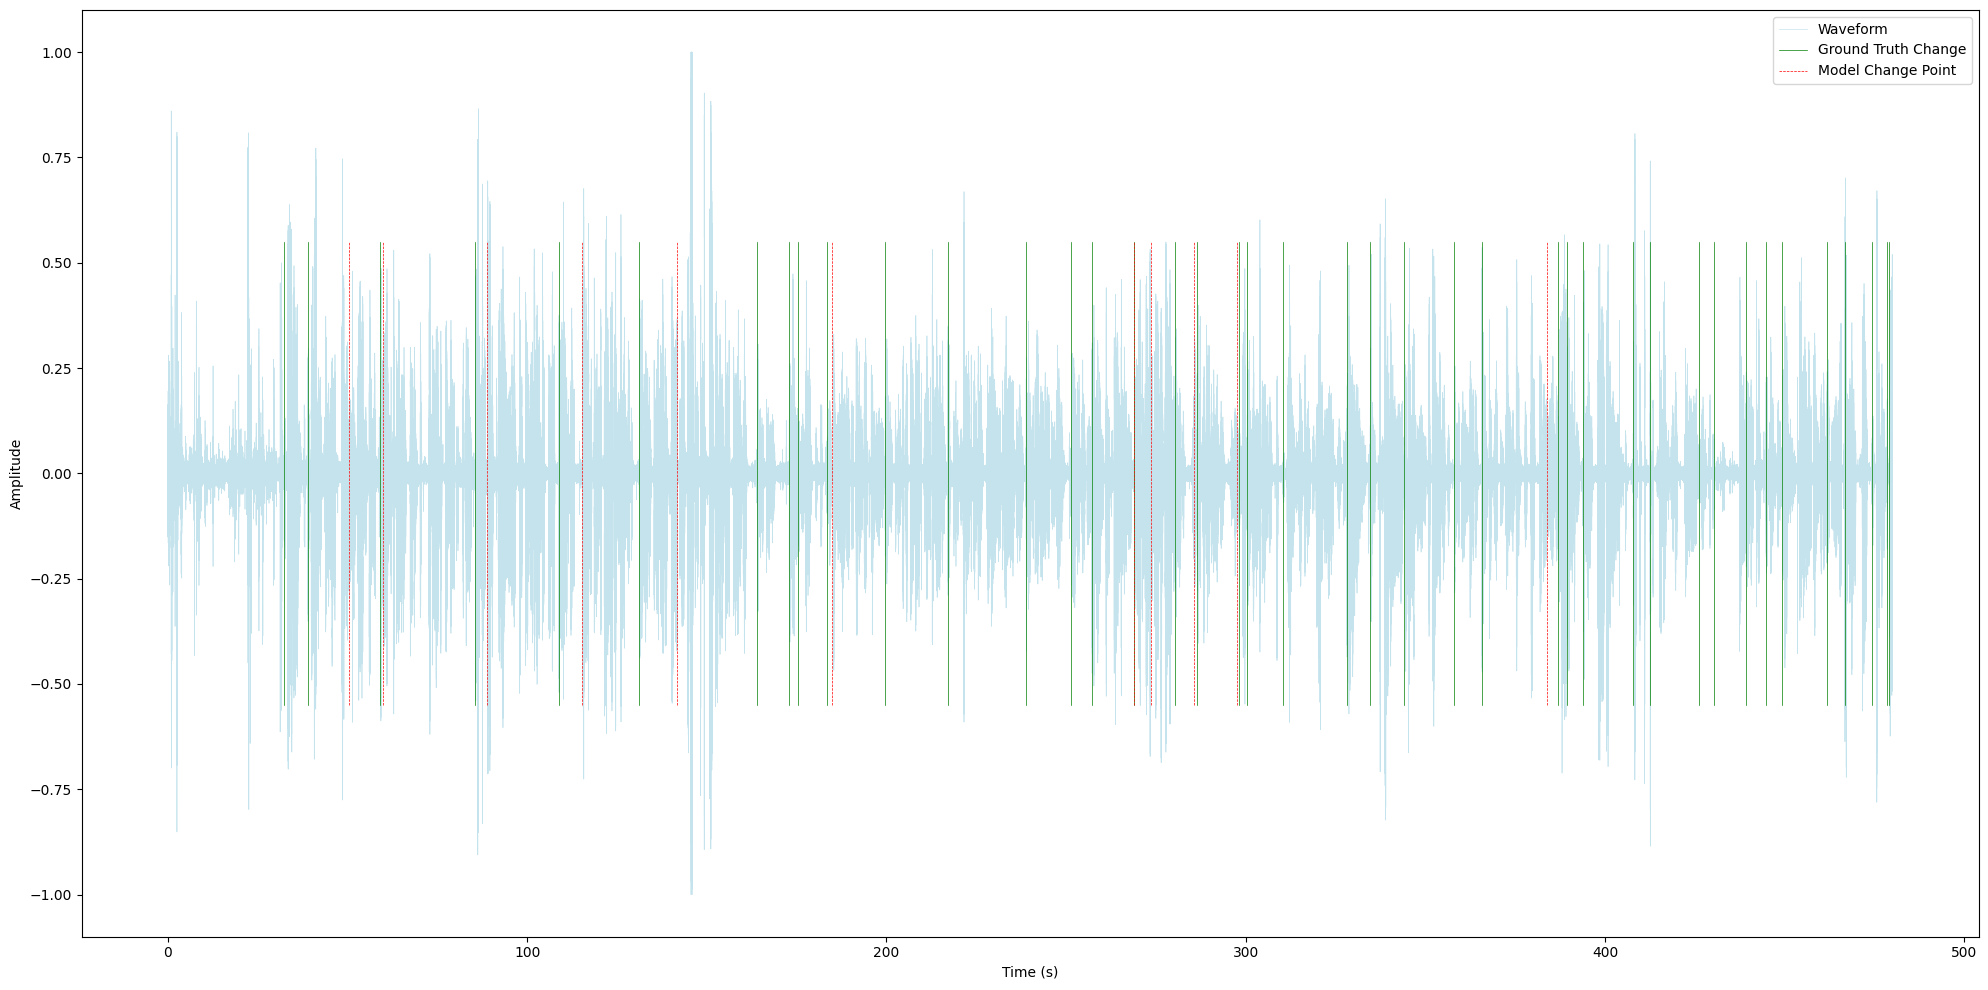

{'DER': 0.22102341406634737, 'Precision': 0.2515618492294877, 'Recall': 0.0799682245465378, 'F1': 0.12135824794052644, 'AUROC': 0.5177698565806341}
Metrics for file IS1001c.Mix-Headset generated
Metrics for file IS1001c.Mix-Headset saved in file
Speaker change detected at frame 230400
Speaker change detected at frame 268800
Speaker change detected at frame 384000
Speaker change detected at frame 768000
Speaker change detected at frame 806400
Speaker change detected at frame 844800
Speaker change detected at frame 883200
Speaker change detected at frame 998400
Speaker change detected at frame 1228800
Speaker change detected at frame 1305600
Speaker change detected at frame 1689600
Speaker change detected at frame 1920000
Speaker change detected at frame 2342400
Speaker change detected at frame 3417600
Speaker change detected at frame 3456000
Speaker change detected at frame 3494400
Speaker change detected at frame 3532800
Speaker change detected at frame 3571200
Speaker change detected 

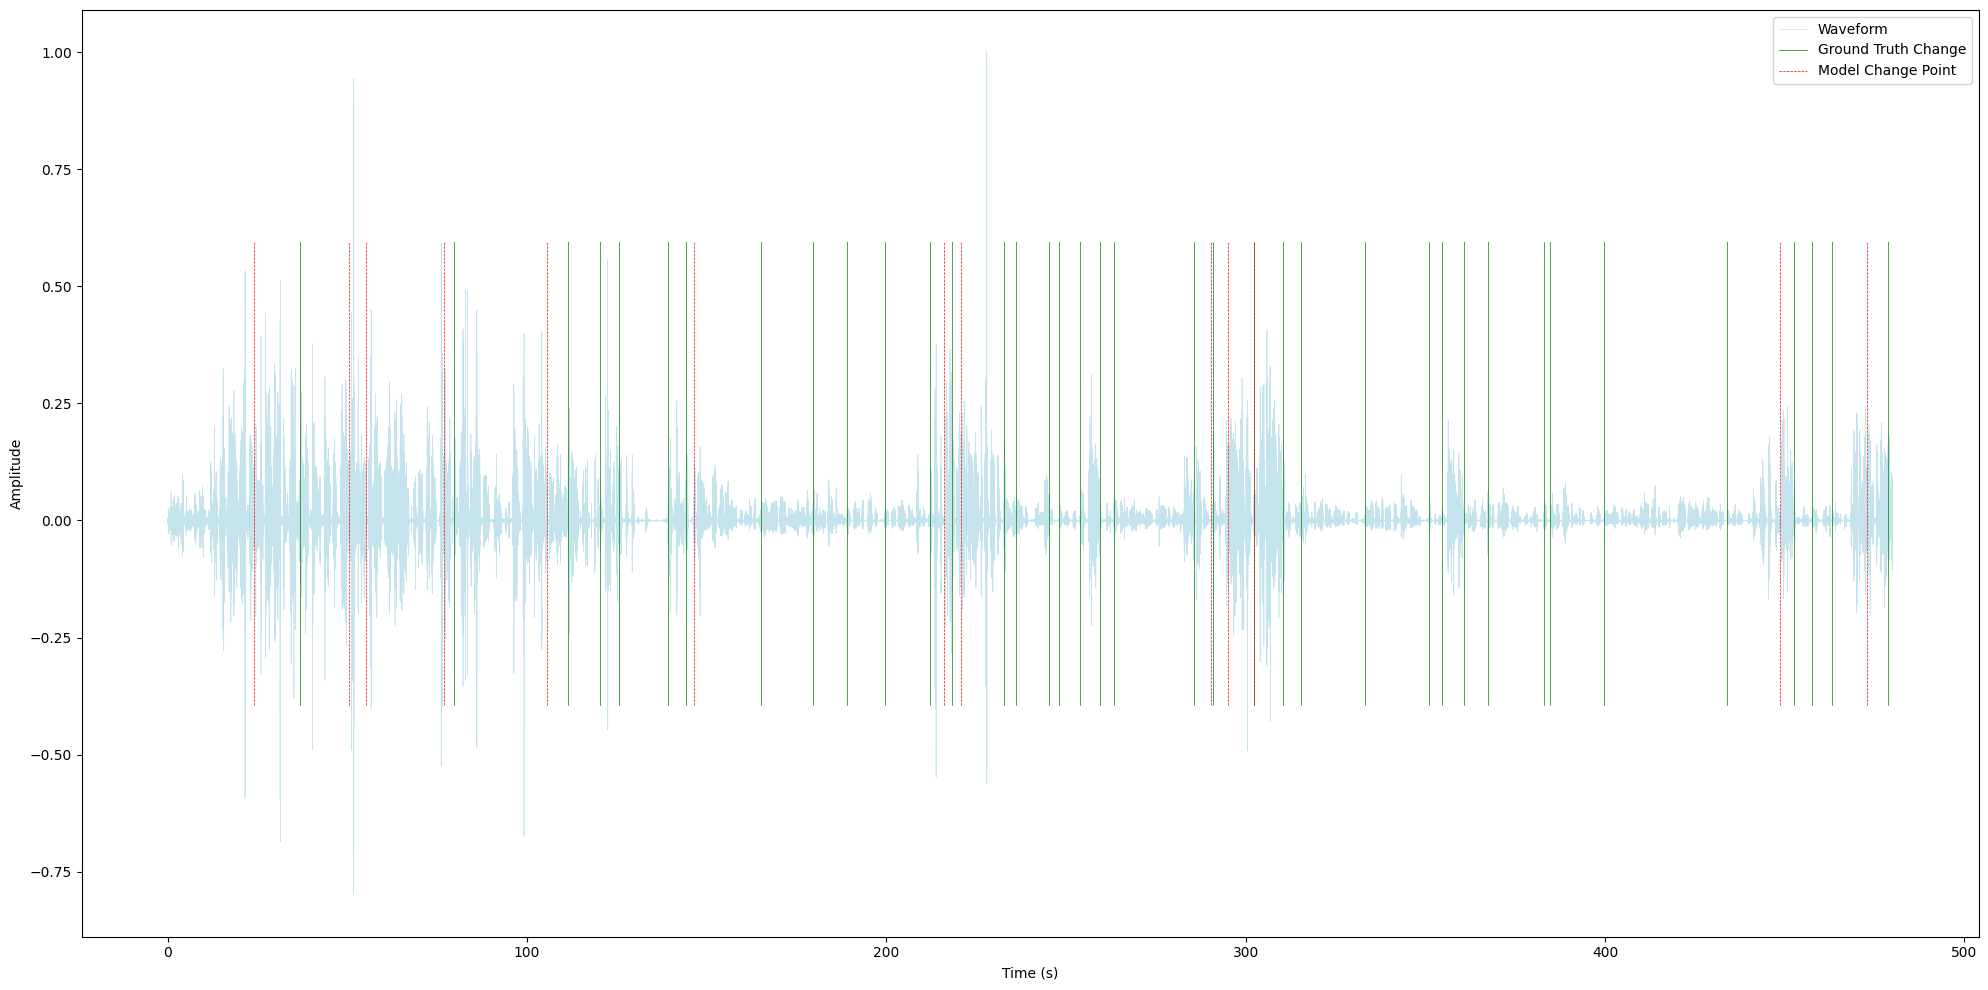

{'DER': 0.058778280542986595, 'Precision': 0.16946129147342134, 'Recall': 0.06771204561653599, 'F1': 0.09676105113057648, 'AUROC': 0.505455388429837}
Metrics for file ES2003c.Mix-Headset generated
Metrics for file ES2003c.Mix-Headset saved in file
Speaker change detected at frame 3187200
Speaker change detected at frame 3302400
Speaker change detected at frame 3340800
Speaker change detected at frame 3379200
Speaker change detected at frame 5145600
Speaker change detected at frame 5452800
Speaker change detected at frame 5491200
Speaker change detected at frame 7488000
Speaker change points: [3187200, 3302400, 3340800, 3379200, 5145600, 5452800, 5491200, 7488000]
about to calculate DER
DER calculated
DER: 0.37705677867902665
Precision: 0.1525
Recall: 0.021883408071748878
F1: 0.038274509803921566
AUROC: 0.5029511324389386
[43.94, 49.36, 57.65, 68.57, 84.43, 117.47, 151.82, 158.95, 179.49, 199.91, 211.13, 238.81, 245.34, 260.35, 269.29, 282.64, 301.71, 317.67, 328.74, 335.9, 346.45, 357.

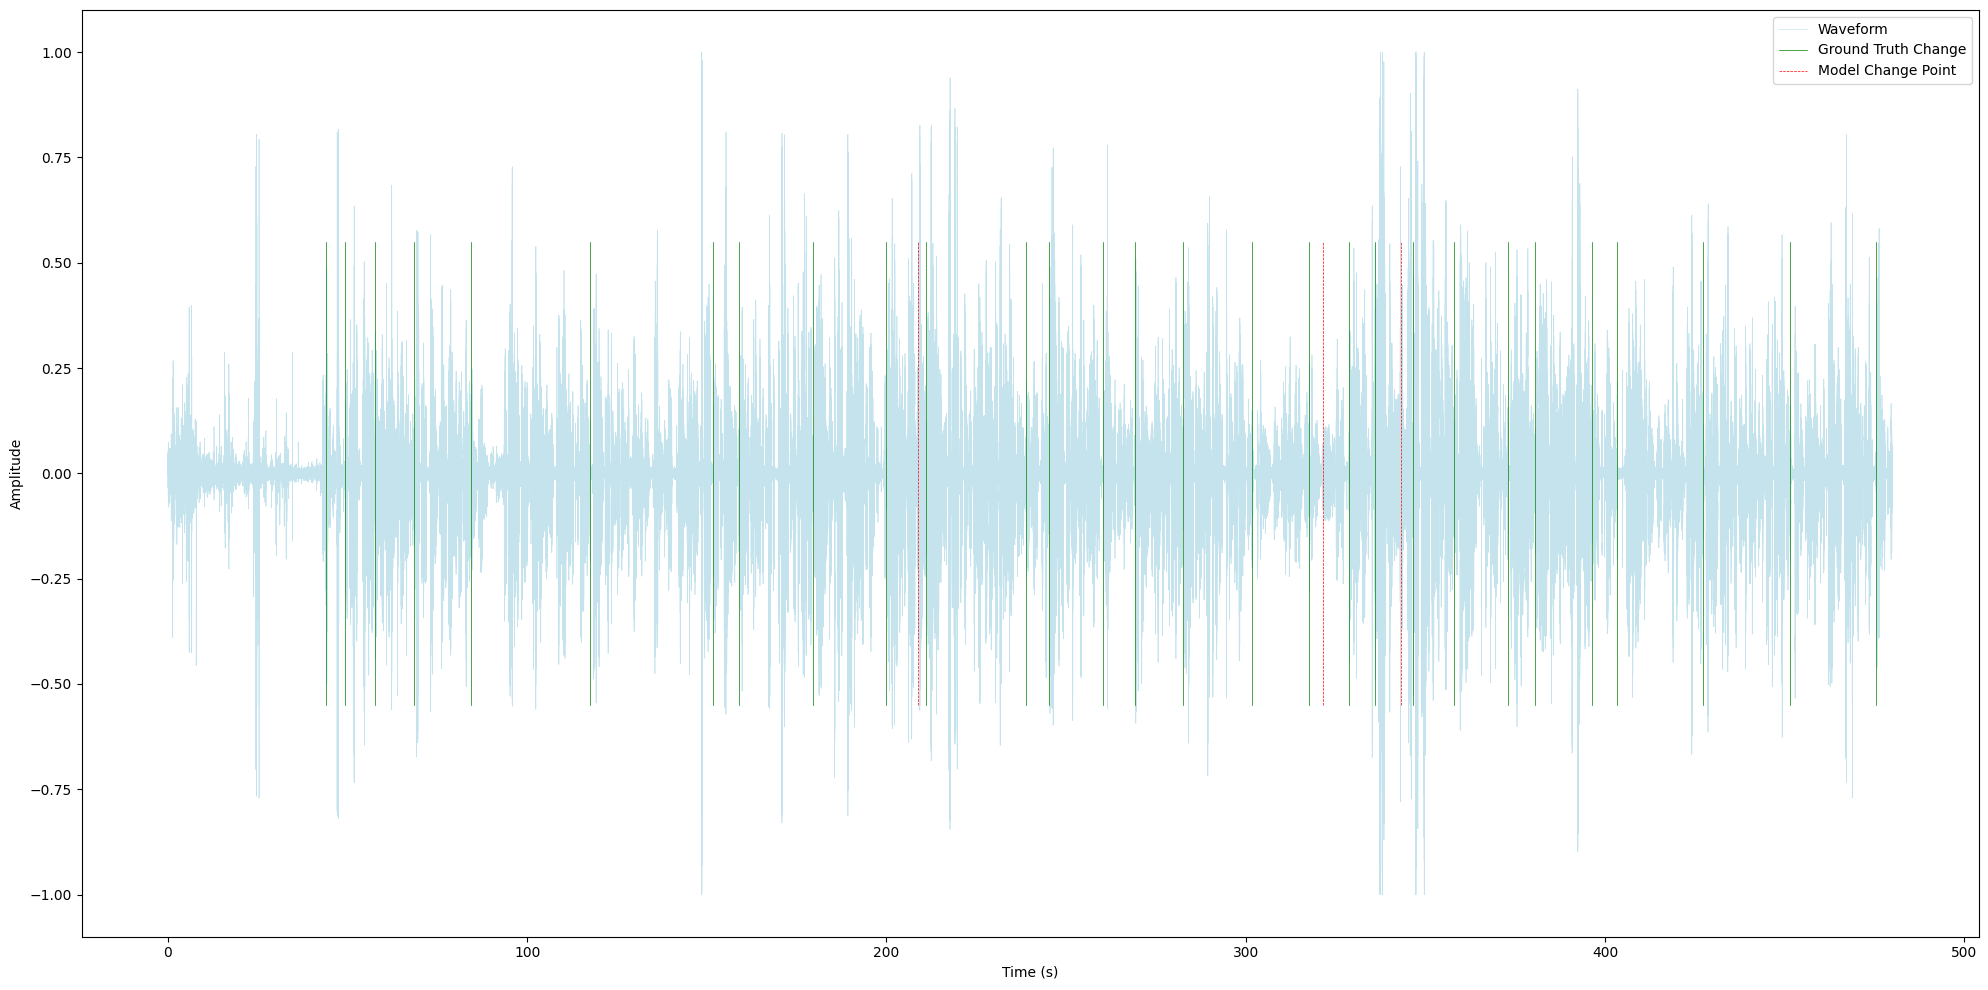

{'DER': 0.37705677867902665, 'Precision': 0.1525, 'Recall': 0.021883408071748878, 'F1': 0.038274509803921566, 'AUROC': 0.5029511324389386}
Metrics for file IN1008.Mix-Headset generated
Metrics for file IN1008.Mix-Headset saved in file
Speaker change detected at frame 345600
Speaker change detected at frame 806400
Speaker change detected at frame 844800
Speaker change detected at frame 921600
Speaker change detected at frame 960000
Speaker change detected at frame 1036800
Speaker change detected at frame 1075200
Speaker change detected at frame 1113600
Speaker change detected at frame 1420800
Speaker change detected at frame 1497600
Speaker change detected at frame 1766400
Speaker change detected at frame 1881600
Speaker change detected at frame 2188800
Speaker change detected at frame 2227200
Speaker change detected at frame 2265600
Speaker change detected at frame 2304000
Speaker change detected at frame 2803200
Speaker change detected at frame 7027200
Speaker change detected at frame

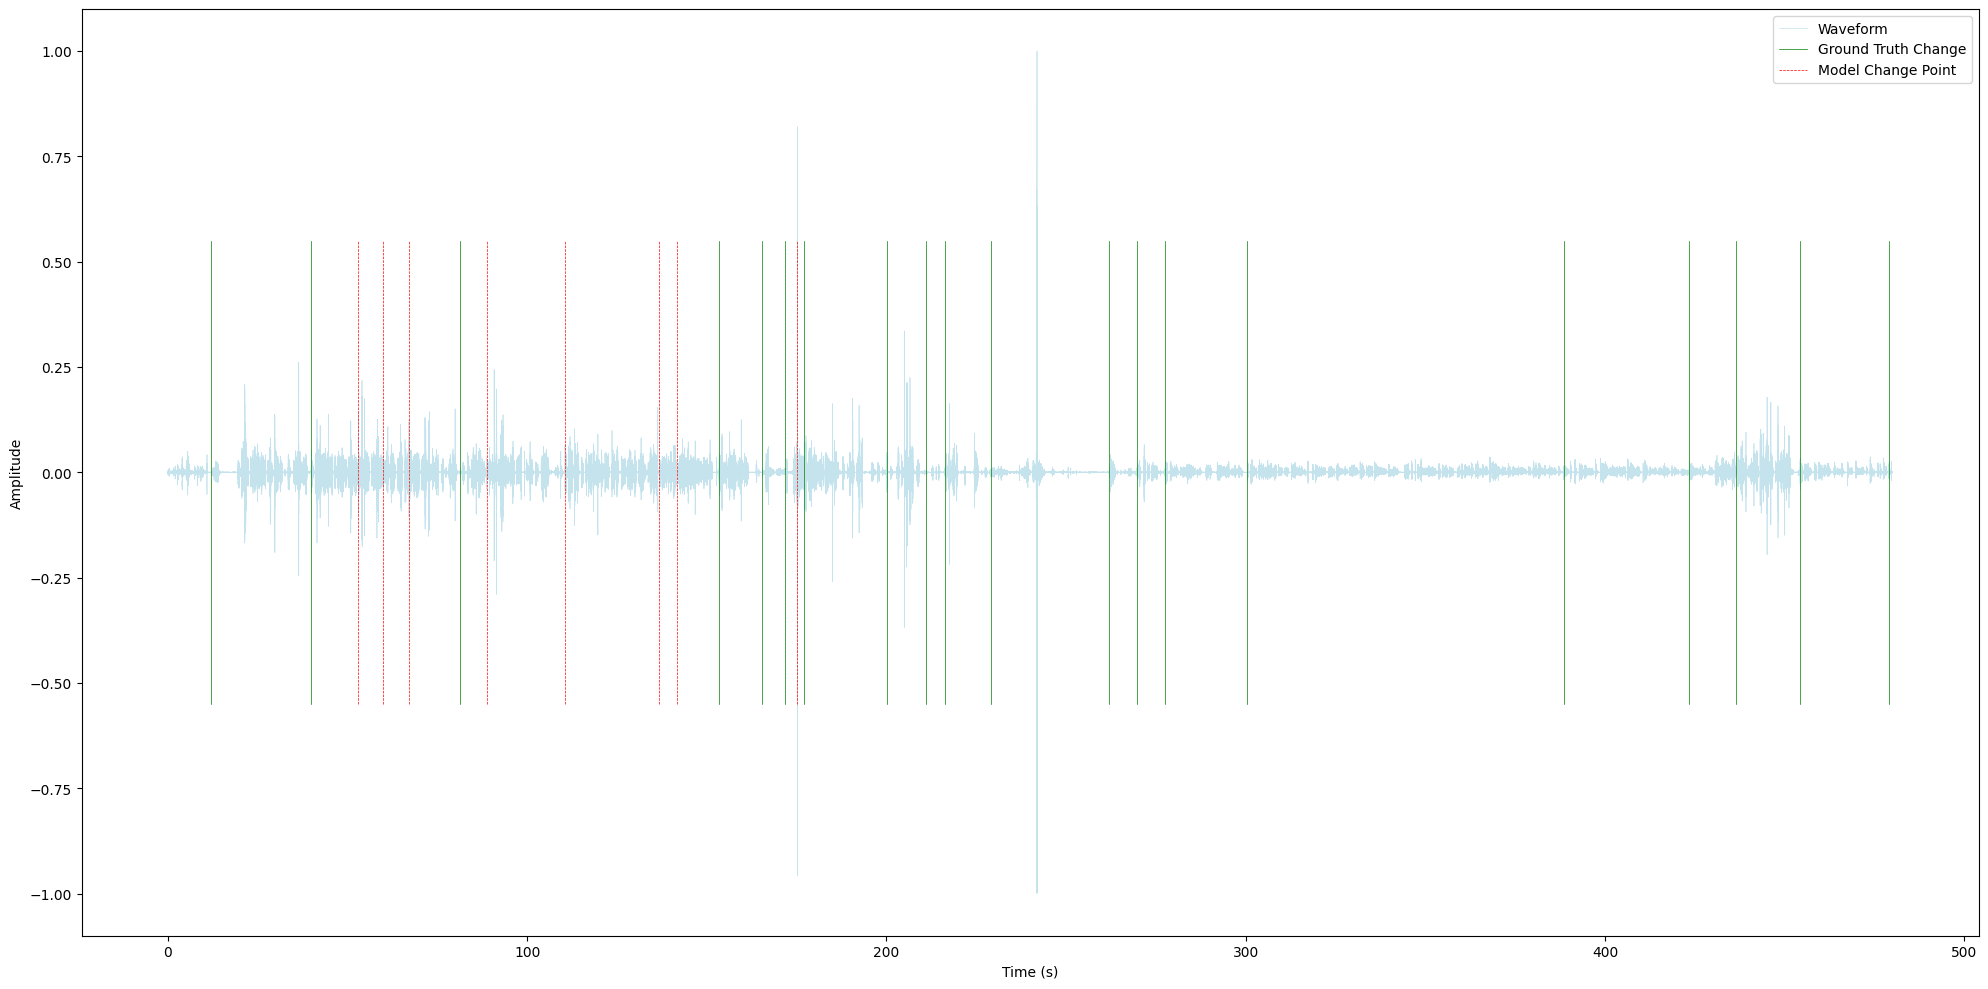

{'DER': 0.09032506745470911, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'AUROC': 0.4783819417608147}
Metrics for file ES2013b.Mix-Headset generated
Metrics for file ES2013b.Mix-Headset saved in file
Speaker change detected at frame 3955200
Speaker change detected at frame 3993600
Speaker change detected at frame 4108800
Speaker change detected at frame 4147200
Speaker change detected at frame 4185600
Speaker change detected at frame 4339200
Speaker change detected at frame 4377600
Speaker change detected at frame 4531200
Speaker change detected at frame 4569600
Speaker change detected at frame 4608000
Speaker change detected at frame 4646400
Speaker change detected at frame 4684800
Speaker change detected at frame 4723200
Speaker change detected at frame 4761600
Speaker change detected at frame 4876800
Speaker change detected at frame 4915200
Speaker change detected at frame 4992000
Speaker change detected at frame 5030400
Speaker change detected at frame 5068800
Speaker change detect

{'DER': 0.12553488963267356, 'Precision': 0.27873693775556563, 'Recall': 0.2645536869340233, 'F1': 0.2714601769911504, 'AUROC': 0.5956664472675743}
Metrics for file TS3011d.Mix-Headset generated
Metrics for file TS3011d.Mix-Headset saved in file
Speaker change detected at frame 1113600
Speaker change detected at frame 2342400
Speaker change detected at frame 3686400
Speaker change detected at frame 3724800
Speaker change detected at frame 3878400
Speaker change detected at frame 3916800
Speaker change detected at frame 4032000
Speaker change detected at frame 4992000
Speaker change detected at frame 5376000
Speaker change detected at frame 5414400
Speaker change detected at frame 5990400
Speaker change detected at frame 6028800
Speaker change detected at frame 6067200
Speaker change detected at frame 6105600
Speaker change detected at frame 6144000
Speaker change detected at frame 6374400
Speaker change detected at frame 6528000
Speaker change detected at frame 6566400
Speaker change d

{'DER': 0.17247011319556288, 'Precision': 0.15659209900047596, 'Recall': 0.056930264751687144, 'F1': 0.083502538071066, 'AUROC': 0.5074803143942704}
Metrics for file ES2016a.Mix-Headset generated
Metrics for file ES2016a.Mix-Headset saved in file
Speaker change detected at frame 0
Speaker change detected at frame 38400
Speaker change detected at frame 115200
Speaker change detected at frame 345600
Speaker change detected at frame 384000
Speaker change detected at frame 537600
Speaker change detected at frame 576000
Speaker change detected at frame 652800
Speaker change detected at frame 691200
Speaker change detected at frame 806400
Speaker change detected at frame 1036800
Speaker change detected at frame 1075200
Speaker change detected at frame 1804800
Speaker change detected at frame 2150400
Speaker change detected at frame 2227200
Speaker change detected at frame 2342400
Speaker change detected at frame 2380800
Speaker change detected at frame 2419200
Speaker change detected at fram

{'DER': 0.5484154010069567, 'Precision': 0.04298740772904907, 'Recall': 0.01795755487030655, 'F1': 0.025332650972364385, 'AUROC': 0.48304143189416426}
Metrics for file EN2001e.Mix-Headset generated
Metrics for file EN2001e.Mix-Headset saved in file
Speaker change detected at frame 2150400
Speaker change detected at frame 4108800
Speaker change detected at frame 4262400
Speaker change detected at frame 4377600
Speaker change detected at frame 4646400
Speaker change detected at frame 4684800
Speaker change detected at frame 4800000
Speaker change detected at frame 5414400
Speaker change detected at frame 5452800
Speaker change detected at frame 5491200
Speaker change detected at frame 5529600
Speaker change detected at frame 5568000
Speaker change detected at frame 5606400
Speaker change detected at frame 5875200
Speaker change detected at frame 6912000
Speaker change detected at frame 7219200
Speaker change detected at frame 7603200
Speaker change points: [2150400, 4108800, 4262400, 437

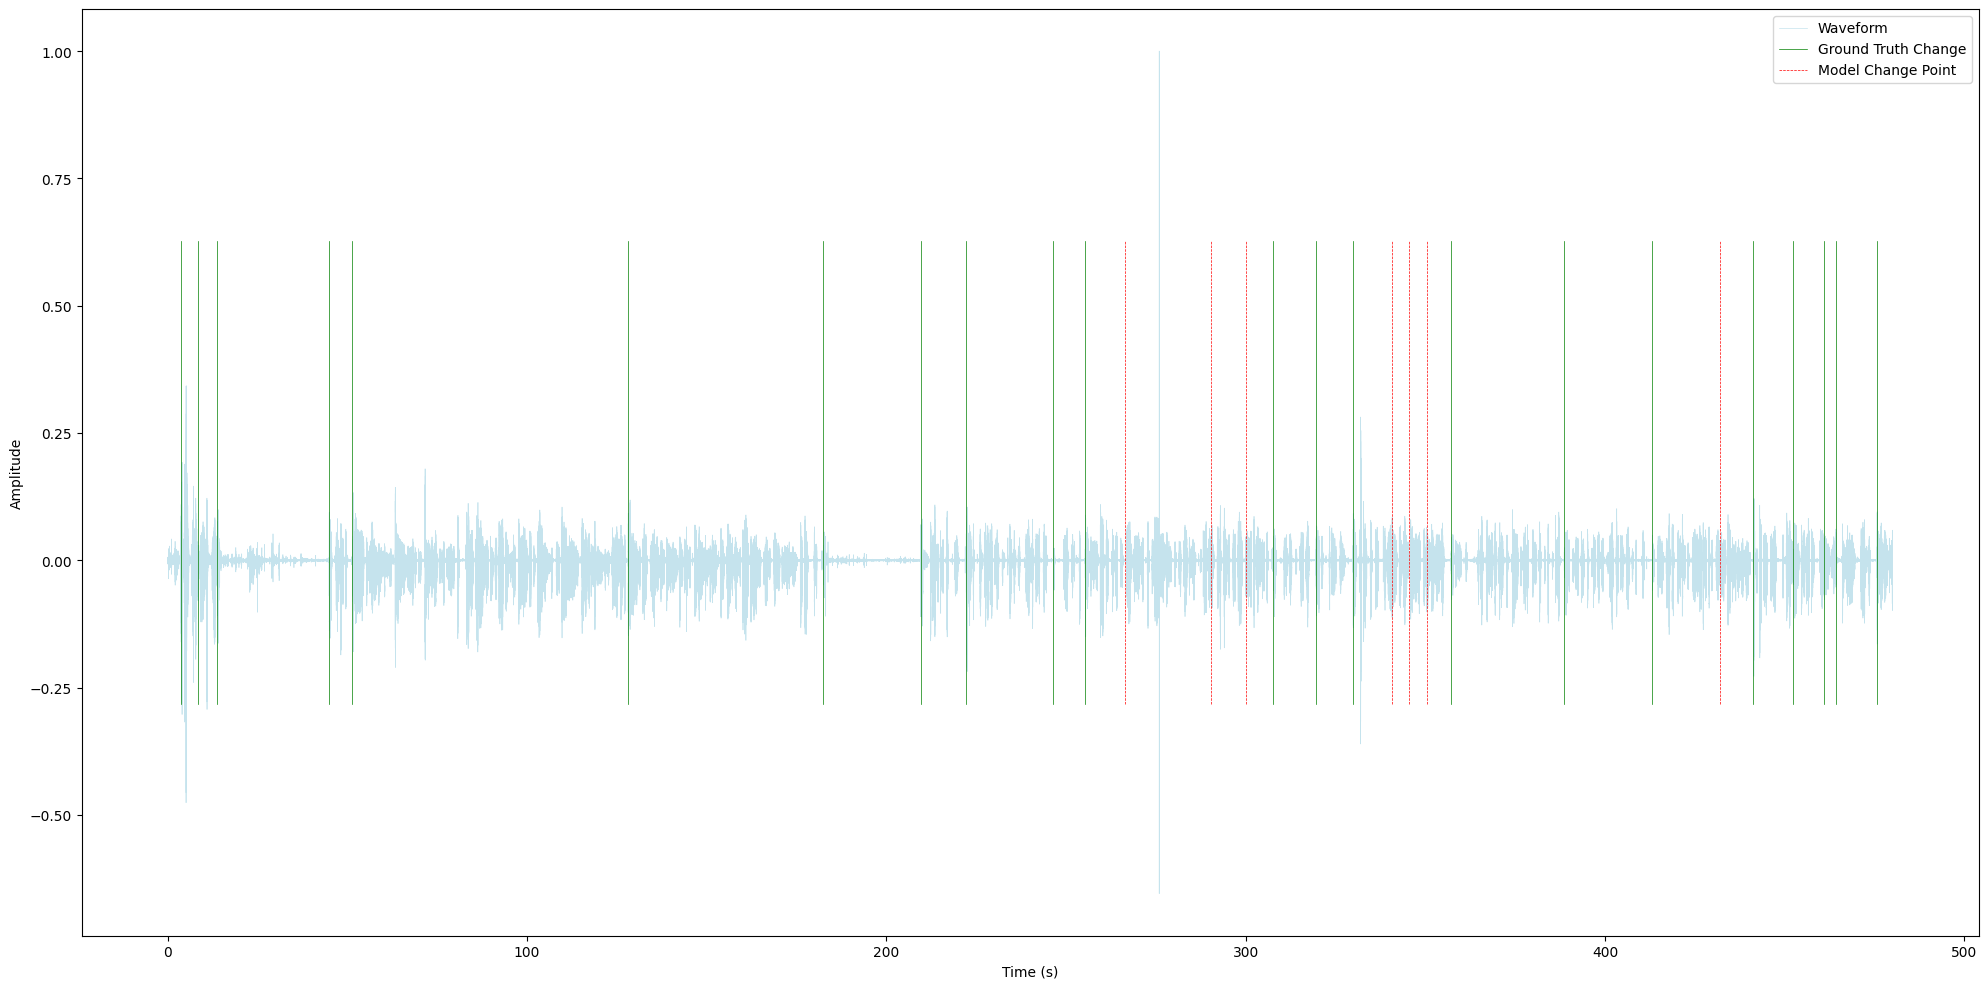

{'DER': 0.27808845958312167, 'Precision': 0.0863689776733255, 'Recall': 0.03337874659400545, 'F1': 0.04814936128398297, 'AUROC': 0.4988551683240694}
Metrics for file TS3007b.Mix-Headset generated
Metrics for file TS3007b.Mix-Headset saved in file
Speaker change detected at frame 1382400
Speaker change detected at frame 3532800
Speaker change detected at frame 4147200
Speaker change detected at frame 4185600
Speaker change detected at frame 4492800
Speaker change detected at frame 5491200
Speaker change detected at frame 5529600
Speaker change detected at frame 5606400
Speaker change detected at frame 5644800
Speaker change detected at frame 5683200
Speaker change detected at frame 5721600
Speaker change detected at frame 5760000
Speaker change detected at frame 5798400
Speaker change detected at frame 5836800
Speaker change detected at frame 5875200
Speaker change detected at frame 5913600
Speaker change detected at frame 5952000
Speaker change detected at frame 6412800
Speaker change 

{'DER': 0.14592623508995453, 'Precision': 0.396, 'Recall': 0.14936632468316235, 'F1': 0.2169149868536372, 'AUROC': 0.5564341050081187}
Metrics for file IS1001a.Mix-Headset generated
Metrics for file IS1001a.Mix-Headset saved in file
Speaker change detected at frame 1152000
Speaker change detected at frame 1190400
Speaker change detected at frame 1267200
Speaker change detected at frame 1382400
Speaker change detected at frame 1651200
Speaker change detected at frame 1728000
Speaker change detected at frame 1766400
Speaker change detected at frame 1804800
Speaker change detected at frame 1958400
Speaker change detected at frame 2803200
Speaker change detected at frame 4185600
Speaker change detected at frame 5184000
Speaker change detected at frame 5222400
Speaker change detected at frame 5721600
Speaker change detected at frame 6105600
Speaker change detected at frame 6336000
Speaker change detected at frame 6374400
Speaker change detected at frame 6412800
Speaker change detected at fr

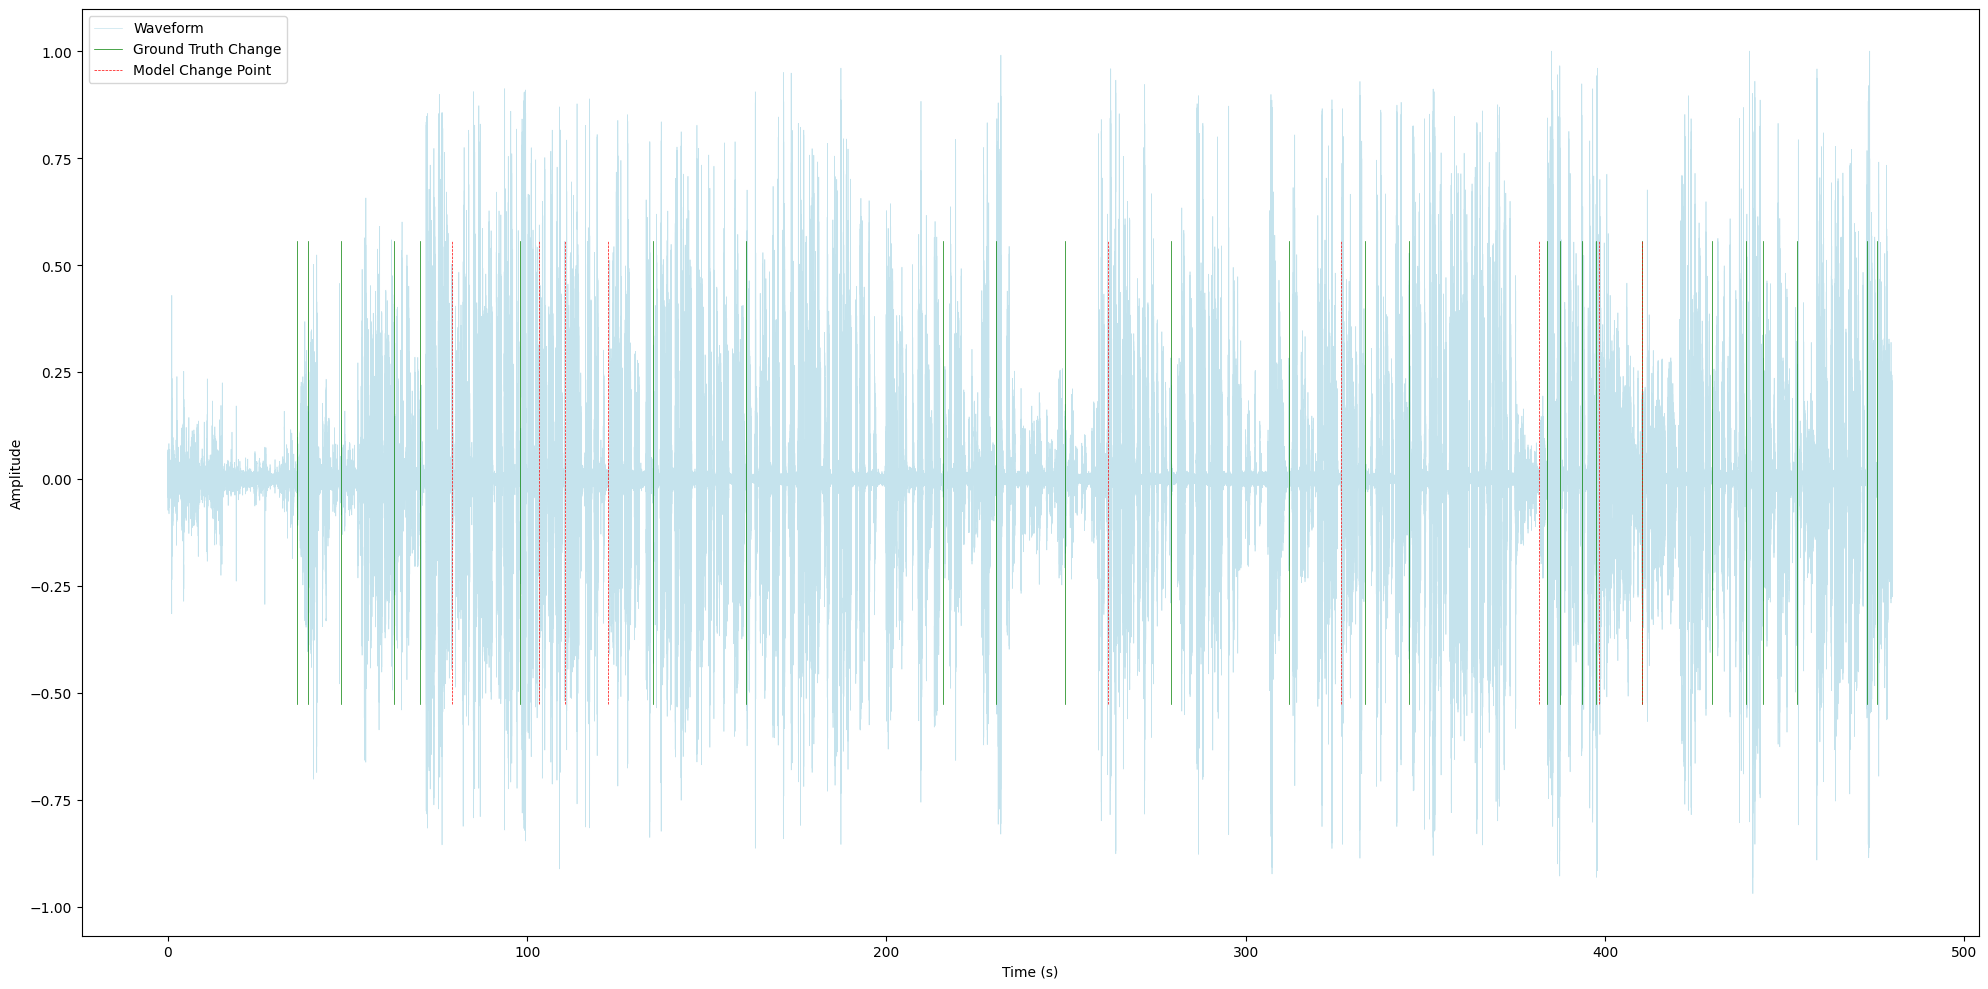

{'DER': 0.12673686125577063, 'Precision': 0.059019514516896715, 'Recall': 0.02438544739429695, 'F1': 0.03451155023657111, 'AUROC': 0.48915881946785805}
Metrics for file IN1005.Mix-Headset generated
Metrics for file IN1005.Mix-Headset saved in file
Speaker change points: []
Error generating results for file pair (/home/rahul/Documents/test_data_trimmed/trimmed_EN2001a.Mix-Headset.wav, /home/rahul/Documents/test_data_trimmed/trimmed_EN2001a.rttm): list index out of range
Speaker change detected at frame 1804800
Speaker change detected at frame 2035200
Speaker change detected at frame 3456000
Speaker change detected at frame 3494400
Speaker change detected at frame 3532800
Speaker change detected at frame 3571200
Speaker change detected at frame 4224000
Speaker change detected at frame 4262400
Speaker change detected at frame 4492800
Speaker change detected at frame 4684800
Speaker change detected at frame 5376000
Speaker change detected at frame 5452800
Speaker change detected at frame 5

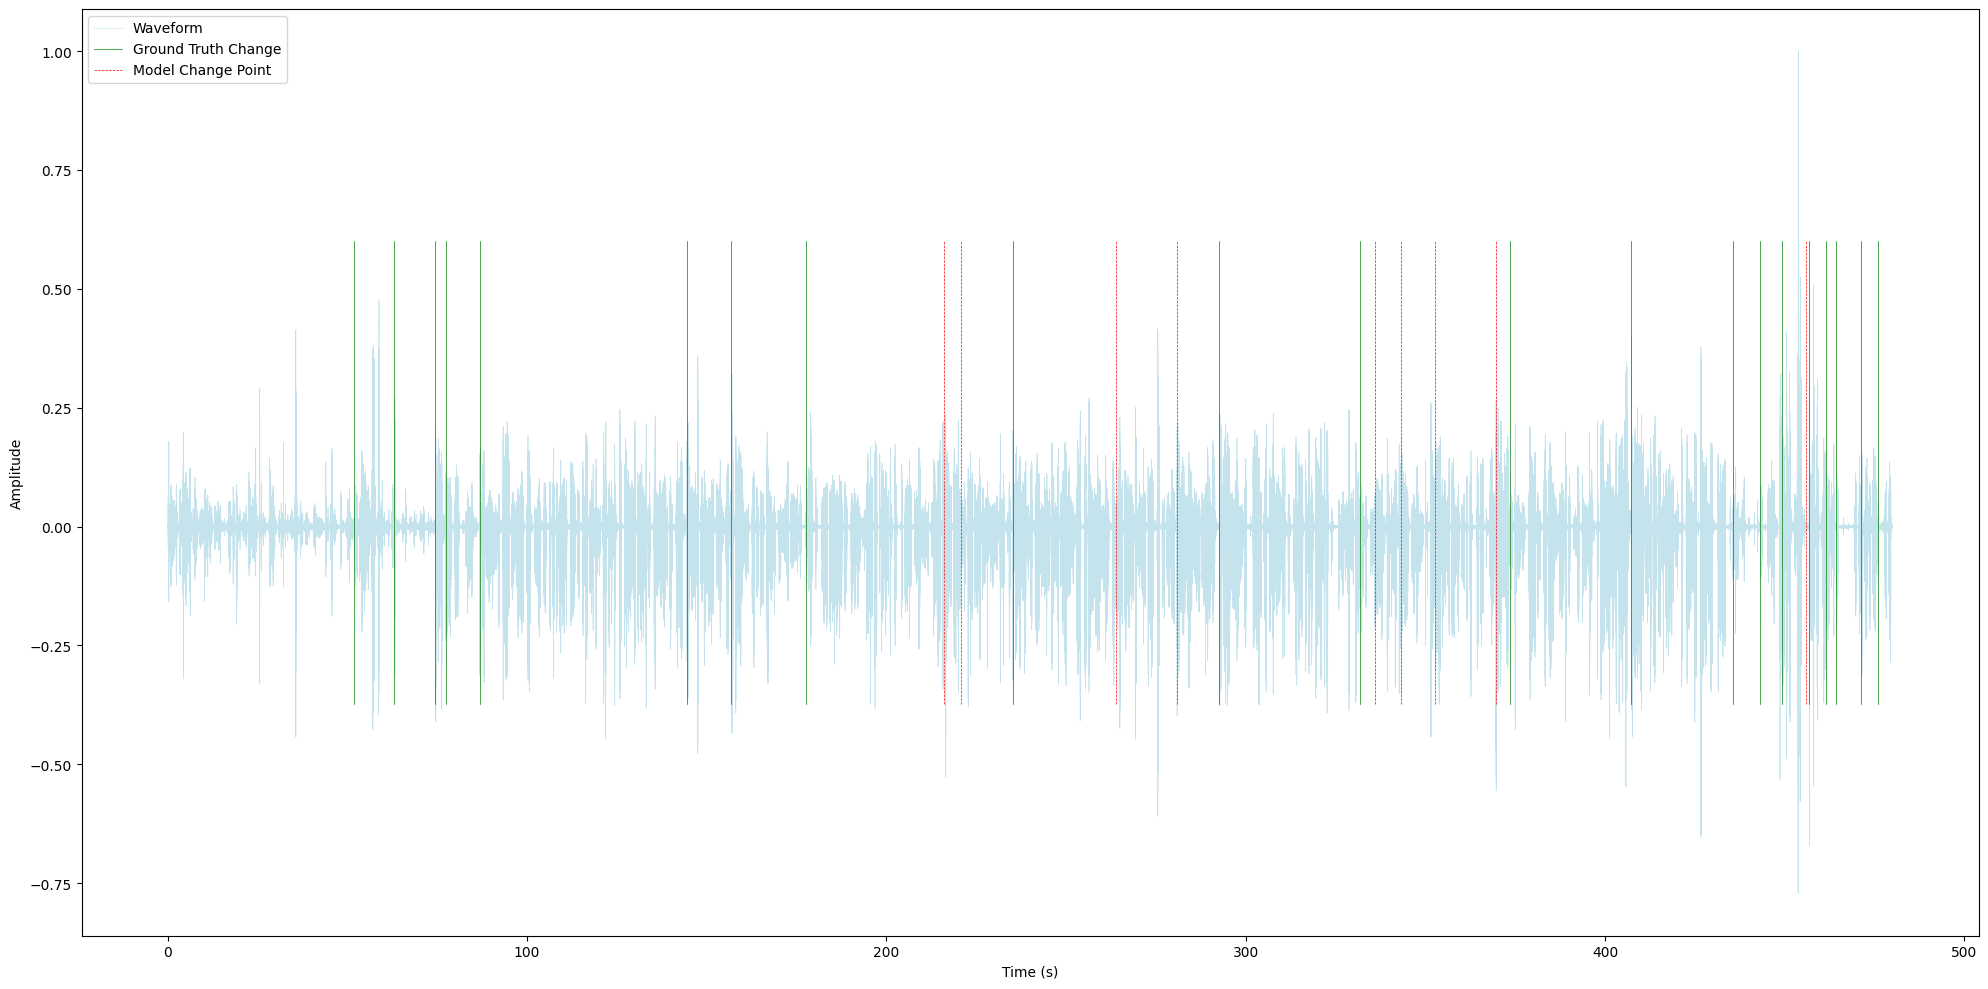

{'DER': 0.18504020562642967, 'Precision': 0.11644177911044477, 'Recall': 0.056732408083759435, 'F1': 0.07629338572364112, 'AUROC': 0.5082263184109135}
Metrics for file TS3005a.Mix-Headset generated
Metrics for file TS3005a.Mix-Headset saved in file
Speaker change detected at frame 2841600
Speaker change detected at frame 2995200
Speaker change detected at frame 3225600
Speaker change detected at frame 3417600
Speaker change detected at frame 3456000
Speaker change detected at frame 3648000
Speaker change detected at frame 3724800
Speaker change detected at frame 3763200
Speaker change detected at frame 3801600
Speaker change detected at frame 4262400
Speaker change detected at frame 4300800
Speaker change detected at frame 4339200
Speaker change detected at frame 4377600
Speaker change detected at frame 4416000
Speaker change detected at frame 4454400
Speaker change detected at frame 4800000
Speaker change detected at frame 4838400
Speaker change detected at frame 5030400
Speaker chang

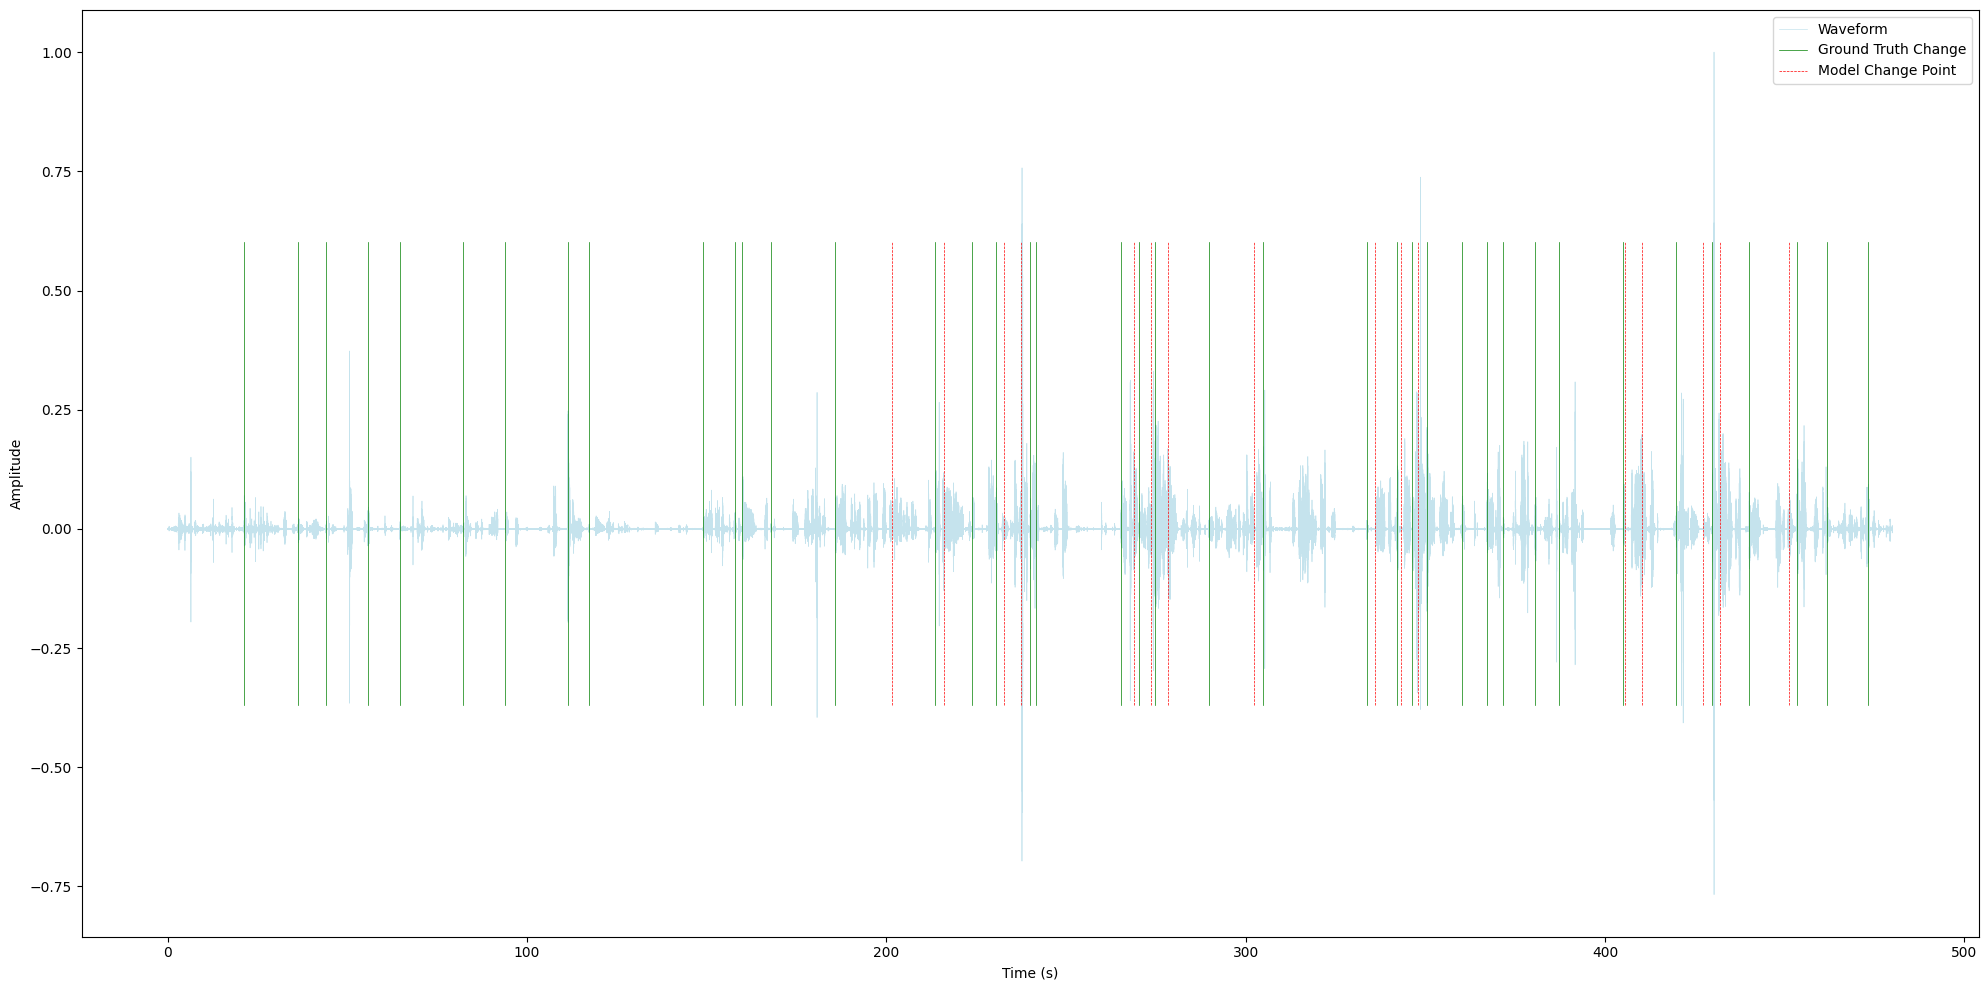

{'DER': 0.3893670213942786, 'Precision': 0.2464747356051704, 'Recall': 0.1082860092927207, 'F1': 0.15046628407460544, 'AUROC': 0.5222812338026755}
Metrics for file ES2007a.Mix-Headset generated
Metrics for file ES2007a.Mix-Headset saved in file
Speaker change detected at frame 2880000
Speaker change detected at frame 2918400
Speaker change detected at frame 3072000
Speaker change detected at frame 3532800
Speaker change detected at frame 3724800
Speaker change detected at frame 4070400
Speaker change detected at frame 4108800
Speaker change detected at frame 4377600
Speaker change detected at frame 4416000
Speaker change detected at frame 4915200
Speaker change detected at frame 5145600
Speaker change detected at frame 5299200
Speaker change detected at frame 5414400
Speaker change detected at frame 5875200
Speaker change detected at frame 5913600
Speaker change detected at frame 5952000
Speaker change detected at frame 6528000
Speaker change detected at frame 6566400
Speaker change po

{'DER': 0.5077448990492469, 'Precision': 0.34, 'Recall': 0.056499261447562774, 'F1': 0.09689677010766308, 'AUROC': 0.5122681412704883}
Metrics for file TS3006d.Mix-Headset generated
Metrics for file TS3006d.Mix-Headset saved in file
Speaker change detected at frame 921600
Speaker change detected at frame 960000
Speaker change detected at frame 998400
Speaker change detected at frame 1036800
Speaker change detected at frame 1075200
Speaker change detected at frame 1113600
Speaker change detected at frame 1152000
Speaker change detected at frame 1574400
Speaker change detected at frame 1689600
Speaker change detected at frame 2112000
Speaker change detected at frame 2227200
Speaker change detected at frame 2265600
Speaker change detected at frame 2342400
Speaker change detected at frame 2572800
Speaker change detected at frame 2611200
Speaker change detected at frame 2649600
Speaker change detected at frame 2688000
Speaker change detected at frame 3187200
Speaker change detected at frame

{'DER': 0.04976849046083739, 'Precision': 0.14856692085195897, 'Recall': 0.12018719421399703, 'F1': 0.13287864534336782, 'AUROC': 0.5227024333387821}
Metrics for file IS1005a.Mix-Headset generated
Metrics for file IS1005a.Mix-Headset saved in file
Speaker change detected at frame 4416000
Speaker change points: [4416000]
Error generating results for file pair (/home/rahul/Documents/test_data_trimmed/trimmed_ES2009b.Mix-Headset.wav, /home/rahul/Documents/test_data_trimmed/trimmed_ES2009b.rttm): list index out of range
Speaker change detected at frame 2995200
Speaker change detected at frame 3033600
Speaker change detected at frame 4876800
Speaker change detected at frame 5644800
Speaker change detected at frame 5683200
Speaker change detected at frame 5721600
Speaker change detected at frame 5760000
Speaker change detected at frame 5836800
Speaker change detected at frame 5875200
Speaker change detected at frame 6528000
Speaker change detected at frame 6950400
Speaker change detected at 

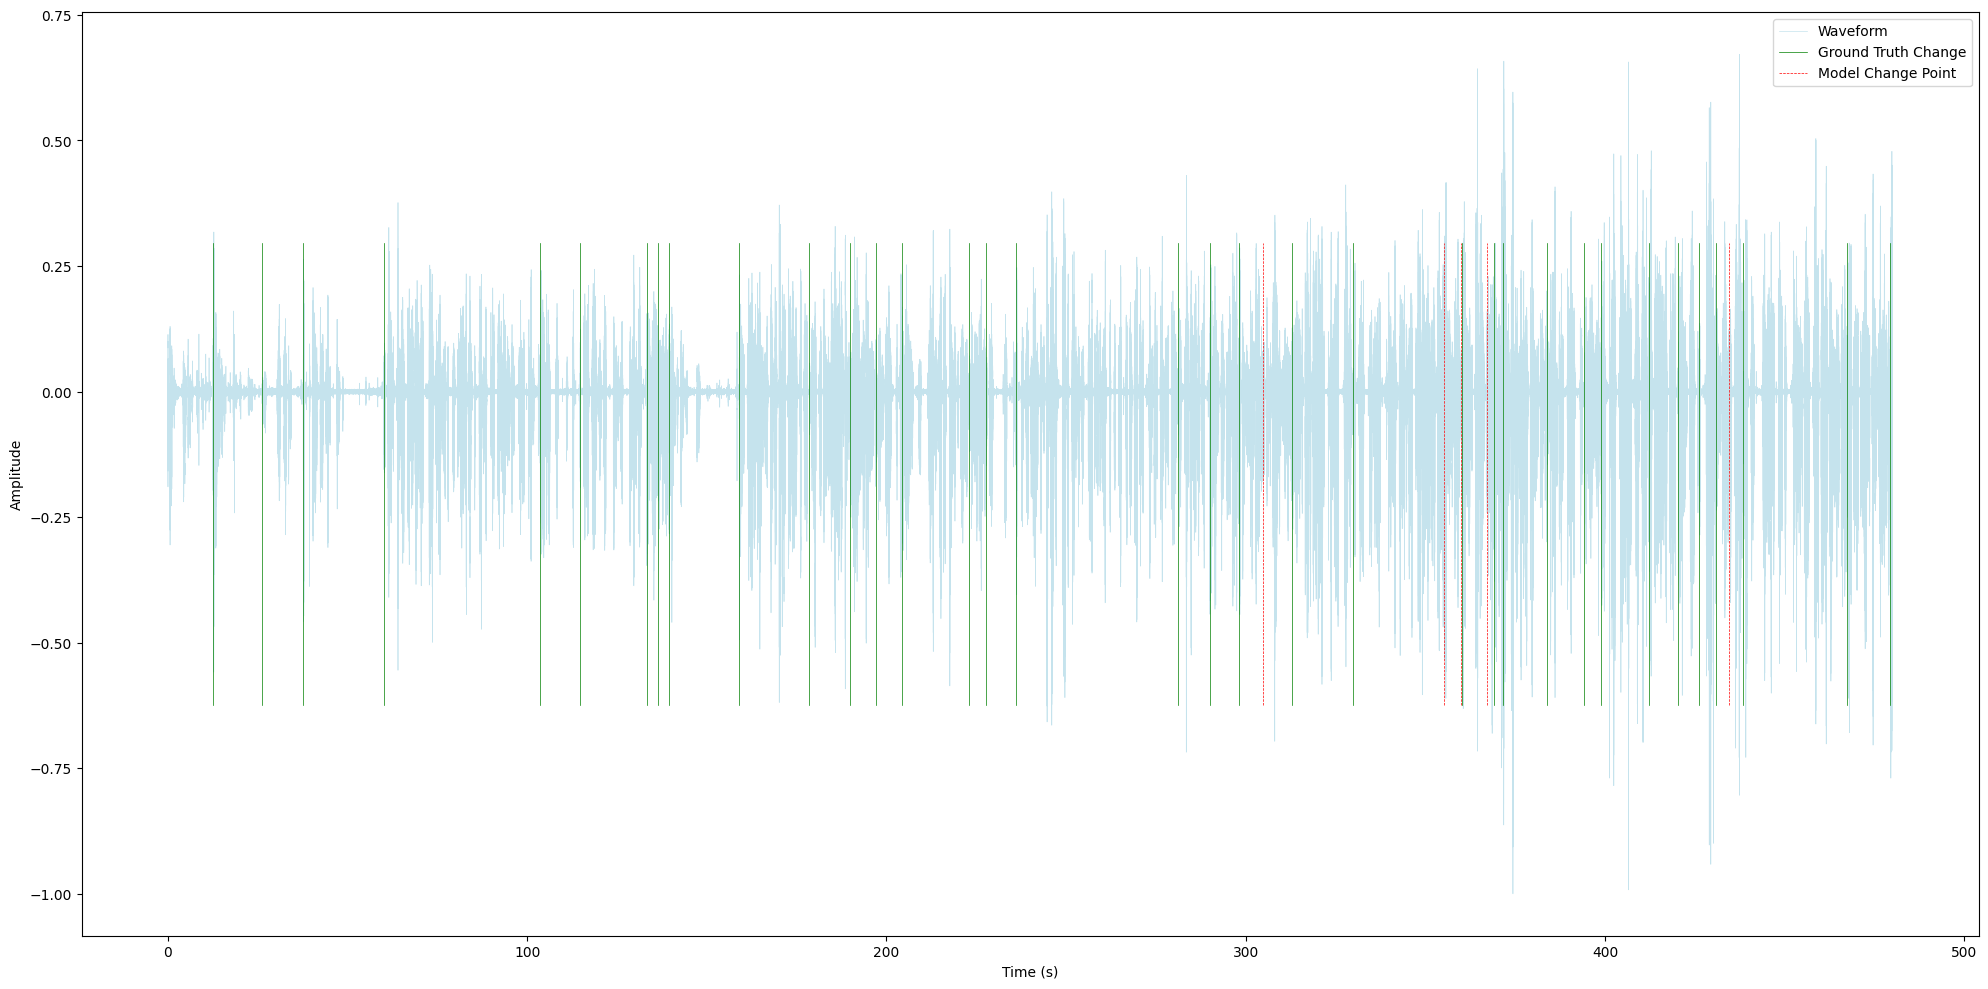

{'DER': 0.4191226867717615, 'Precision': 0.1275, 'Recall': 0.0211999445753083, 'F1': 0.03635499584174884, 'AUROC': 0.49776374150522035}
Metrics for file TS3012d.Mix-Headset generated
Metrics for file TS3012d.Mix-Headset saved in file
Speaker change detected at frame 1075200
Speaker change detected at frame 1113600
Speaker change detected at frame 1190400
Speaker change detected at frame 1497600
Speaker change detected at frame 2304000
Speaker change detected at frame 3187200
Speaker change detected at frame 3225600
Speaker change detected at frame 3417600
Speaker change detected at frame 3532800
Speaker change detected at frame 3571200
Speaker change detected at frame 3686400
Speaker change detected at frame 3724800
Speaker change detected at frame 3763200
Speaker change detected at frame 4108800
Speaker change detected at frame 5260800
Speaker change detected at frame 5299200
Speaker change detected at frame 5337600
Speaker change detected at frame 6336000
Speaker change detected at f

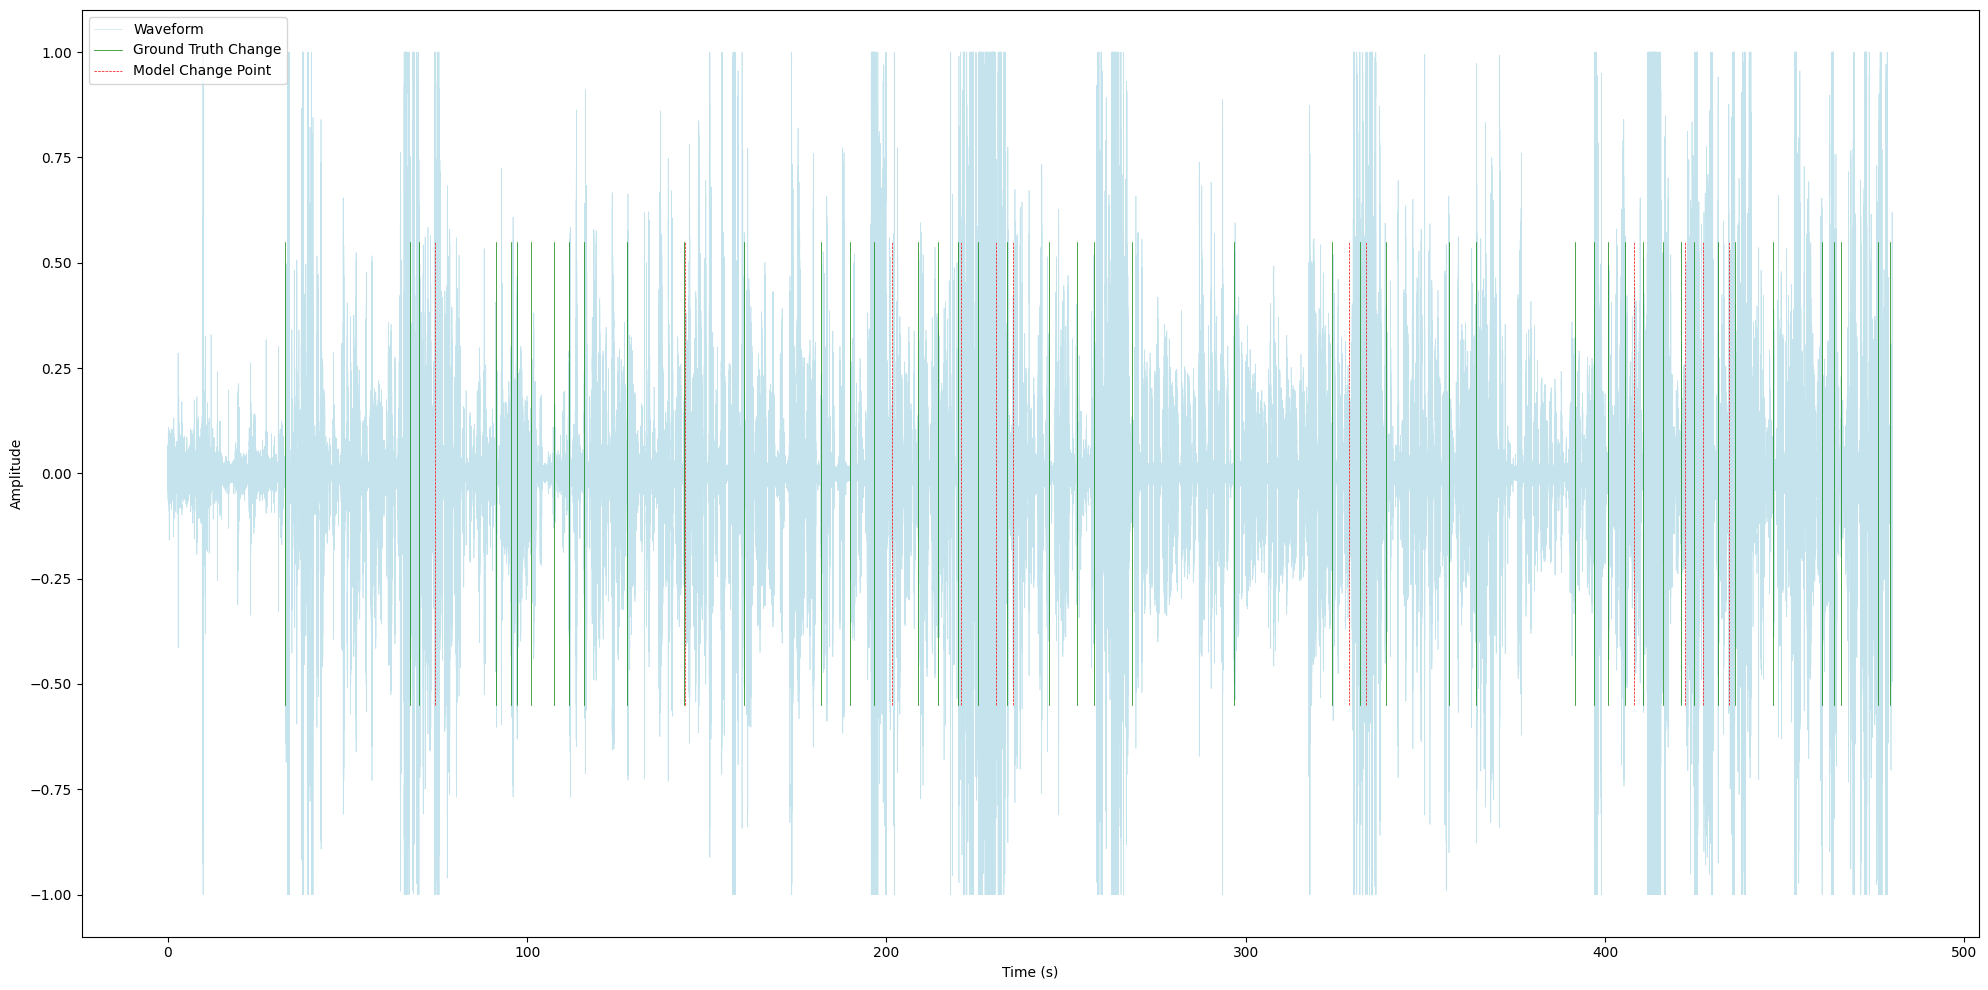

{'DER': 0.0919470750218283, 'Precision': 0.3643095149944465, 'Recall': 0.10593174722790397, 'F1': 0.1641367806505421, 'AUROC': 0.5307887146668827}
Metrics for file IS1006d.Mix-Headset generated
Metrics for file IS1006d.Mix-Headset saved in file
Speaker change detected at frame 268800
Speaker change detected at frame 307200
Speaker change detected at frame 768000
Speaker change detected at frame 806400
Speaker change detected at frame 844800
Speaker change detected at frame 2035200
Speaker change detected at frame 2073600
Speaker change detected at frame 2188800
Speaker change detected at frame 2572800
Speaker change detected at frame 4377600
Speaker change detected at frame 4416000
Speaker change detected at frame 4608000
Speaker change detected at frame 4646400
Speaker change detected at frame 4684800
Speaker change detected at frame 4838400
Speaker change detected at frame 5414400
Speaker change detected at frame 6144000
Speaker change detected at frame 6182400
Speaker change detecte

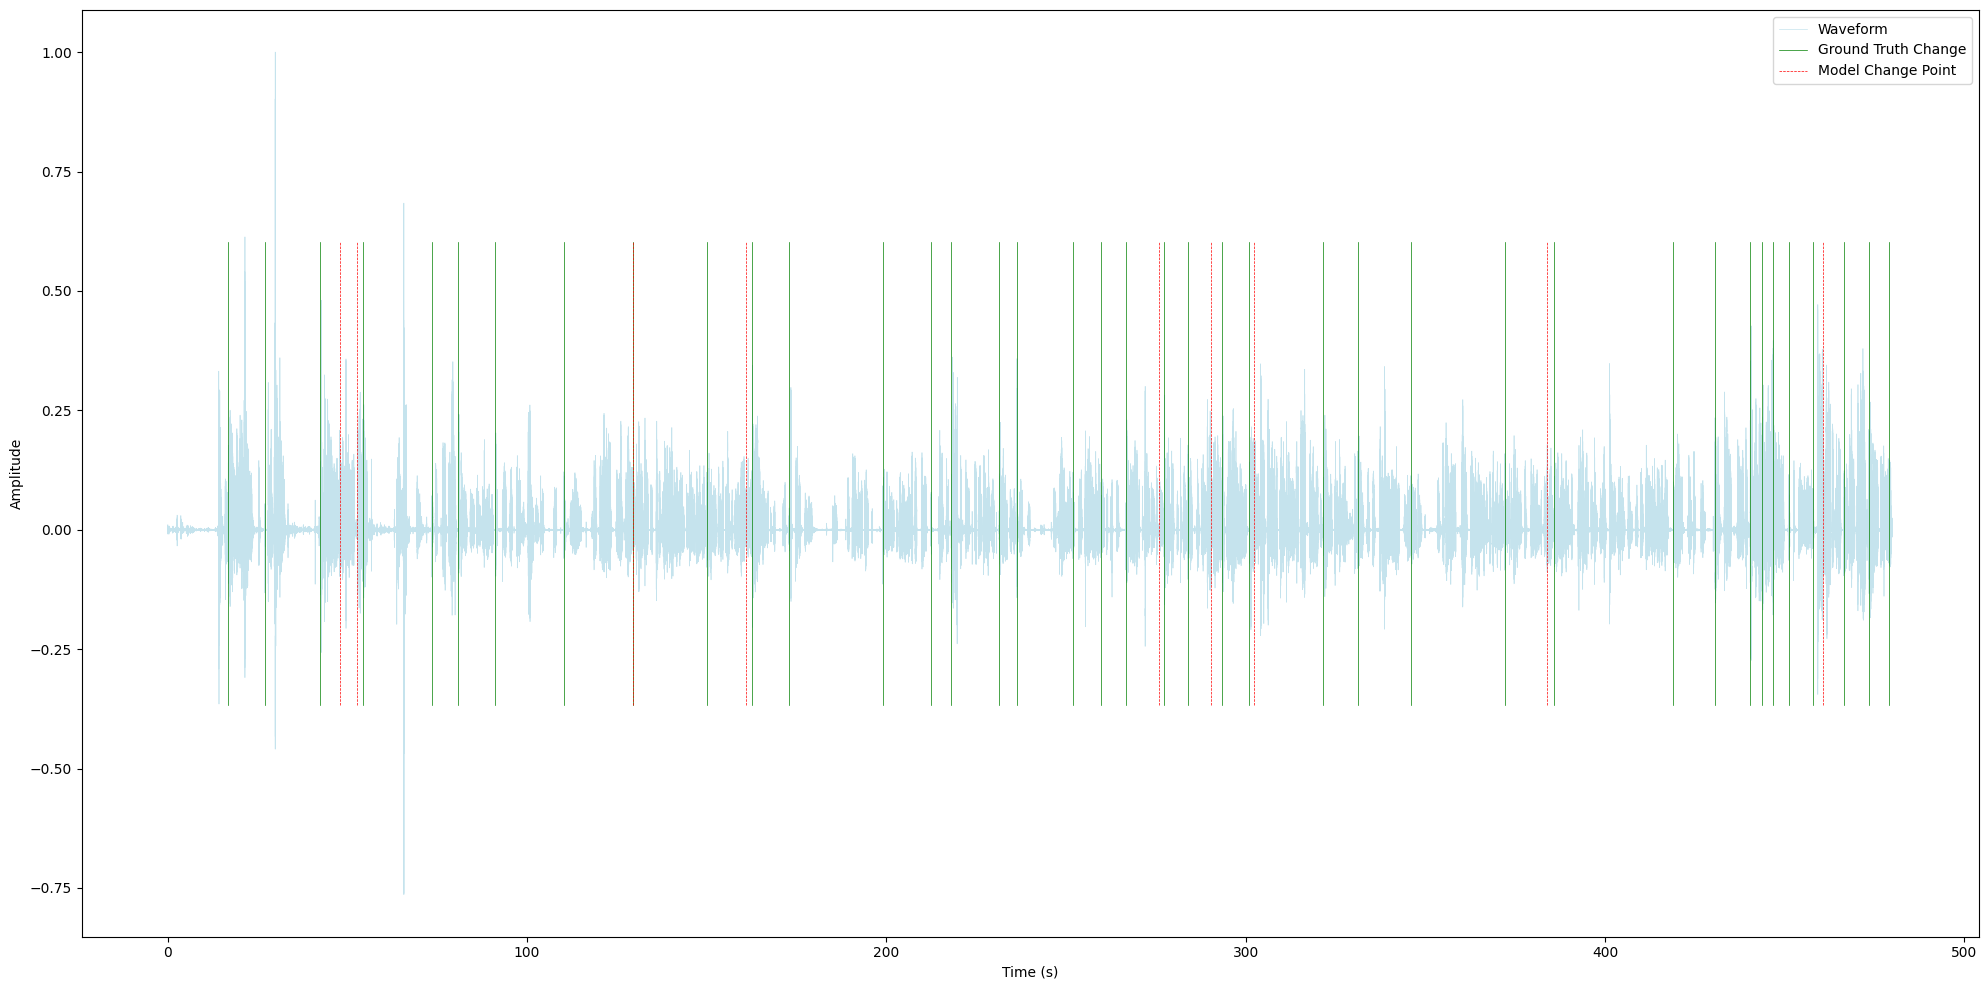

{'DER': 0.018861394704966318, 'Precision': 0.15634365634365635, 'Recall': 0.041705529646902065, 'F1': 0.06584621857578626, 'AUROC': 0.499998338351047}
Metrics for file EN2003a.Mix-Headset generated
Metrics for file EN2003a.Mix-Headset saved in file
Speaker change detected at frame 1382400
Speaker change detected at frame 2227200
Speaker change detected at frame 2534400
Speaker change detected at frame 2572800
Speaker change detected at frame 6912000
Speaker change detected at frame 6950400
Speaker change detected at frame 7104000
Speaker change detected at frame 7219200
Speaker change detected at frame 7411200
Speaker change detected at frame 7449600
Speaker change detected at frame 7488000
Speaker change detected at frame 7526400
Speaker change points: [1382400, 2227200, 2534400, 2572800, 6912000, 6950400, 7104000, 7219200, 7411200, 7449600, 7488000, 7526400]
about to calculate DER
DER calculated
DER: 0.1652536846224078
Precision: 0.0
Recall: 0.0
F1: 0.0
AUROC: 0.48607729939022976
[11

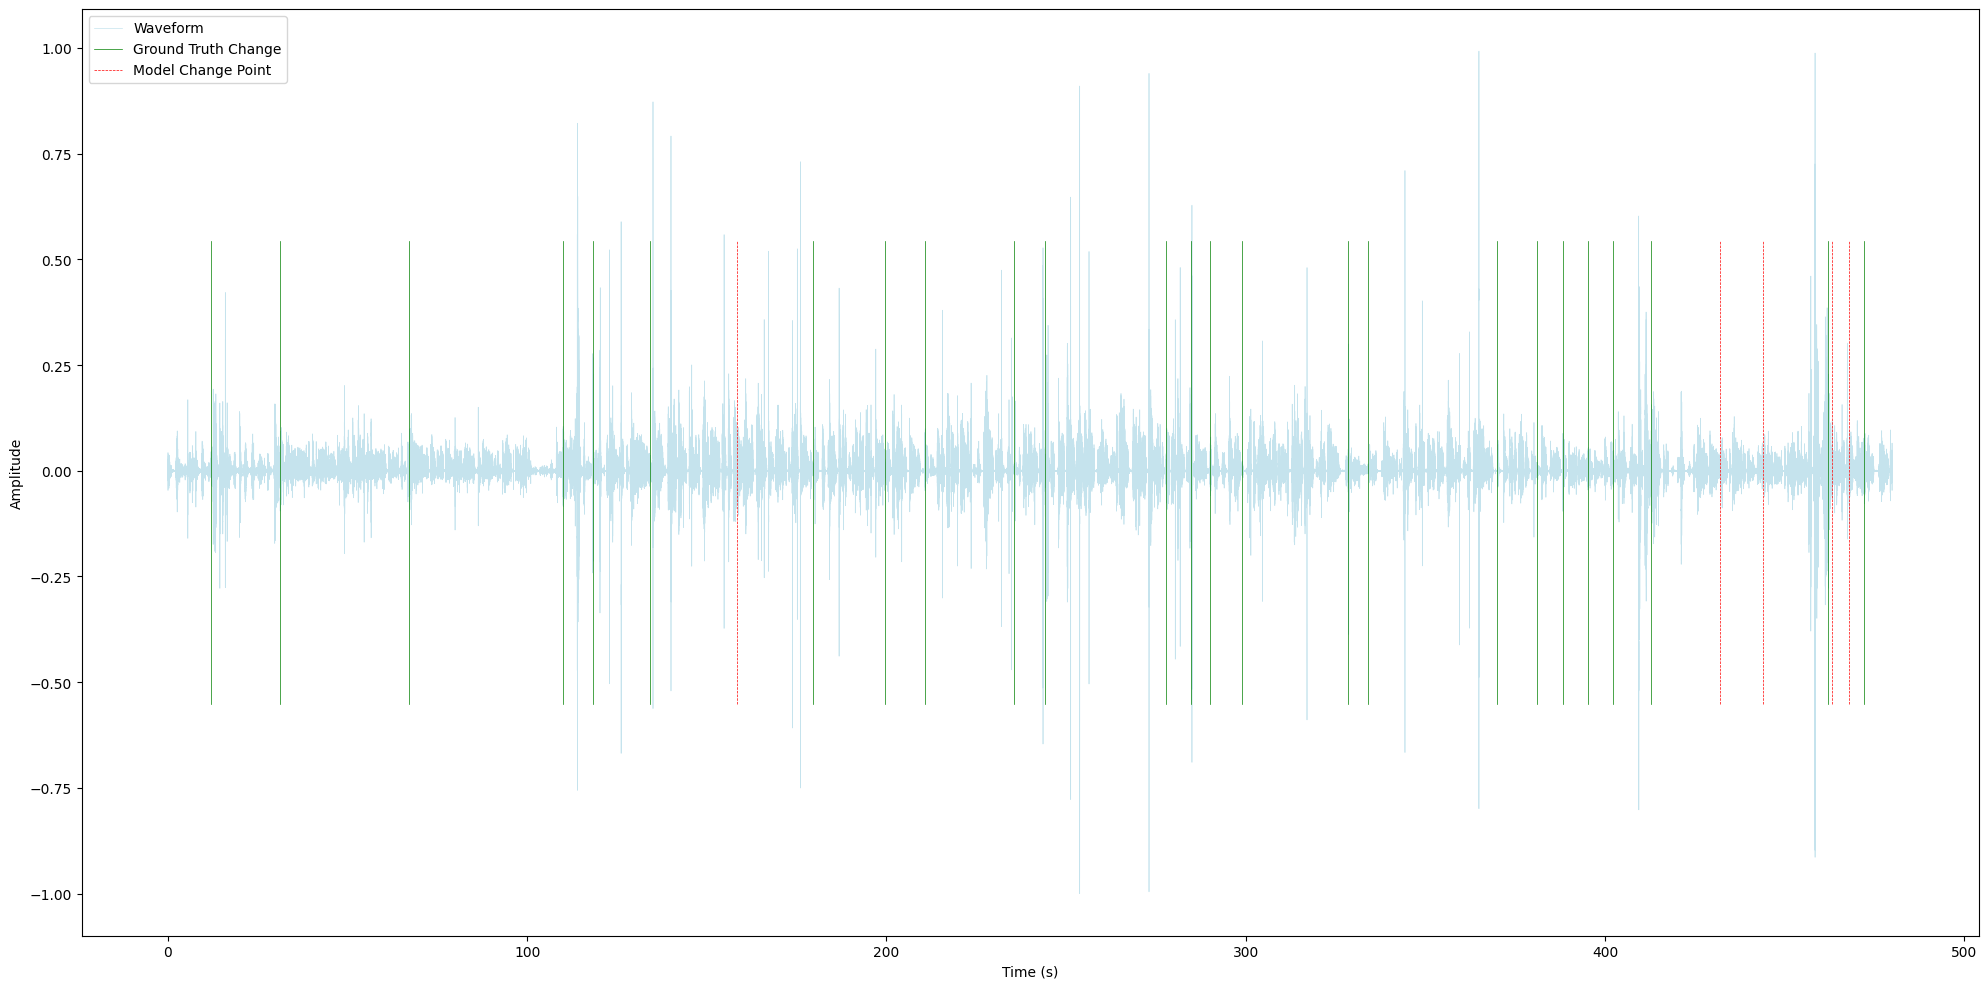

{'DER': 0.1652536846224078, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'AUROC': 0.48607729939022976}
Metrics for file ES2009c.Mix-Headset generated
Metrics for file ES2009c.Mix-Headset saved in file
Speaker change detected at frame 3340800
Speaker change detected at frame 3417600
Speaker change detected at frame 3724800
Speaker change detected at frame 3763200
Speaker change detected at frame 4608000
Speaker change detected at frame 4646400
Speaker change detected at frame 4684800
Speaker change detected at frame 4723200
Speaker change detected at frame 4761600
Speaker change detected at frame 4800000
Speaker change detected at frame 5068800
Speaker change detected at frame 5107200
Speaker change detected at frame 5145600
Speaker change detected at frame 5376000
Speaker change detected at frame 5644800
Speaker change detected at frame 5760000
Speaker change detected at frame 5798400
Speaker change detected at frame 5836800
Speaker change detected at frame 5913600
Speaker change detect

{'DER': 0.05668001322411199, 'Precision': 0.18458912460375518, 'Recall': 0.18440925700365407, 'F1': 0.18449914696563485, 'AUROC': 0.5541137297662079}
Metrics for file IS1000b.Mix-Headset generated
Metrics for file IS1000b.Mix-Headset saved in file
Speaker change detected at frame 2880000
Speaker change detected at frame 3532800
Speaker change detected at frame 4032000
Speaker change detected at frame 4339200
Speaker change detected at frame 4377600
Speaker change detected at frame 4608000
Speaker change detected at frame 4761600
Speaker change detected at frame 5068800
Speaker change detected at frame 5376000
Speaker change detected at frame 6220800
Speaker change detected at frame 6259200
Speaker change detected at frame 6374400
Speaker change detected at frame 6412800
Speaker change detected at frame 6528000
Speaker change detected at frame 6566400
Speaker change detected at frame 6604800
Speaker change detected at frame 6835200
Speaker change detected at frame 6873600
Speaker change

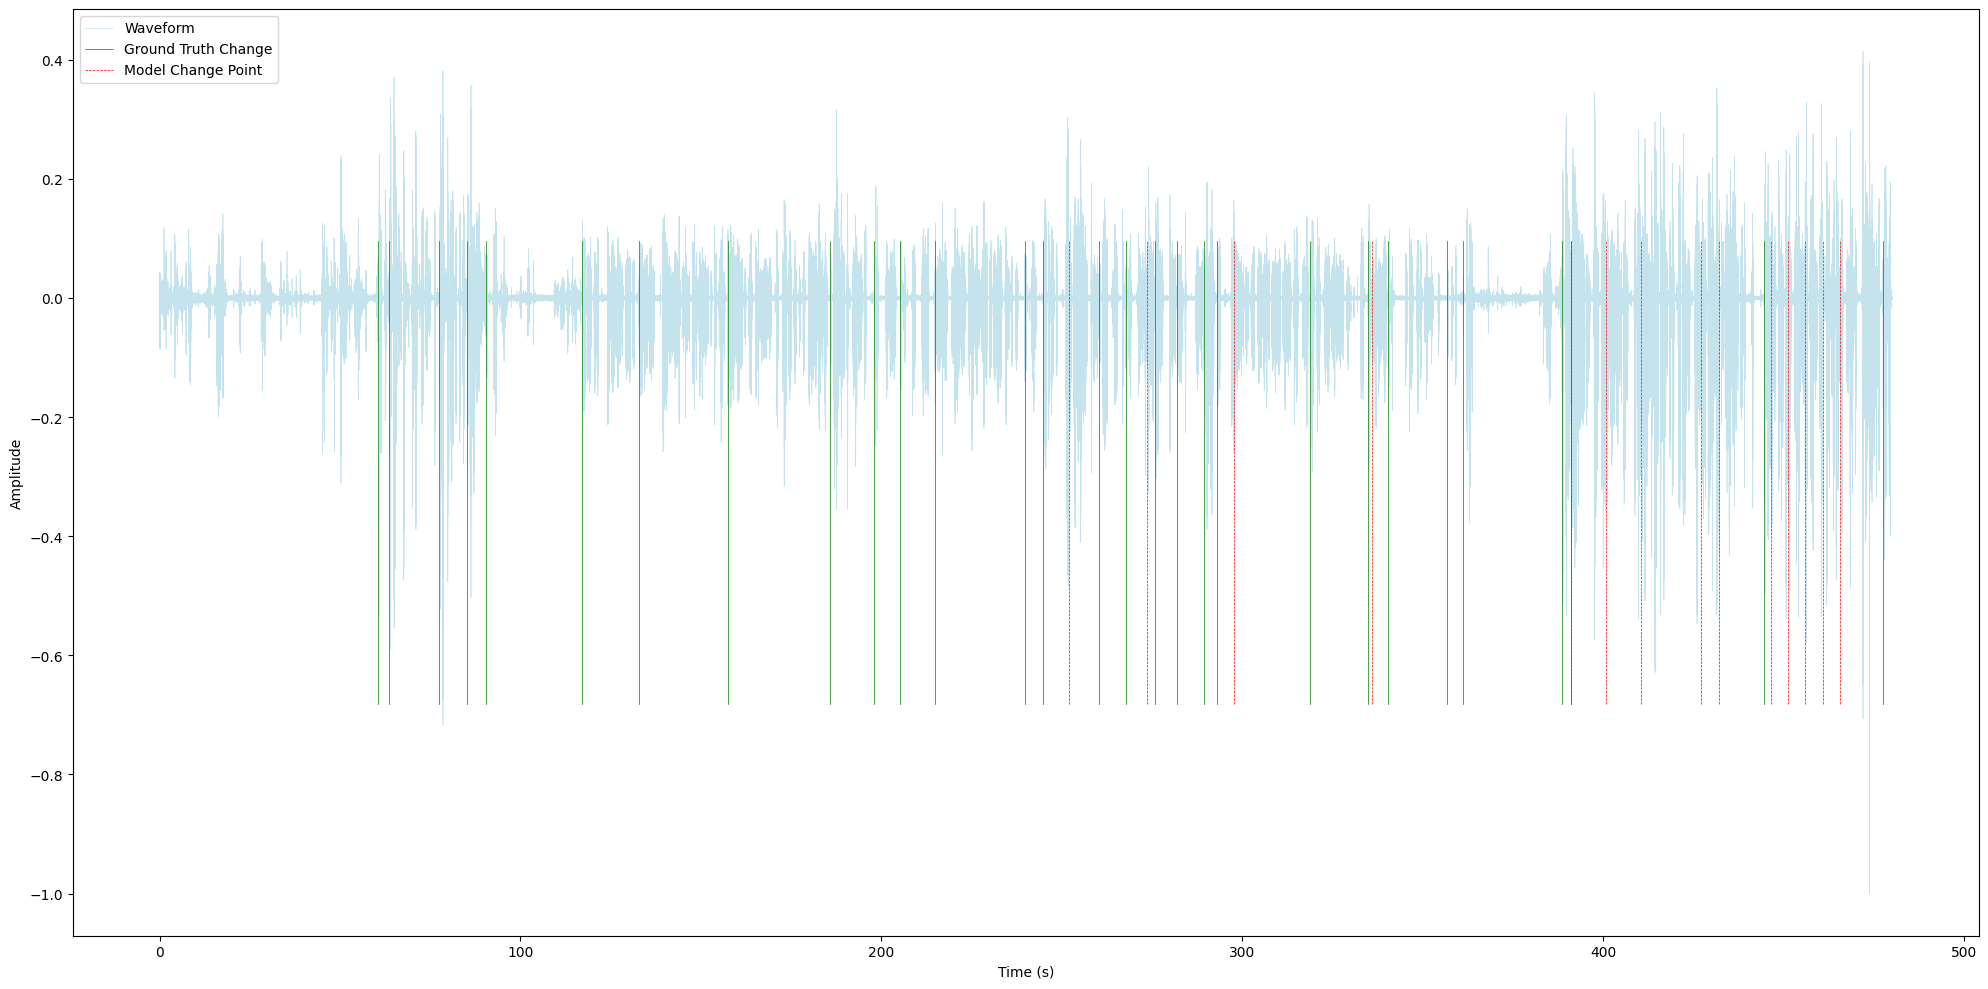

{'DER': 0.2978585645428168, 'Precision': 0.10709677419354839, 'Recall': 0.05868835071592717, 'F1': 0.07582505424232044, 'AUROC': 0.4966587255787793}
Metrics for file TS3010c.Mix-Headset generated
Metrics for file TS3010c.Mix-Headset saved in file
Speaker change detected at frame 1958400
Speaker change detected at frame 2649600
Speaker change detected at frame 3648000
Speaker change detected at frame 3878400
Speaker change detected at frame 3916800
Speaker change detected at frame 4262400
Speaker change detected at frame 4300800
Speaker change detected at frame 4339200
Speaker change detected at frame 4377600
Speaker change detected at frame 5260800
Speaker change detected at frame 5875200
Speaker change detected at frame 5952000
Speaker change detected at frame 5990400
Speaker change detected at frame 6028800
Speaker change detected at frame 6566400
Speaker change detected at frame 6604800
Speaker change detected at frame 6950400
Speaker change detected at frame 7564800
Speaker change 

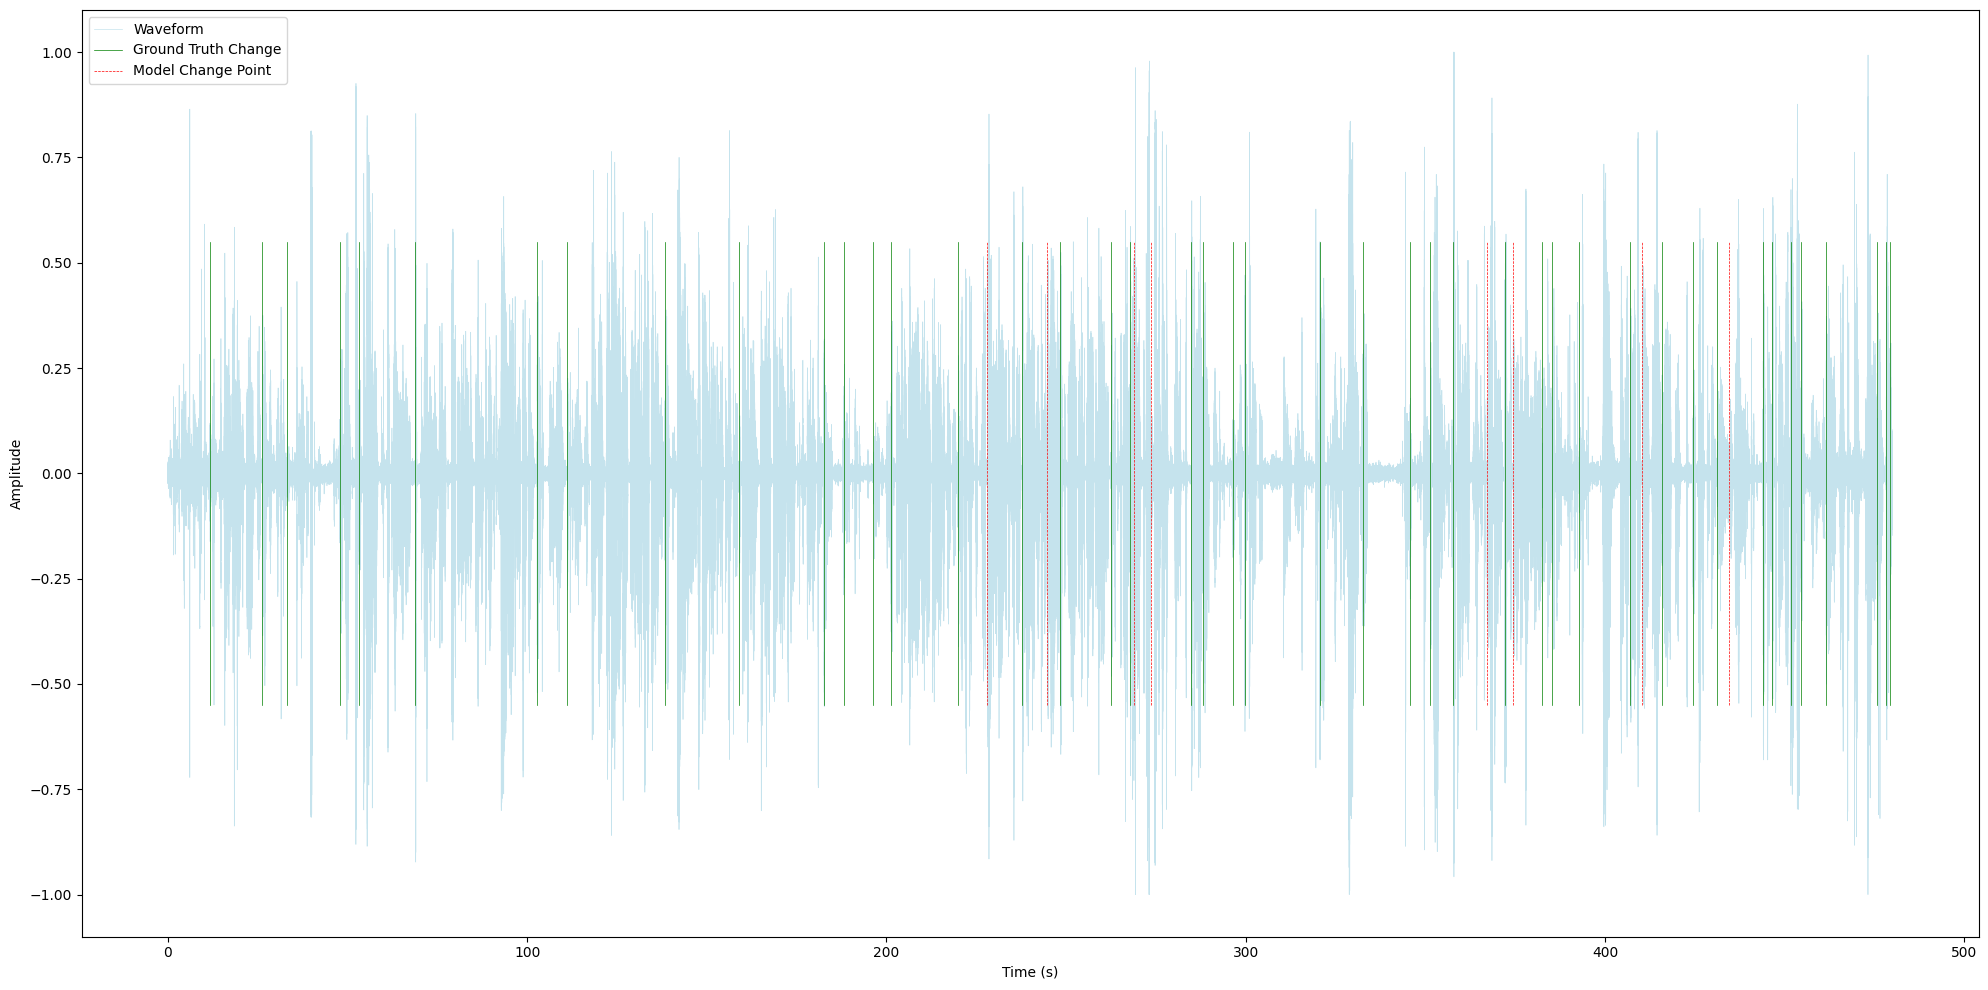

{'DER': 0.2505934940222854, 'Precision': 0.13159355913381454, 'Recall': 0.02830526692941598, 'F1': 0.04658934539021034, 'AUROC': 0.49441861373068824}
Metrics for file IS1001d.Mix-Headset generated
Metrics for file IS1001d.Mix-Headset saved in file
Speaker change detected at frame 2611200
Speaker change detected at frame 2688000
Speaker change detected at frame 2918400
Speaker change detected at frame 2956800
Speaker change detected at frame 2995200
Speaker change detected at frame 3033600
Speaker change detected at frame 3379200
Speaker change detected at frame 3456000
Speaker change detected at frame 3494400
Speaker change detected at frame 3686400
Speaker change detected at frame 3801600
Speaker change detected at frame 3916800
Speaker change detected at frame 3955200
Speaker change detected at frame 4147200
Speaker change detected at frame 4185600
Speaker change detected at frame 4224000
Speaker change detected at frame 4339200
Speaker change detected at frame 4377600
Speaker change

{'DER': 0.2816294746063807, 'Precision': 0.22931078657442994, 'Recall': 0.13210332103321032, 'F1': 0.16763438846225884, 'AUROC': 0.5295689437185458}
Metrics for file TS3008a.Mix-Headset generated
Metrics for file TS3008a.Mix-Headset saved in file
Speaker change detected at frame 652800
Speaker change detected at frame 2073600
Speaker change detected at frame 2304000
Speaker change detected at frame 2457600
Speaker change detected at frame 2496000
Speaker change detected at frame 2534400
Speaker change detected at frame 2572800
Speaker change detected at frame 3225600
Speaker change detected at frame 3264000
Speaker change detected at frame 3571200
Speaker change detected at frame 3801600
Speaker change detected at frame 3955200
Speaker change detected at frame 4108800
Speaker change detected at frame 4147200
Speaker change detected at frame 4224000
Speaker change detected at frame 4684800
Speaker change points: [652800, 2073600, 2304000, 2457600, 2496000, 2534400, 2572800, 3225600, 326

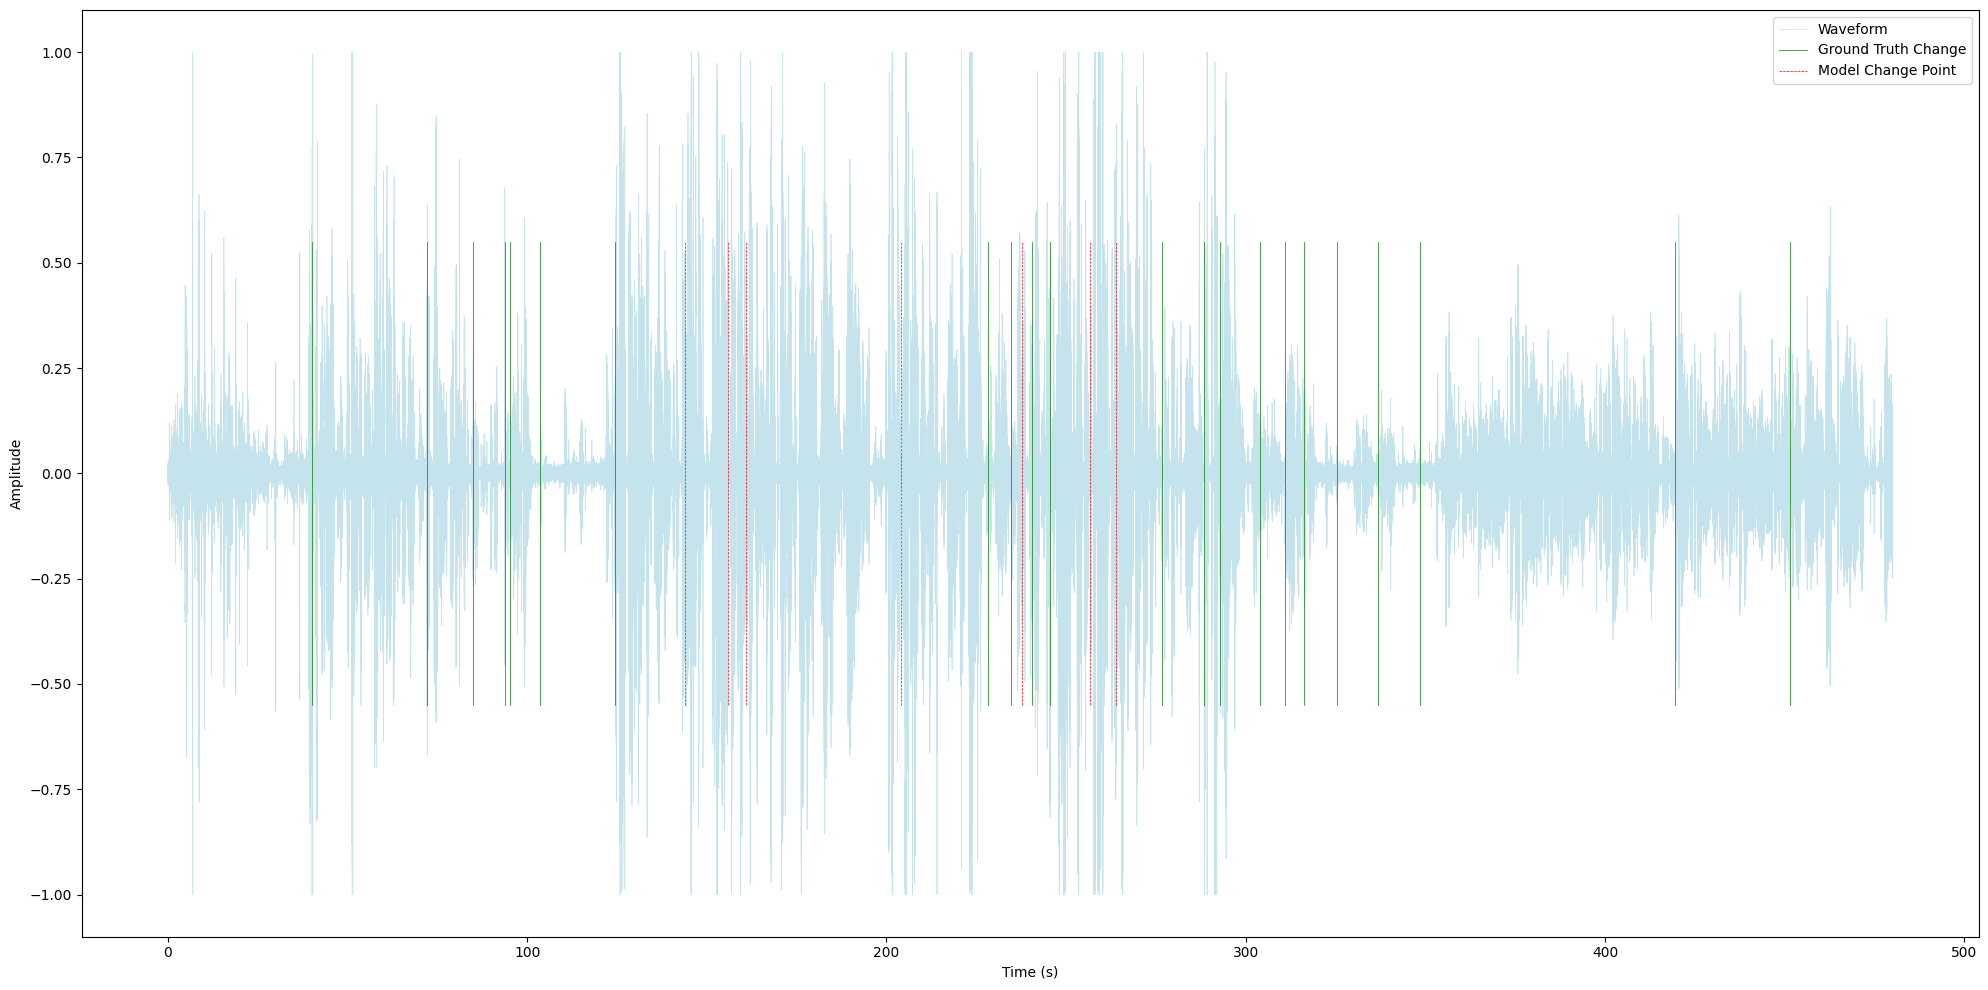

{'DER': 0.3875467846206192, 'Precision': 0.12554653341661462, 'Recall': 0.048503861003861004, 'F1': 0.06997389033942558, 'AUROC': 0.5082906025194424}
Metrics for file IS1005c.Mix-Headset generated
Metrics for file IS1005c.Mix-Headset saved in file
Speaker change detected at frame 2995200
Speaker change detected at frame 3033600
Speaker change detected at frame 3072000
Speaker change detected at frame 3840000
Speaker change detected at frame 5107200
Speaker change detected at frame 5299200
Speaker change detected at frame 5836800
Speaker change detected at frame 5952000
Speaker change detected at frame 6067200
Speaker change detected at frame 6105600
Speaker change detected at frame 6144000
Speaker change detected at frame 6182400
Speaker change detected at frame 6681600
Speaker change detected at frame 6720000
Speaker change detected at frame 6758400
Speaker change detected at frame 7372800
Speaker change detected at frame 7603200
Speaker change points: [2995200, 3033600, 3072000, 3840

{'DER': 0.29759523925662174, 'Precision': 0.14411764705882352, 'Recall': 0.04953497775980591, 'F1': 0.07372855853144748, 'AUROC': 0.5078701042001984}
Metrics for file ES2015a.Mix-Headset generated
Metrics for file ES2015a.Mix-Headset saved in file
Speaker change detected at frame 2572800
Speaker change detected at frame 2688000
Speaker change detected at frame 4377600
Speaker change detected at frame 4608000
Speaker change detected at frame 4761600
Speaker change detected at frame 4800000
Speaker change detected at frame 4838400
Speaker change detected at frame 5952000
Speaker change points: [2572800, 2688000, 4377600, 4608000, 4761600, 4800000, 4838400, 5952000]
about to calculate DER
DER calculated
DER: 0.4603709949409781
Precision: 0.10861423220973783
Recall: 0.01357042583060365
F1: 0.024126455906821966
AUROC: 0.49820121233822623
[82.13, 90.38, 92.86, 98.35, 104.1, 110.91, 115.86, 124.69, 132.07, 136.13, 143.26, 148.82, 159.21, 167.13, 177.87, 182.93, 196.72, 198.49, 212.06, 231.31,

{'DER': 0.4603709949409781, 'Precision': 0.10861423220973783, 'Recall': 0.01357042583060365, 'F1': 0.024126455906821966, 'AUROC': 0.49820121233822623}
Metrics for file TS3006c.Mix-Headset generated
Metrics for file TS3006c.Mix-Headset saved in file
Speaker change detected at frame 1344000
Speaker change detected at frame 1651200
Speaker change detected at frame 1689600
Speaker change detected at frame 1728000
Speaker change detected at frame 1766400
Speaker change detected at frame 1804800
Speaker change detected at frame 1843200
Speaker change detected at frame 2188800
Speaker change detected at frame 2380800
Speaker change detected at frame 2419200
Speaker change detected at frame 2995200
Speaker change detected at frame 3417600
Speaker change detected at frame 3571200
Speaker change detected at frame 3763200
Speaker change detected at frame 3801600
Speaker change detected at frame 4416000
Speaker change detected at frame 4723200
Speaker change detected at frame 5529600
Speaker chang

{'DER': 0.051857778666800046, 'Precision': 0.15270596346087556, 'Recall': 0.051142923112445164, 'F1': 0.07662371356914295, 'AUROC': 0.4943294055289716}
Metrics for file IS1003a.Mix-Headset generated
Metrics for file IS1003a.Mix-Headset saved in file
Speaker change detected at frame 2496000
Speaker change detected at frame 2534400
Speaker change detected at frame 2572800
Speaker change detected at frame 4339200
Speaker change detected at frame 4608000
Speaker change detected at frame 4915200
Speaker change detected at frame 5030400
Speaker change detected at frame 5068800
Speaker change detected at frame 5145600
Speaker change detected at frame 5184000
Speaker change detected at frame 5299200
Speaker change detected at frame 5337600
Speaker change detected at frame 5376000
Speaker change detected at frame 5414400
Speaker change detected at frame 5875200
Speaker change detected at frame 5913600
Speaker change detected at frame 5952000
Speaker change detected at frame 5990400
Speaker chan

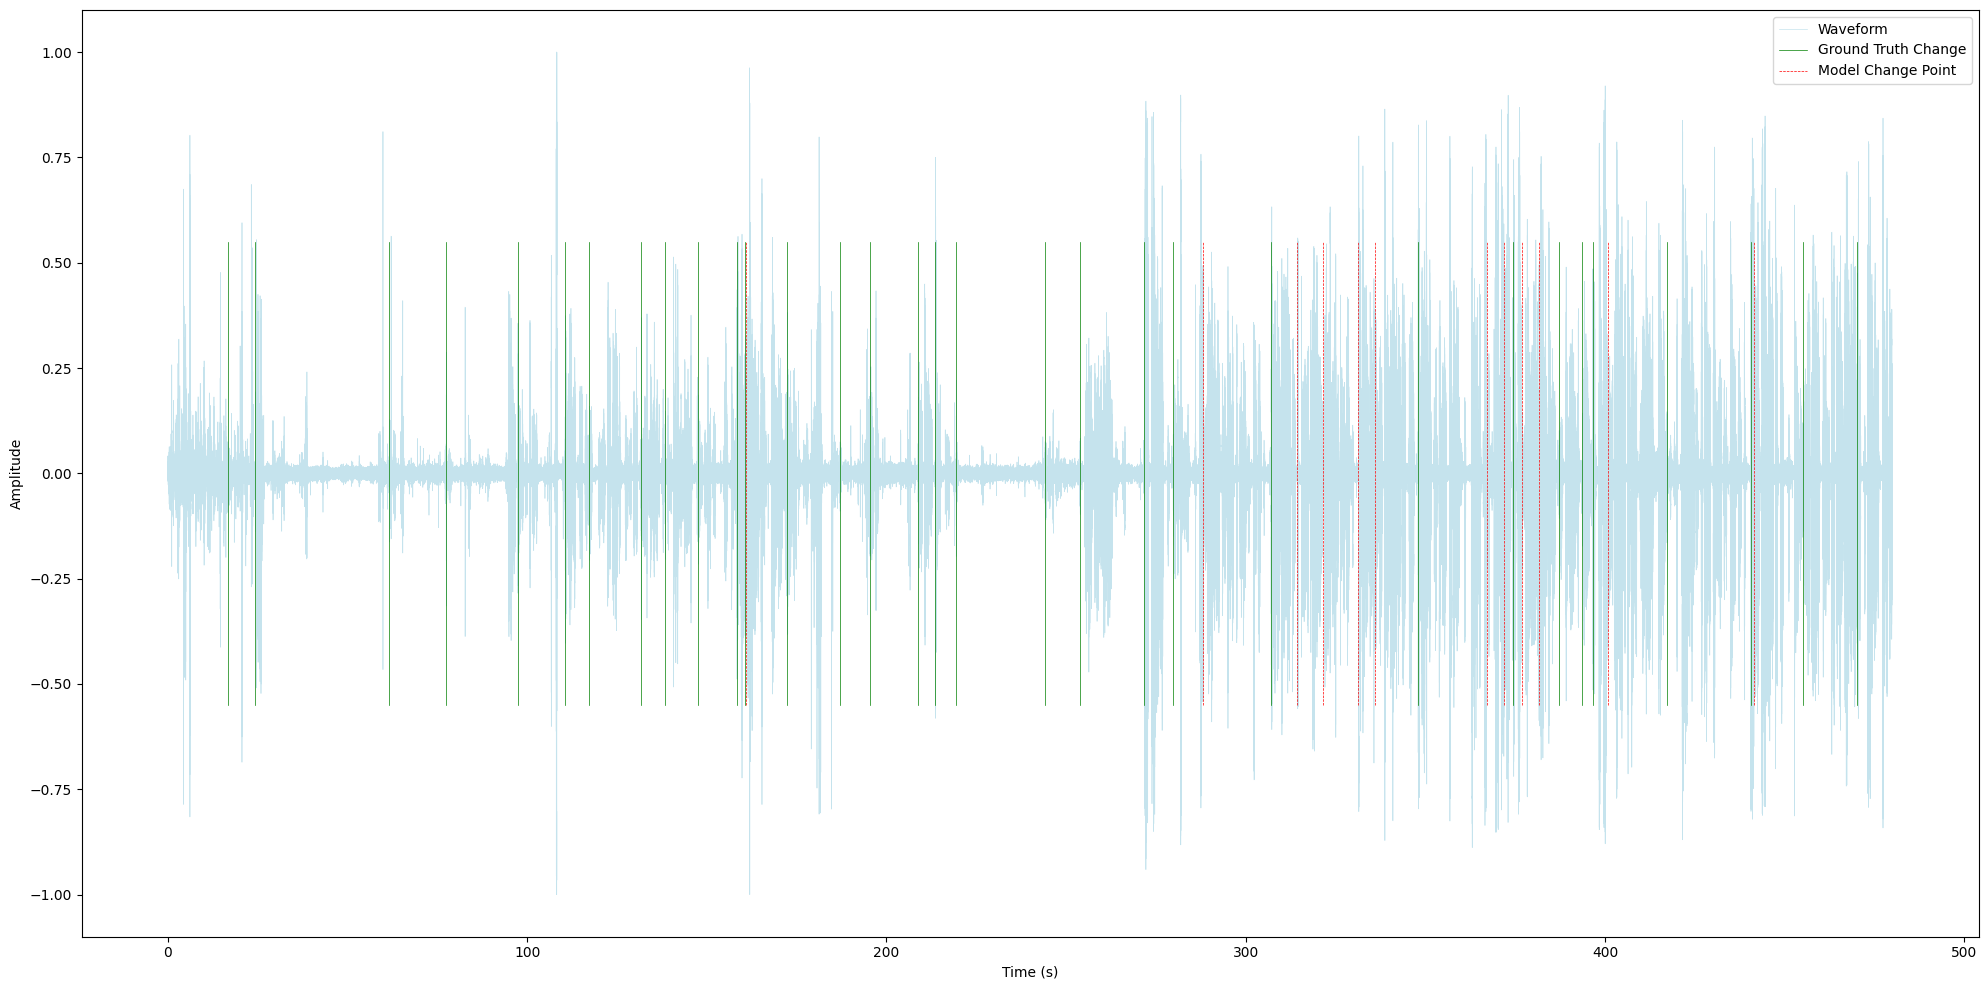

{'DER': 0.31738507331055, 'Precision': 0.24583487597186227, 'Recall': 0.1067524115755627, 'F1': 0.14886223517542876, 'AUROC': 0.5289985131118599}
Metrics for file IS1000c.Mix-Headset generated
Metrics for file IS1000c.Mix-Headset saved in file
Speaker change detected at frame 998400
Speaker change detected at frame 1459200
Speaker change detected at frame 2188800
Speaker change detected at frame 5606400
Speaker change detected at frame 5683200
Speaker change detected at frame 6604800
Speaker change detected at frame 6643200
Speaker change points: [998400, 1459200, 2188800, 5606400, 5683200, 6604800, 6643200]
about to calculate DER
DER calculated
DER: 0.20501149218081022
Precision: 0.10142857142857142
Recall: 0.01259088490867175
F1: 0.022401009622968922
AUROC: 0.49887116068572795
[31.73, 44.6, 70.99, 134.9, 138.42, 150.57, 164.98, 187.24, 218.94, 245.6, 267.27, 272.02, 282.07, 294.06, 297.63, 300.0, 308.64, 315.43, 318.99, 323.02, 334.44, 351.72, 426.25, 431.02, 436.05, 447.12, 449.46, 

{'DER': 0.20501149218081022, 'Precision': 0.10142857142857142, 'Recall': 0.01259088490867175, 'F1': 0.022401009622968922, 'AUROC': 0.49887116068572795}
Metrics for file ES2010a.Mix-Headset generated
Metrics for file ES2010a.Mix-Headset saved in file
Speaker change detected at frame 1766400
Speaker change detected at frame 1804800
Speaker change detected at frame 1843200
Speaker change detected at frame 2265600
Speaker change detected at frame 3724800
Speaker change detected at frame 3801600
Speaker change detected at frame 4262400
Speaker change detected at frame 4300800
Speaker change detected at frame 4377600
Speaker change detected at frame 4492800
Speaker change detected at frame 4531200
Speaker change detected at frame 4569600
Speaker change detected at frame 4723200
Speaker change detected at frame 4761600
Speaker change detected at frame 4800000
Speaker change detected at frame 4915200
Speaker change detected at frame 4953600
Speaker change detected at frame 4992000
Speaker chan

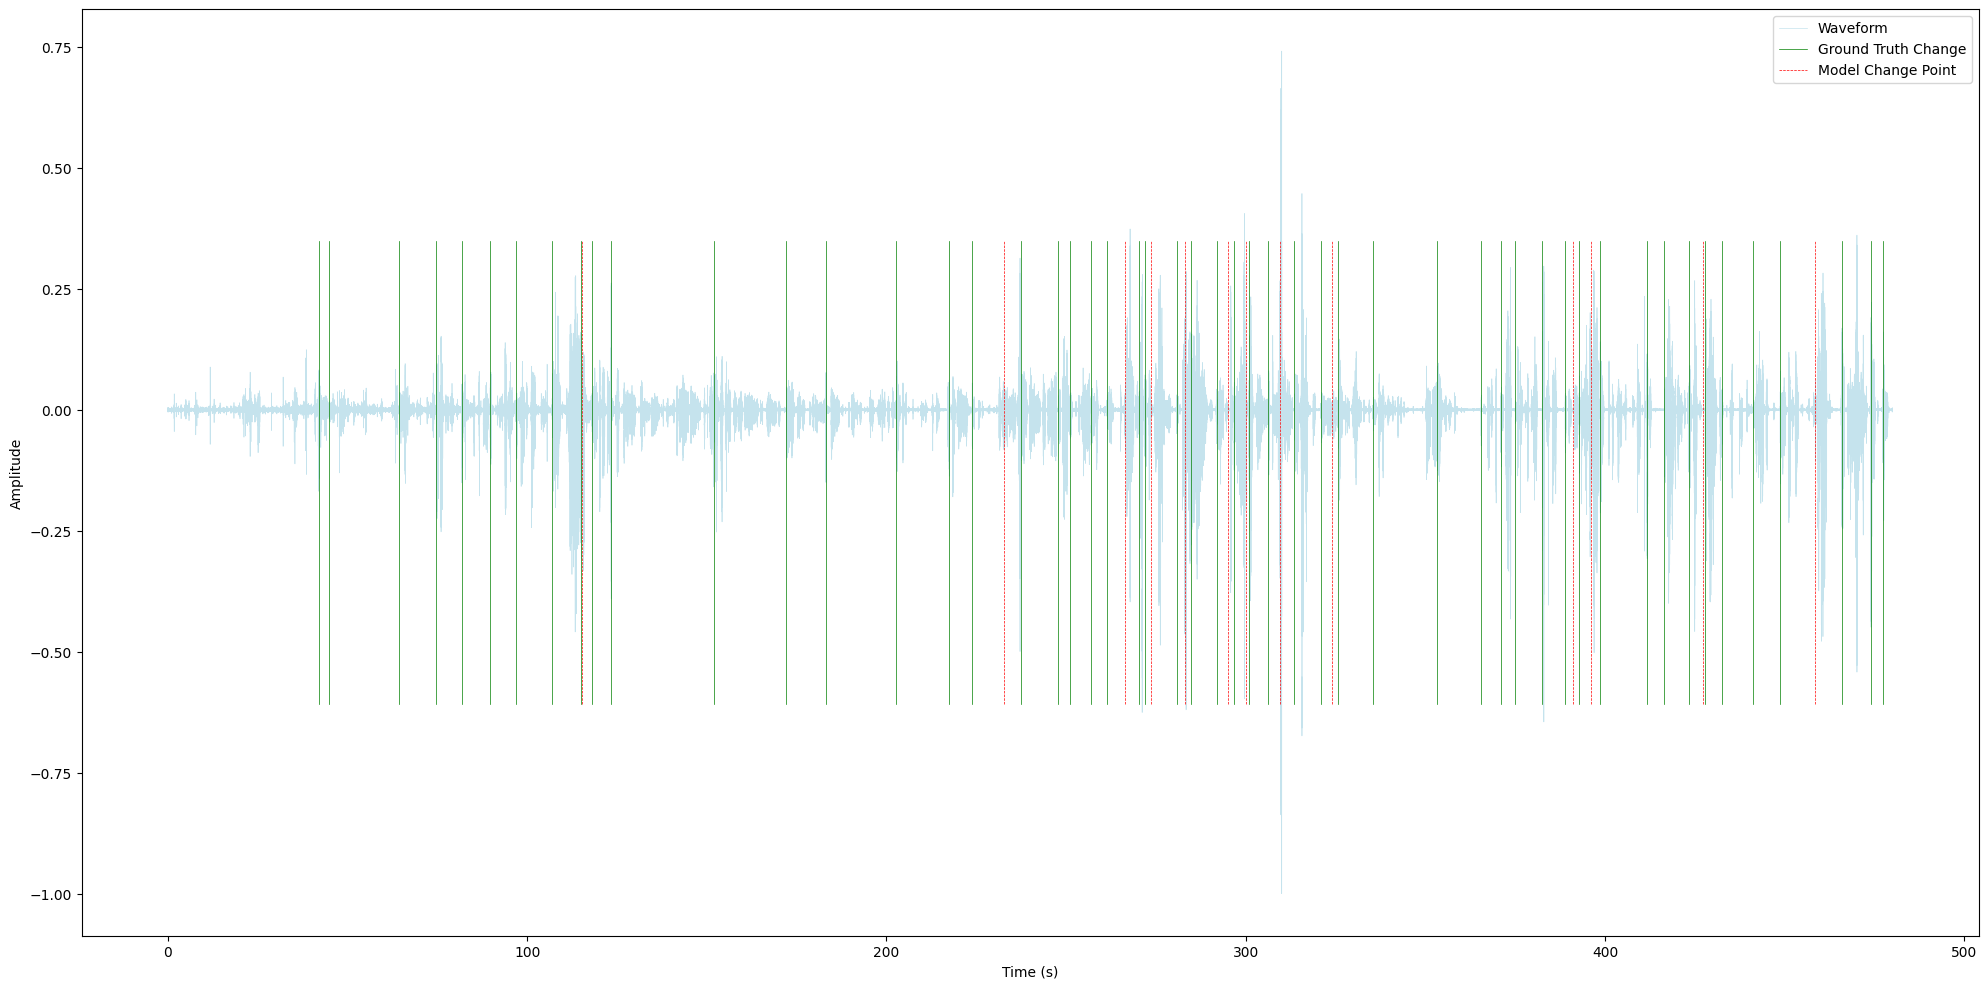

{'DER': 0.1783654619396642, 'Precision': 0.3809031368493623, 'Recall': 0.10647523607631529, 'F1': 0.16642819489419386, 'AUROC': 0.5293686052265049}
Metrics for file TS3006a.Mix-Headset generated
Metrics for file TS3006a.Mix-Headset saved in file
Speaker change detected at frame 921600
Speaker change detected at frame 2073600
Speaker change detected at frame 2112000
Speaker change detected at frame 2150400
Speaker change detected at frame 2188800
Speaker change detected at frame 2649600
Speaker change detected at frame 2688000
Speaker change detected at frame 2726400
Speaker change detected at frame 2764800
Speaker change detected at frame 3225600
Speaker change detected at frame 3264000
Speaker change detected at frame 3417600
Speaker change detected at frame 3456000
Speaker change detected at frame 3686400
Speaker change detected at frame 3763200
Speaker change detected at frame 4876800
Speaker change detected at frame 6604800
Speaker change detected at frame 7334400
Speaker change po

{'DER': 0.18028152423582064, 'Precision': 0.13777777777777778, 'Recall': 0.09114296214626975, 'F1': 0.1097102410971024, 'AUROC': 0.5284332933923116}
Metrics for file ES2014c.Mix-Headset generated
Metrics for file ES2014c.Mix-Headset saved in file
Speaker change detected at frame 729600
Speaker change detected at frame 768000
Speaker change detected at frame 806400
Speaker change detected at frame 921600
Speaker change detected at frame 998400
Speaker change detected at frame 1267200
Speaker change detected at frame 1305600
Speaker change detected at frame 1382400
Speaker change detected at frame 1728000
Speaker change detected at frame 1766400
Speaker change detected at frame 3072000
Speaker change detected at frame 3110400
Speaker change detected at frame 3456000
Speaker change detected at frame 3494400
Speaker change detected at frame 3571200
Speaker change detected at frame 4300800
Speaker change detected at frame 4339200
Speaker change detected at frame 4492800
Speaker change detec

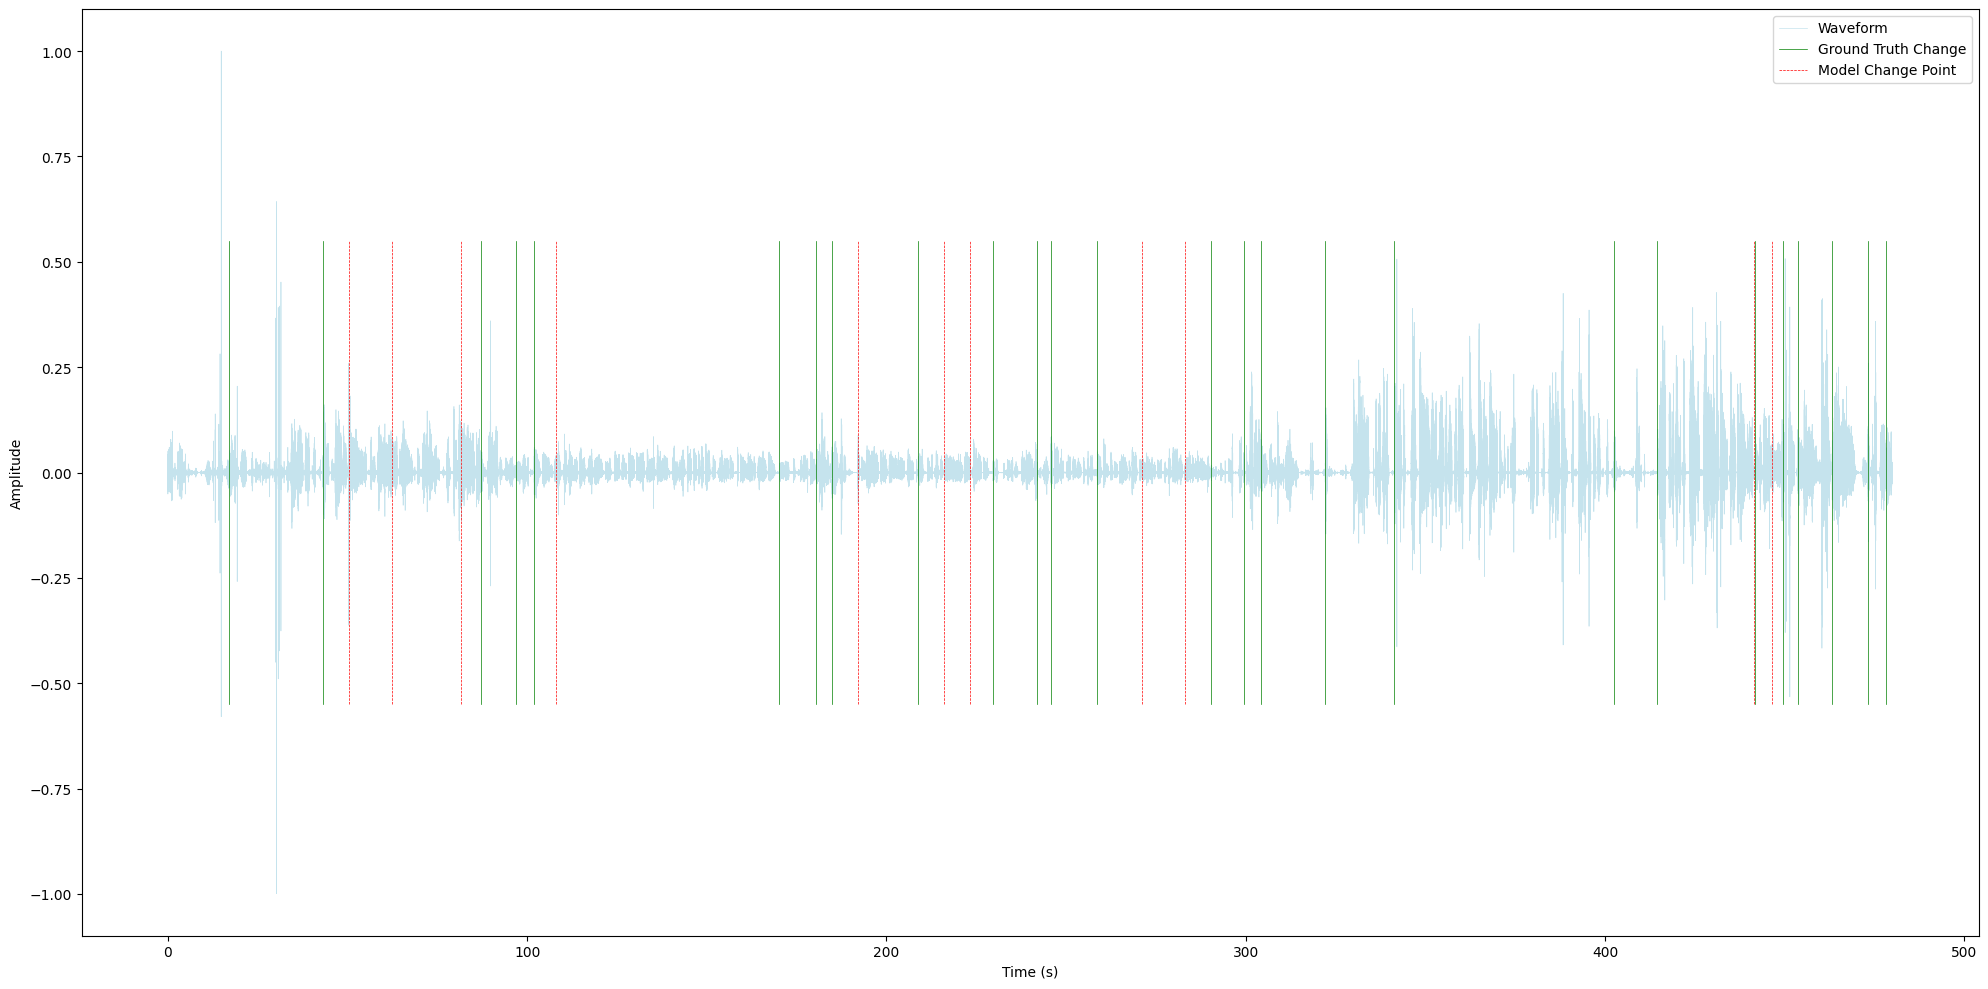

{'DER': 0.11558137518425372, 'Precision': 0.12536443148688048, 'Recall': 0.06012784658409908, 'F1': 0.08127447009585527, 'AUROC': 0.50564191091823}
Metrics for file ES2003d.Mix-Headset generated
Metrics for file ES2003d.Mix-Headset saved in file
Speaker change detected at frame 345600
Speaker change detected at frame 576000
Speaker change detected at frame 652800
Speaker change detected at frame 1612800
Speaker change detected at frame 1843200
Speaker change detected at frame 1881600
Speaker change detected at frame 1996800
Speaker change detected at frame 2035200
Speaker change detected at frame 2073600
Speaker change detected at frame 2112000
Speaker change detected at frame 2150400
Speaker change detected at frame 2188800
Speaker change detected at frame 2227200
Speaker change detected at frame 2726400
Speaker change detected at frame 2764800
Speaker change detected at frame 3840000
Speaker change detected at frame 4070400
Speaker change detected at frame 4531200
Speaker change dete

{'DER': 0.07819297267150017, 'Precision': 0.2497918401332223, 'Recall': 0.053681667710476874, 'F1': 0.0883717504970911, 'AUROC': 0.5023724309548772}
Metrics for file ES2002d.Mix-Headset generated
Metrics for file ES2002d.Mix-Headset saved in file
Speaker change detected at frame 4838400
Speaker change detected at frame 5644800
Speaker change detected at frame 5683200
Speaker change detected at frame 6681600
Speaker change detected at frame 6912000
Speaker change detected at frame 6950400
Speaker change detected at frame 7065600
Speaker change detected at frame 7104000
Speaker change points: [4838400, 5644800, 5683200, 6681600, 6912000, 6950400, 7065600, 7104000]
about to calculate DER
DER calculated
DER: 0.6989475922185606
Precision: 0.2272159800249688
Recall: 0.030358632193494578
F1: 0.053560918187168925
AUROC: 0.5078111456408492
[8.27, 15.12, 22.16, 25.92, 35.72, 43.71, 51.62, 84.7, 98.16, 139.58, 151.43, 160.92, 188.67, 193.67, 231.44, 260.39, 274.15, 315.32, 337.57, 366.92, 387.07,

{'DER': 0.6989475922185606, 'Precision': 0.2272159800249688, 'Recall': 0.030358632193494578, 'F1': 0.053560918187168925, 'AUROC': 0.5078111456408492}
Metrics for file ES2009a.Mix-Headset generated
Metrics for file ES2009a.Mix-Headset saved in file
Speaker change detected at frame 1804800
Speaker change detected at frame 1920000
Speaker change detected at frame 1958400
Speaker change detected at frame 1996800
Speaker change detected at frame 2035200
Speaker change detected at frame 2112000
Speaker change detected at frame 2150400
Speaker change detected at frame 2188800
Speaker change detected at frame 2227200
Speaker change detected at frame 2496000
Speaker change detected at frame 3494400
Speaker change detected at frame 3532800
Speaker change detected at frame 3648000
Speaker change detected at frame 3801600
Speaker change detected at frame 3878400
Speaker change detected at frame 3993600
Speaker change detected at frame 4108800
Speaker change detected at frame 4185600
Speaker change

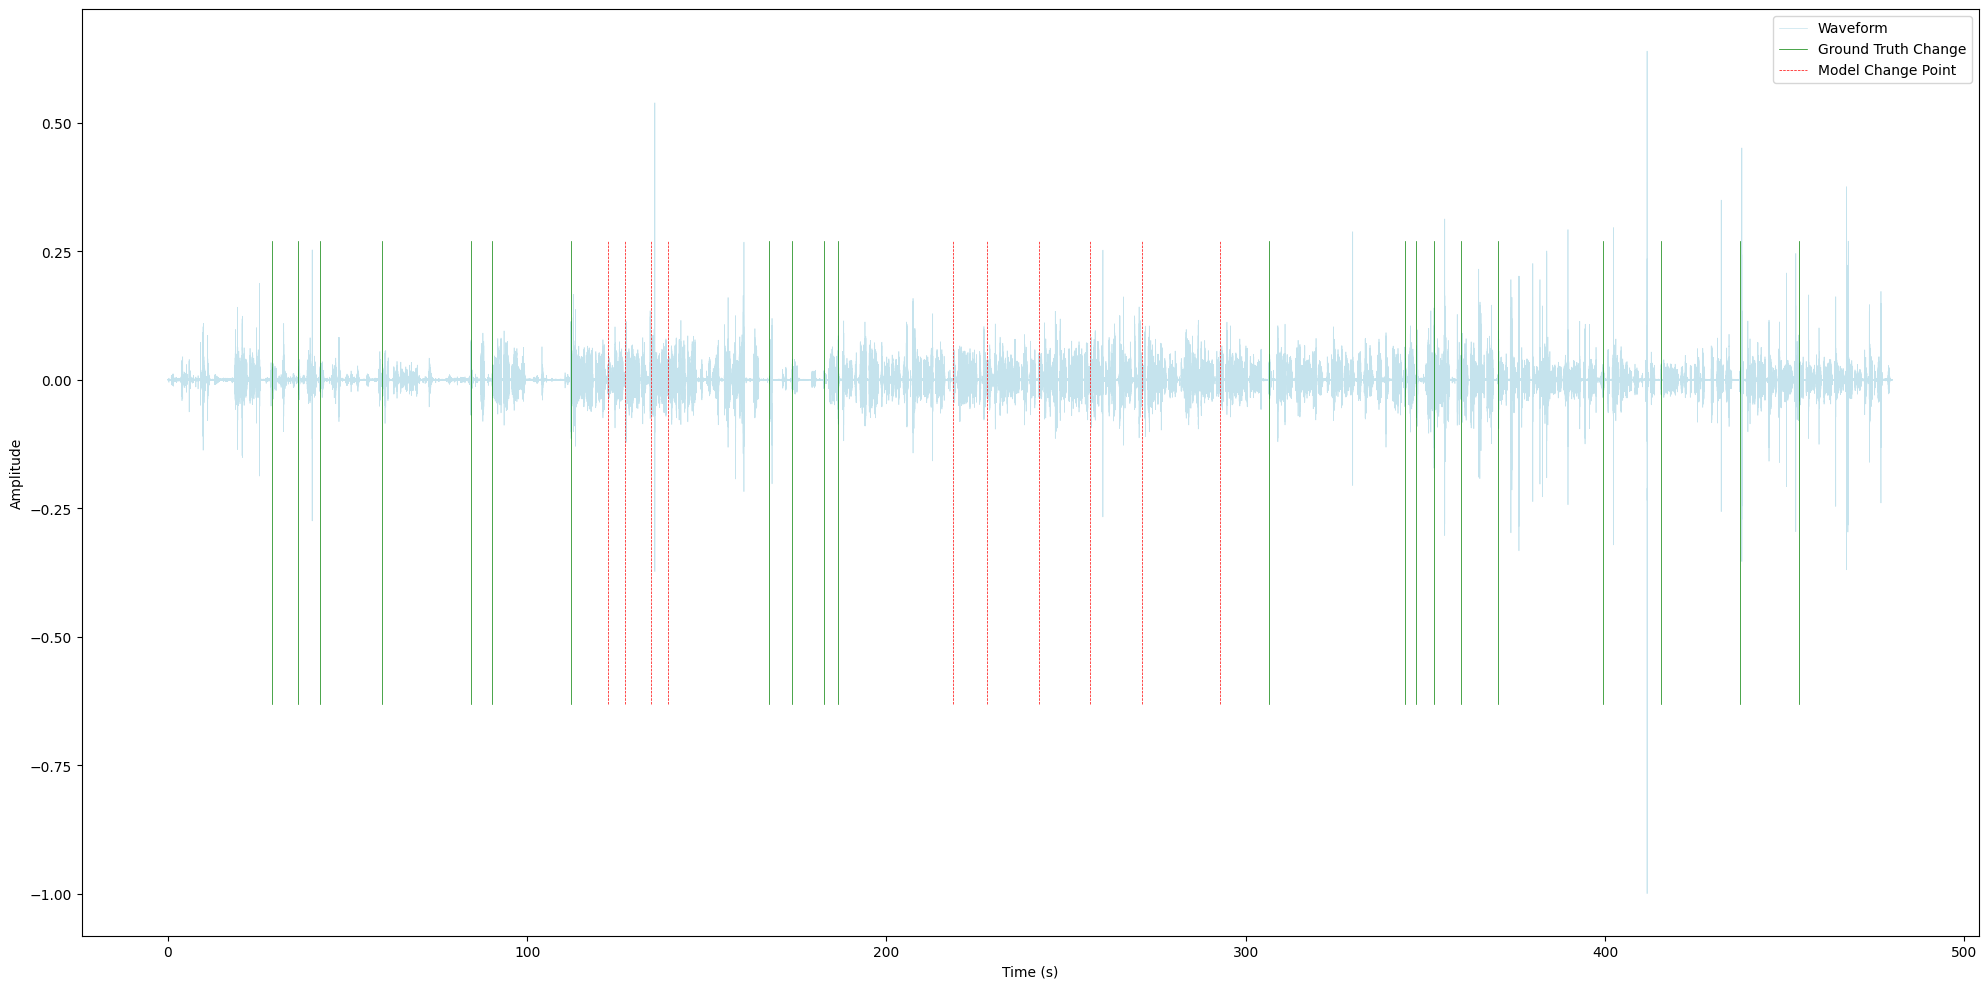

{'DER': 0.43534726143421776, 'Precision': 0.0343328987396784, 'Recall': 0.019170104343605922, 'F1': 0.024602927436935536, 'AUROC': 0.4842654231921088}
Metrics for file ES2013d.Mix-Headset generated
Metrics for file ES2013d.Mix-Headset saved in file
Speaker change points: []
Error generating results for file pair (/home/rahul/Documents/test_data_trimmed/trimmed_ES2002b.Mix-Headset.wav, /home/rahul/Documents/test_data_trimmed/trimmed_ES2002b.rttm): list index out of range
Speaker change detected at frame 1920000
Speaker change detected at frame 2265600
Speaker change detected at frame 2649600
Speaker change detected at frame 2803200
Speaker change detected at frame 2841600
Speaker change detected at frame 2995200
Speaker change detected at frame 3033600
Speaker change detected at frame 3072000
Speaker change detected at frame 3110400
Speaker change detected at frame 3148800
Speaker change detected at frame 3187200
Speaker change detected at frame 3225600
Speaker change detected at frame 

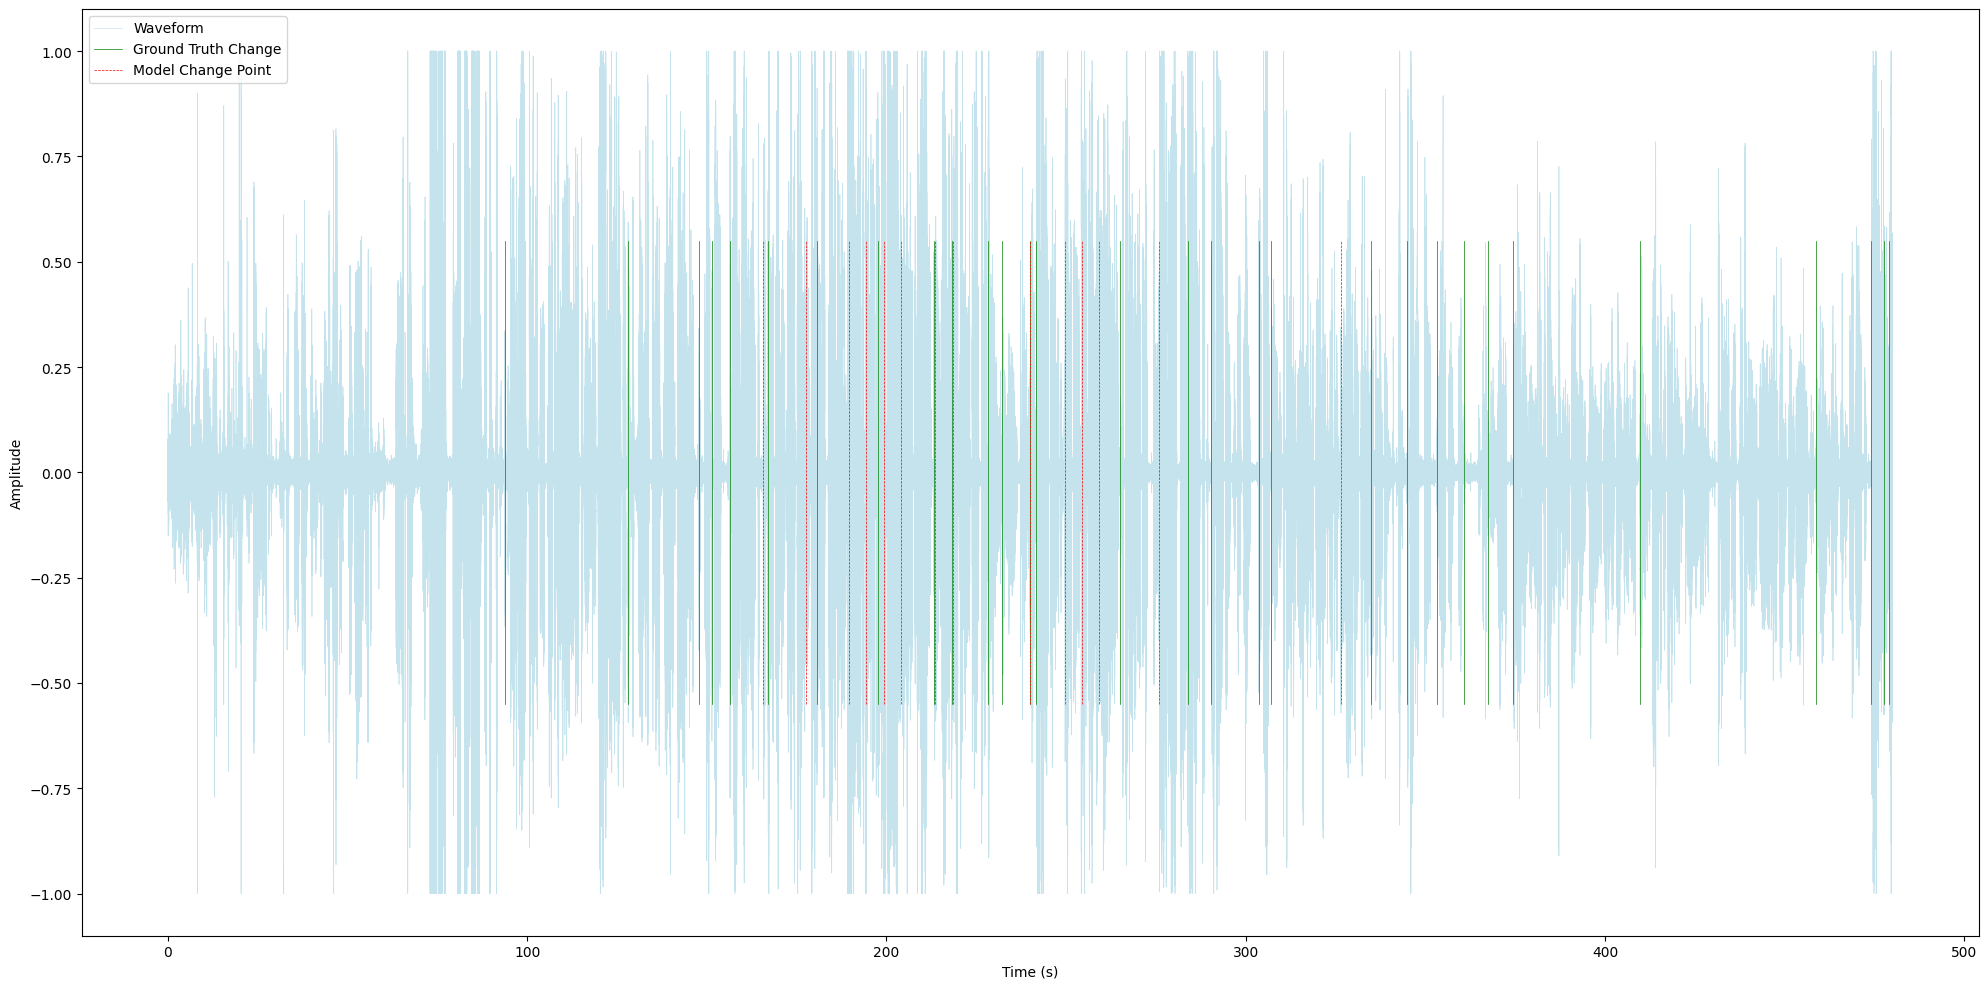

{'DER': 0.07838405853506651, 'Precision': 0.2125120928732667, 'Recall': 0.11795238947556828, 'F1': 0.1517034990791897, 'AUROC': 0.5301878515411227}
Metrics for file IS1002b.Mix-Headset generated
Metrics for file IS1002b.Mix-Headset saved in file
Speaker change detected at frame 1612800
Speaker change detected at frame 1804800
Speaker change detected at frame 5107200
Speaker change detected at frame 5145600
Speaker change detected at frame 5260800
Speaker change detected at frame 5299200
Speaker change detected at frame 5760000
Speaker change detected at frame 7411200
Speaker change detected at frame 7449600
Speaker change detected at frame 7488000
Speaker change detected at frame 7526400
Speaker change detected at frame 7564800
Speaker change detected at frame 7603200
Speaker change points: [1612800, 1804800, 5107200, 5145600, 5260800, 5299200, 5760000, 7411200, 7449600, 7488000, 7526400, 7564800, 7603200]
about to calculate DER
DER calculated
DER: 0.19181492816017423
Precision: 0.0
Re

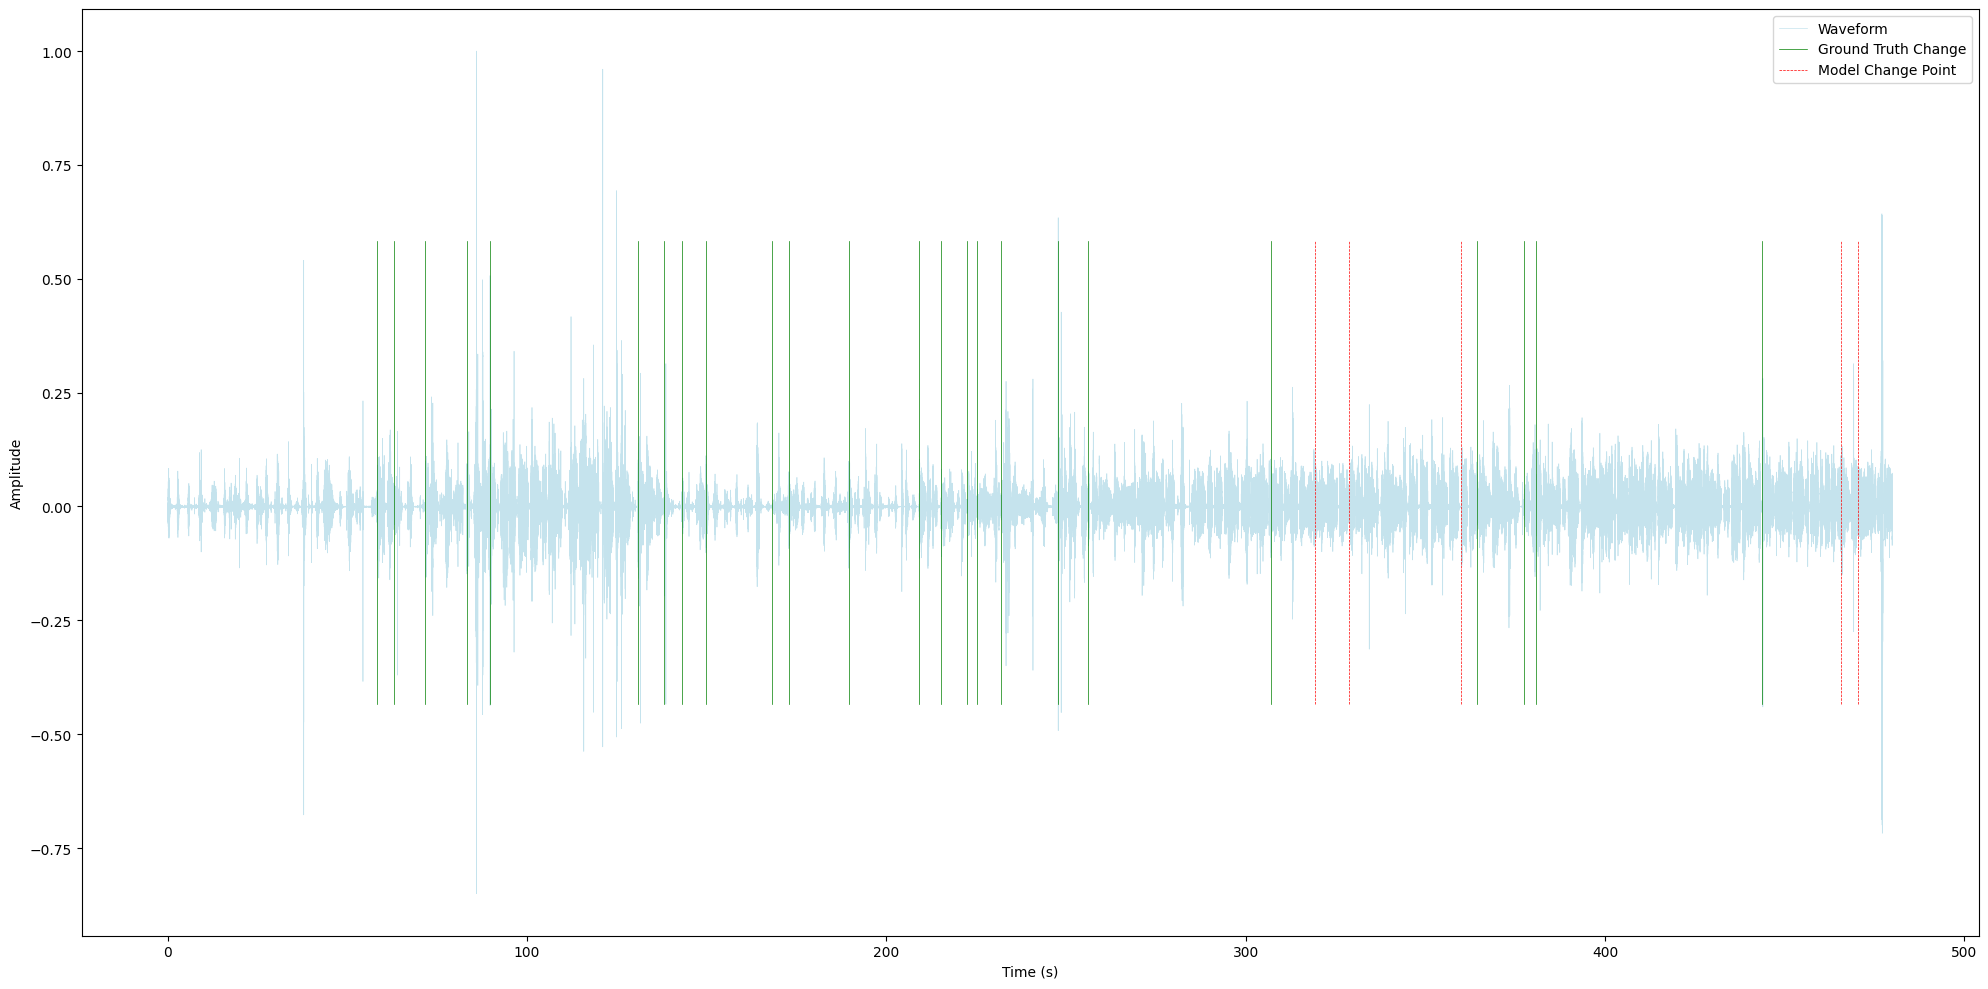

{'DER': 0.19181492816017423, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'AUROC': 0.4850199350095642}
Metrics for file ES2008b.Mix-Headset generated
Metrics for file ES2008b.Mix-Headset saved in file
Speaker change detected at frame 2649600
Speaker change detected at frame 2688000
Speaker change detected at frame 2726400
Speaker change detected at frame 3264000
Speaker change detected at frame 3302400
Speaker change detected at frame 3648000
Speaker change detected at frame 3916800
Speaker change detected at frame 4185600
Speaker change detected at frame 4377600
Speaker change detected at frame 4416000
Speaker change detected at frame 4454400
Speaker change detected at frame 4838400
Speaker change detected at frame 5337600
Speaker change detected at frame 5376000
Speaker change detected at frame 5568000
Speaker change detected at frame 5606400
Speaker change detected at frame 5644800
Speaker change detected at frame 5683200
Speaker change detected at frame 5952000
Speaker change detect

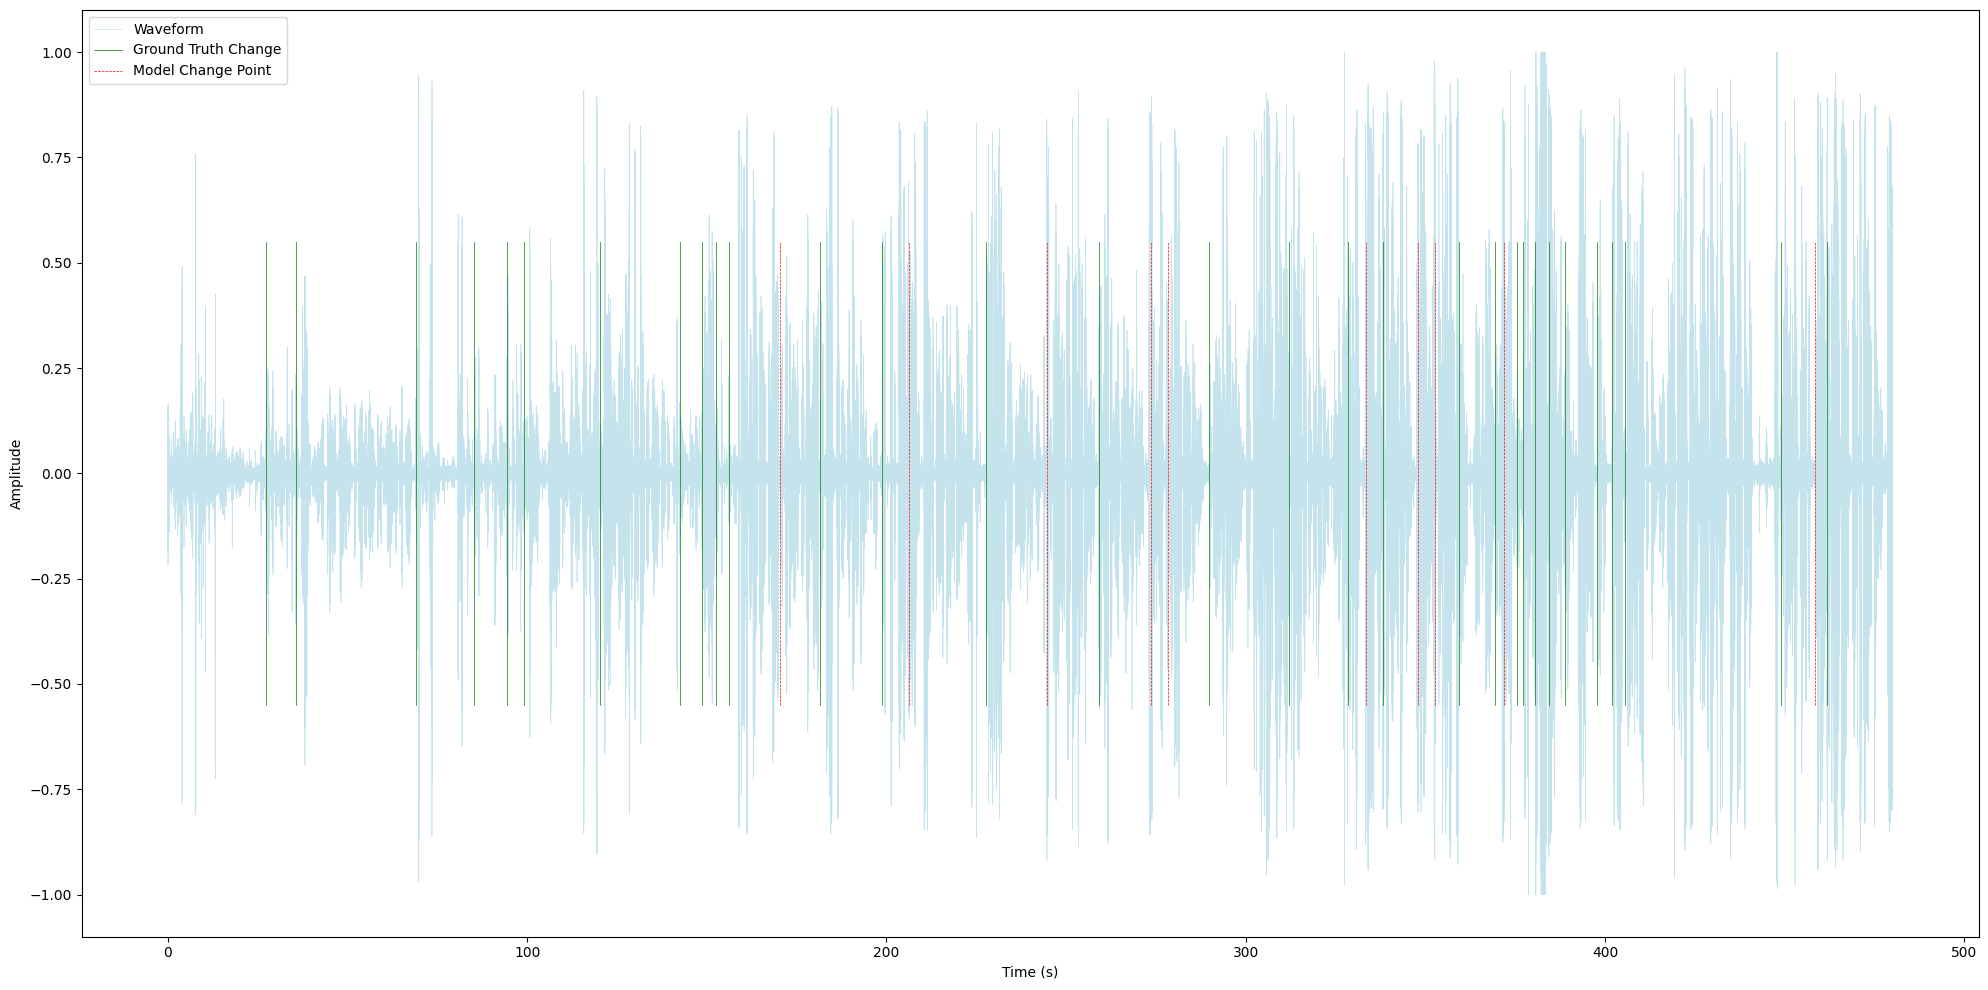

{'DER': 0.3216907112123513, 'Precision': 0.0682015638575152, 'Recall': 0.026346702466856855, 'F1': 0.038009926159060646, 'AUROC': 0.48766254035833034}
Metrics for file IS1006b.Mix-Headset generated
Metrics for file IS1006b.Mix-Headset saved in file
Speaker change detected at frame 2918400
Speaker change detected at frame 2956800
Speaker change detected at frame 3187200
Speaker change detected at frame 4377600
Speaker change detected at frame 4761600
Speaker change detected at frame 4800000
Speaker change detected at frame 5145600
Speaker change detected at frame 5184000
Speaker change detected at frame 5299200
Speaker change detected at frame 5376000
Speaker change detected at frame 5452800
Speaker change detected at frame 5491200
Speaker change detected at frame 5529600
Speaker change detected at frame 5606400
Speaker change detected at frame 5644800
Speaker change detected at frame 5683200
Speaker change detected at frame 5721600
Speaker change detected at frame 5760000
Speaker chang

{'DER': 0.36719789065963565, 'Precision': 0.275, 'Recall': 0.0888427368178147, 'F1': 0.13429842155751287, 'AUROC': 0.5186160649741324}
Metrics for file IS1003c.Mix-Headset generated
Metrics for file IS1003c.Mix-Headset saved in file
Speaker change detected at frame 460800
Speaker change detected at frame 2457600
Speaker change detected at frame 2496000
Speaker change detected at frame 2611200
Speaker change detected at frame 2956800
Speaker change detected at frame 3110400
Speaker change detected at frame 3148800
Speaker change detected at frame 3187200
Speaker change detected at frame 3340800
Speaker change detected at frame 3763200
Speaker change detected at frame 3801600
Speaker change detected at frame 4339200
Speaker change detected at frame 4531200
Speaker change detected at frame 4569600
Speaker change detected at frame 4608000
Speaker change detected at frame 4646400
Speaker change detected at frame 4992000
Speaker change detected at frame 5030400
Speaker change detected at fra

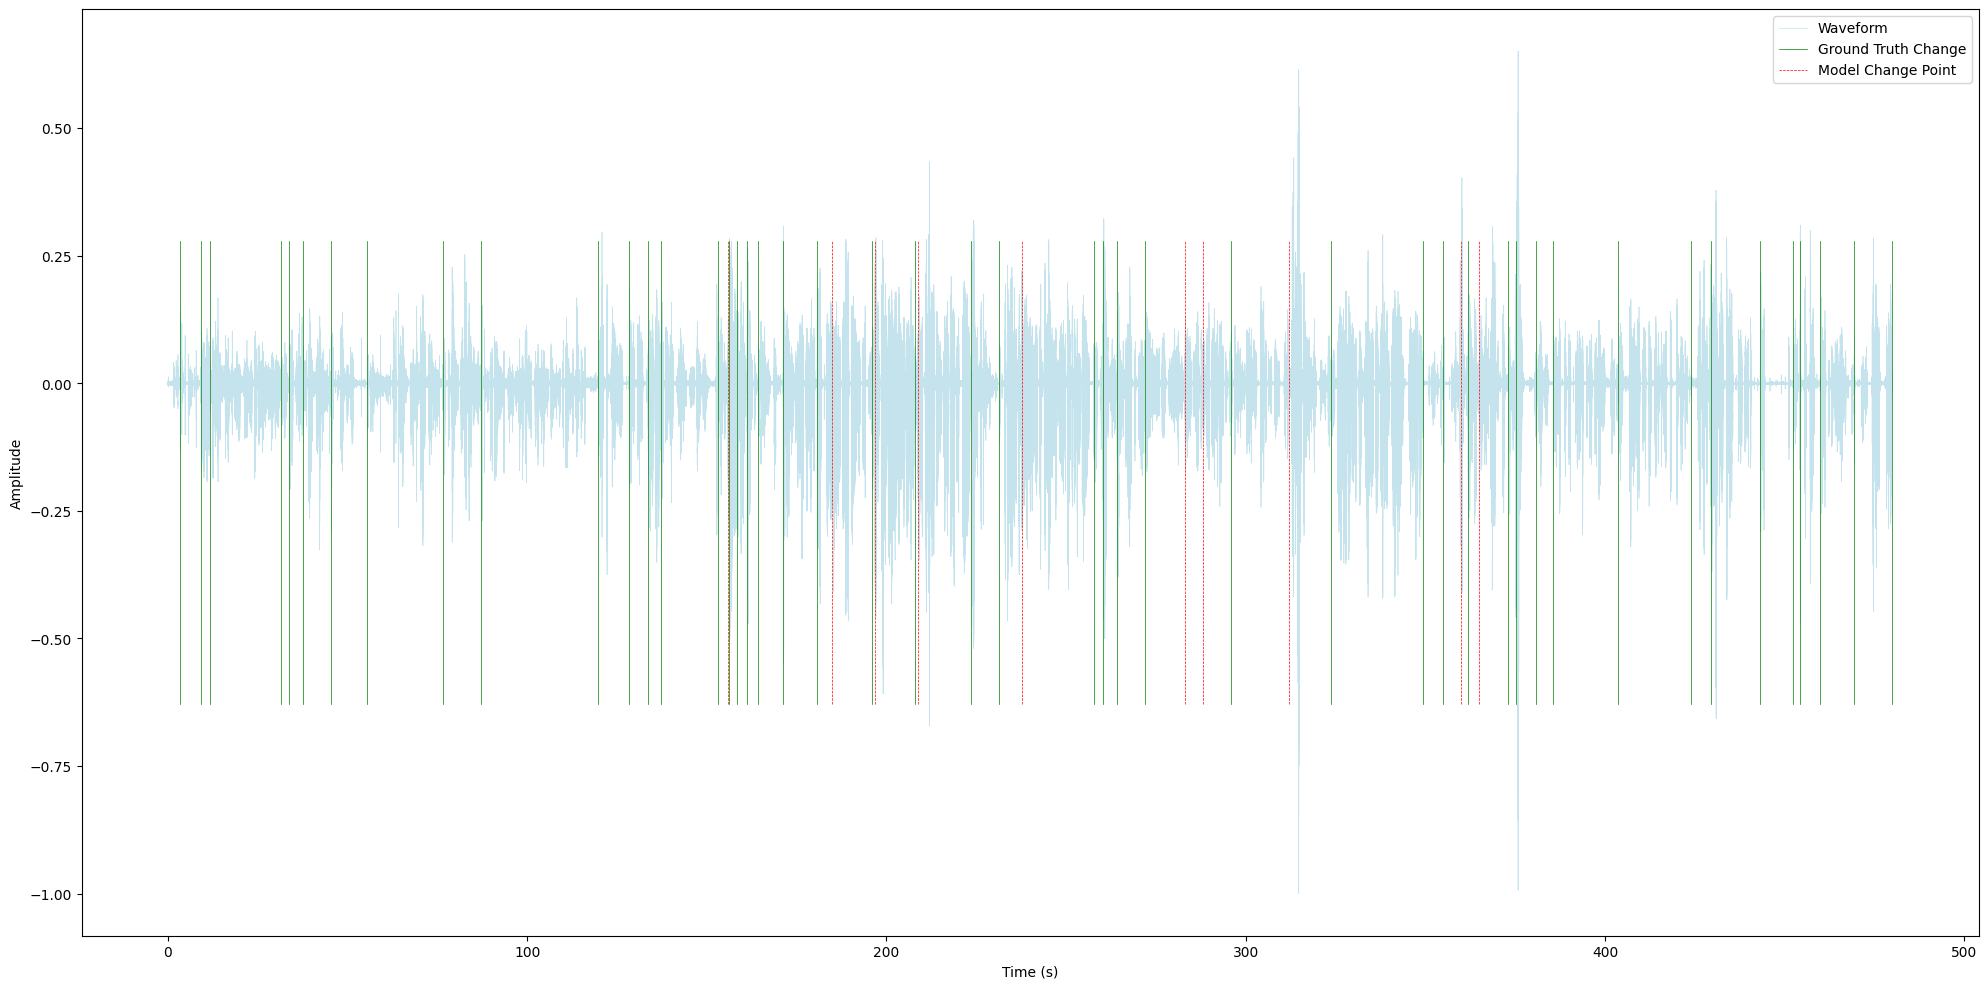

{'DER': 0.1587784657361736, 'Precision': 0.1932262266608771, 'Recall': 0.048275113907572144, 'F1': 0.07725023869455777, 'AUROC': 0.5001831451132415}
Metrics for file TS3005d.Mix-Headset generated
Metrics for file TS3005d.Mix-Headset saved in file
Speaker change detected at frame 1420800
Speaker change detected at frame 1459200
Speaker change detected at frame 1766400
Speaker change detected at frame 1804800
Speaker change detected at frame 1843200
Speaker change detected at frame 3187200
Speaker change detected at frame 3456000
Speaker change detected at frame 5491200
Speaker change detected at frame 5760000
Speaker change detected at frame 6297600
Speaker change detected at frame 6336000
Speaker change detected at frame 6374400
Speaker change detected at frame 6412800
Speaker change detected at frame 6451200
Speaker change detected at frame 6489600
Speaker change detected at frame 6528000
Speaker change detected at frame 6566400
Speaker change detected at frame 6681600
Speaker change 

{'DER': 0.17951432541520543, 'Precision': 0.2725, 'Recall': 0.08577049180327868, 'F1': 0.13047381546134665, 'AUROC': 0.5212629548799674}
Metrics for file IN1007.Mix-Headset generated
Metrics for file IN1007.Mix-Headset saved in file
Speaker change detected at frame 1152000
Speaker change detected at frame 1574400
Speaker change detected at frame 1612800
Speaker change detected at frame 1804800
Speaker change detected at frame 1843200
Speaker change detected at frame 2073600
Speaker change detected at frame 2304000
Speaker change detected at frame 2611200
Speaker change detected at frame 2649600
Speaker change detected at frame 2764800
Speaker change detected at frame 2995200
Speaker change detected at frame 3033600
Speaker change detected at frame 3340800
Speaker change detected at frame 3379200
Speaker change detected at frame 3763200
Speaker change detected at frame 6105600
Speaker change detected at frame 6144000
Speaker change points: [1152000, 1574400, 1612800, 1804800, 1843200, 2

{'DER': 0.30402195007695915, 'Precision': 0.16225749559082892, 'Recall': 0.04013961605584642, 'F1': 0.06435816719132563, 'AUROC': 0.5027441587720143}
Metrics for file TS3011b.Mix-Headset generated
Metrics for file TS3011b.Mix-Headset saved in file
Speaker change detected at frame 460800
Speaker change detected at frame 1152000
Speaker change detected at frame 1190400
Speaker change detected at frame 1228800
Speaker change detected at frame 2304000
Speaker change detected at frame 2342400
Speaker change detected at frame 2419200
Speaker change detected at frame 3264000
Speaker change detected at frame 3456000
Speaker change detected at frame 3878400
Speaker change detected at frame 3916800
Speaker change detected at frame 3955200
Speaker change detected at frame 3993600
Speaker change detected at frame 4147200
Speaker change detected at frame 4377600
Speaker change detected at frame 4416000
Speaker change detected at frame 4454400
Speaker change detected at frame 4569600
Speaker change 

{'DER': 0.032724405309501776, 'Precision': 0.1398834304746045, 'Recall': 0.044222163727296655, 'F1': 0.06720000000000001, 'AUROC': 0.4965430406775684}
Metrics for file EN2001b.Mix-Headset generated
Metrics for file EN2001b.Mix-Headset saved in file
Speaker change detected at frame 883200
Speaker change detected at frame 1228800
Speaker change detected at frame 1267200
Speaker change detected at frame 1305600
Speaker change detected at frame 1420800
Speaker change detected at frame 1459200
Speaker change detected at frame 1574400
Speaker change detected at frame 1612800
Speaker change detected at frame 1920000
Speaker change detected at frame 1958400
Speaker change detected at frame 2112000
Speaker change detected at frame 2150400
Speaker change detected at frame 2188800
Speaker change detected at frame 2764800
Speaker change detected at frame 3340800
Speaker change detected at frame 3417600
Speaker change detected at frame 4646400
Speaker change detected at frame 4800000
Speaker change

{'DER': 0.193967429186997, 'Precision': 0.2047952047952048, 'Recall': 0.055263512602776656, 'F1': 0.08703959239995754, 'AUROC': 0.5080166654953461}
Metrics for file TS3012a.Mix-Headset generated
Metrics for file TS3012a.Mix-Headset saved in file


In [10]:
import csv
import os

# The directory containing your audio and rttm files
dir_path = '/home/rahul/Documents/test_data_trimmed'

# Get pairs of audio and rttm files
file_pairs = get_file_pairs(dir_path)

# Read the list of already processed files
processed_files = get_processed_files()
fieldnames = ['File_name', 'DER', 'Precision', 'Recall', 'F1', 'AUROC']

# Write header row
with open('/home/rahul/Documents/results_mfcc_final.csv', 'a', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

for pair in file_pairs:
    audio_file, rttm_file = pair
    # Skip if already processed
    if audio_file in processed_files:
        print(f'Skipping {audio_file}, already processed.')
        continue
    try:
        # Run generate_speaker_change_results on the file pair
        metrics = generate_speaker_change_results(audio_file, rttm_file)
    except Exception as e:
        print(f'Error generating results for file pair ({audio_file}, {rttm_file}): {e}')
        continue

    if not metrics:
        print(f'No results generated for file pair ({audio_file}, {rttm_file})')
        continue

    base_name = os.path.splitext(os.path.basename(audio_file))[0].replace('trimmed_', '')
    print(f'Metrics for file {base_name} generated')      

    # Add the file name to the metrics dictionary
    metrics['File_name'] = base_name
    add_processed_file(audio_file)
    print(f'Metrics for file {base_name} saved in file') 

    # Write the results to the csv file
    with open('/home/rahul/Documents/results_mfcc_final.csv', 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow(metrics)

In [20]:
for pair in file_pairs:
    audio_file, rttm_file = pair
    print(audio_file)

/home/rahul/Documents/test_data_trimmed/trimmed_EN2001d.Mix-Headset.wav
/home/rahul/Documents/test_data_trimmed/trimmed_TS3012c.Mix-Headset.wav
/home/rahul/Documents/test_data_trimmed/trimmed_IS1005b.Mix-Headset.wav
/home/rahul/Documents/test_data_trimmed/trimmed_TS3005b.Mix-Headset.wav
/home/rahul/Documents/test_data_trimmed/trimmed_ES2006c.Mix-Headset.wav
/home/rahul/Documents/test_data_trimmed/trimmed_IN1016.Mix-Headset.wav
/home/rahul/Documents/test_data_trimmed/trimmed_EN2004a.Mix-Headset.wav
/home/rahul/Documents/test_data_trimmed/trimmed_ES2010d.Mix-Headset.wav
/home/rahul/Documents/test_data_trimmed/trimmed_IS1007d.Mix-Headset.wav
/home/rahul/Documents/test_data_trimmed/trimmed_TS3005c.Mix-Headset.wav
/home/rahul/Documents/test_data_trimmed/trimmed_ES2006b.Mix-Headset.wav
/home/rahul/Documents/test_data_trimmed/trimmed_EN2006a.Mix-Headset.wav
/home/rahul/Documents/test_data_trimmed/trimmed_TS3011c.Mix-Headset.wav
/home/rahul/Documents/test_data_trimmed/trimmed_EN2005a.Mix-Heads

In [ ]:
# import multiprocessing as mp
# import csv

# def process_file_pair(pair):
#     audio_file, rttm_file = pair

#     # Run generate_speaker_change_results on the file pair
#     metrics = generate_speaker_change_results(audio_file, rttm_file)

#     # Extract the base name from the audio file path
#     base_name = os.path.splitext(os.path.basename(audio_file))[0].replace('trimmed_', '')

#     # Add the file name to the metrics dictionary
#     metrics['File_Name'] = base_name

#     return metrics

# # The directory containing your audio and rttm files
# dir_path = '/home/rahul/Documents/test_data_trimmed'

# # Get pairs of audio and rttm files
# file_pairs = get_file_pairs(dir_path)

# # Open (or create) a csv file for writing
# with open('/home/rahul/Documents/results.csv', 'a', newline='') as csvfile:
#     fieldnames = ['File_Name', 'DER', 'Precision', 'Recall', 'F1', 'AUROC']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

#     # Write header row
#     writer.writeheader()

#     # Create a Pool of processes
#     with mp.Pool(mp.cpu_count()) as pool:
#         results = pool.map(process_file_pair, file_pairs)
    
#     # Write the results to the csv file
#     for result in results:
#         writer.writerow(result)